ssh -t seb400@o2.hms.harvard.edu -L 8886:localhost:8886 ssh $NODE_ID -L 8886:localhost:8886

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib as mpl
import re

In [2]:
import pandas as pd
import json
import os

data = {}
name = {}
for path, directories, files in os.walk('.'):
    if "_trial_learnability" in path:
        for file in files:
            if "_epoch" not in file:
                continue
            if "json" in file:
                grid = path.split("_")[-4]
                ghost = "_".join(path.split("_")[-4:-1])
                noise = "".join(path.split("_")[-1])
                if grid not in data:
                    data[grid] = {}
                    name[grid] = {}
                if ghost not in data[grid]:
                    data[grid][ghost] = {}
                    name[grid][ghost] = {}
                if noise not in data[grid][ghost]:
                    data[grid][ghost][noise] = []
                    name[grid][ghost][noise] = []
                with open(os.path.join(path, file)) as f:
                    #print(f"reading filename {os.path.join(path, file)}\n")
                    data[grid][ghost][noise].append(json.load(f))
                    train_epoch = file.split("-")[-1].replace(rf"train0_","").replace(".json","")
                    name[grid][ghost][noise].append("_".join(path.split("_")[-4:]) +"_"+ train_epoch)
                    
                    n = "_".join(path.split("_")[-4:]) +"_"+ train_epoch
                    print(f"saving {n}")

saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_1_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_10_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_57_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_77_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_54_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_59_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_74_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_39_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_2_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_71_epoch
saving v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}_training_agent_41_epoch
saving v2_RandomGhost_{

In [5]:
# generate GIFS
import os
import imageio

def create_gif(input_folder, output_file, file_extension=".png", duration=1.0):
    images = []

    # Get file names and sort them based on the number of epochs
    idxs = sorted(range(len(name[somegrid][someghost][somenoise])), key=lambda x: int(name[somegrid][someghost][somenoise][x].split('_')[-2]))
    for filename in np.asarray(name[somegrid][someghost][somenoise])[idxs]:
        filepath = os.path.join(input_folder, filename + ".png")
        images.append(imageio.imread(filepath))

    # Save the images as a GIF with the specified duration
    imageio.mimsave(output_file, images, duration=duration)

In [17]:
import tqdm
import os
import imageio
import shutil

cmap = mpl.colormaps.get_cmap('binary_r')  # viridis is the default colormap for imshow
cmap.set_bad(color ='red', alpha=0.1)


def generate_gifs_inner_explored_states(folder,subfolder,somegrid, someghost, somenoise, someotherghost, someothernoise):
    print(somegrid, someghost, somenoise)
    print(f"len: {len(data[somegrid][someghost][somenoise])}")
    idxs = sorted(range(len(name[somegrid][someghost][somenoise])), key=lambda x: int(name[somegrid][someghost][somenoise][x].split('_')[-2]))
    evolution_game = np.asarray(data[somegrid][someghost][somenoise])[idxs]
    idxs_o = sorted_indices = sorted(range(len(name[somegrid][someotherghost][someothernoise])), key=lambda x: int(name[somegrid][someotherghost][someothernoise][x].split('_')[-2]))
    evolution_game_other = np.asarray(data[somegrid][someotherghost][someothernoise])[idxs_o]
    
    action_pd_no_noise = pd.DataFrame(evolution_game[-1]).sort_index()
    action_pd_noise = pd.DataFrame(evolution_game_other[-1]).sort_index()
    all_columns = action_pd_noise.columns.intersection(action_pd_no_noise.columns)
    merge_common = pd.concat([action_pd_noise[all_columns], action_pd_no_noise[all_columns]], axis=0, keys=['action_pd_no_noise', 'action_pd_noise'])[all_columns]
    merge_common.index = merge_common.index.droplevel()
    common_nan_mask = np.isnan(merge_common.iloc[:4,:].values) & np.isnan(merge_common.iloc[4:,:].values)
    column_mask = np.all(common_nan_mask, axis=0)
    masked_data_terminal = np.ma.masked_array(common_nan_mask, mask=np.repeat(column_mask.reshape(1,-1), 4, axis=0))
    merge_common.iloc[:4,:].values[masked_data_terminal.mask] = 0
    merge_common.iloc[4:,:].values[masked_data_terminal.mask] = 0
    final_column = np.argsort(np.argmax(merge_common.iloc[:4,:].to_numpy(),axis=0) == np.argmax(merge_common.iloc[4:,:].to_numpy(), axis=0))[::-1]
    all_columns = all_columns[final_column]
    directory_path = f"{folder}/{subfolder}"
    
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    else:
        print(f"Found preexisting {directory_path}. Removing...")
        shutil.rmtree(directory_path)
        os.makedirs(directory_path)
    
    for sortex_idx in range(100):
    
        action_pd_no_noise = pd.DataFrame(evolution_game[sortex_idx]).sort_index()
        action_pd_noise = pd.DataFrame(evolution_game_other[sortex_idx]).sort_index()
        
        common_columns = action_pd_no_noise.columns.intersection(action_pd_noise.columns)
        action_pd_no_noise_common = pd.concat([action_pd_no_noise[common_columns],pd.DataFrame(columns=list(set(all_columns) - set(common_columns)))]).fillna(np.nan).sort_index()[all_columns]
        action_pd_noise_common = pd.concat([action_pd_noise[common_columns],pd.DataFrame(columns=list(set(all_columns) - set(common_columns)))]).fillna(np.nan).sort_index()[all_columns]
        
        merge_common = pd.concat([action_pd_no_noise_common, action_pd_noise_common], axis=0, keys=['action_pd_no_noise', 'action_pd_noise'])[all_columns]
        merge_common.iloc[:4,:].values[masked_data_terminal.mask] = 0
        merge_common.iloc[4:,:].values[masked_data_terminal.mask] = 0
        a = pd.DataFrame(np.argmax(merge_common.iloc[:4,:].to_numpy(),axis=0) == np.argmax(merge_common.iloc[4:,:].to_numpy(), axis=0), index=all_columns).values.astype(float)
        a[column_mask] = np.nan
        plt.imshow(a.T, aspect="auto", cmap=cmap) 
        plt.colorbar()   
        plt.savefig(f"{folder}/{subfolder}/{name[somegrid][someghost][somenoise][idxs[sortex_idx]]}.png")
        plt.show()

In [18]:
np.asarray(name[somegrid][someghost][somenoise])[0]

'v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_30_epoch'

Generating gifs for v2, RandomGhost_{"index":1,"prob":{}}, {"mean":0,"std":0}, RandomGhost_{"index":1,"prob":{}}, {"mean":0,"std":0.1}
folder: _trial_learnability_BoltzmannAgent_v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0}
v2 RandomGhost_{"index":1,"prob":{}} {"mean":0,"std":0}
len: 100
Found preexisting _trial_learnability_BoltzmannAgent_v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0}/common_v2_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0}_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0.1}. Removing...


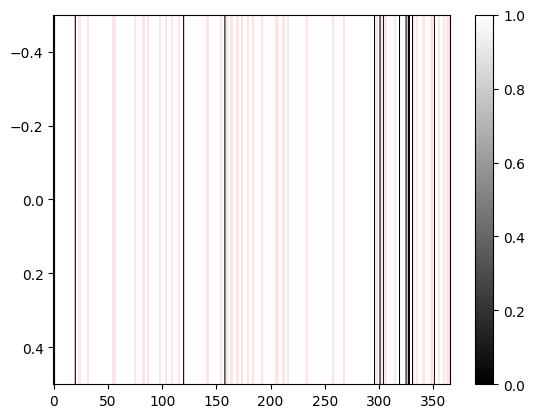

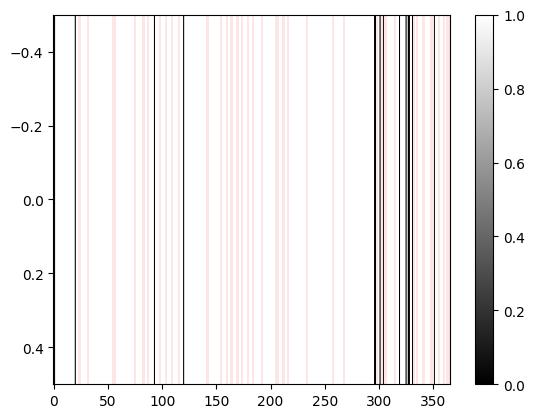

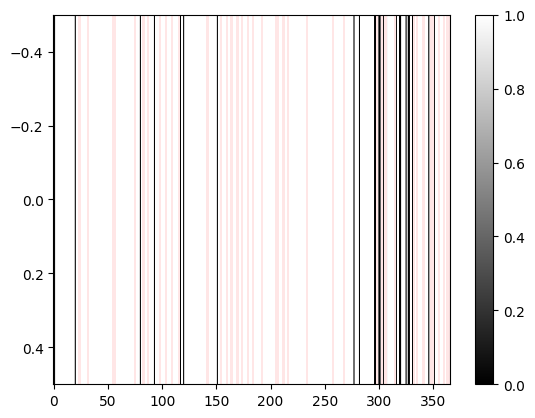

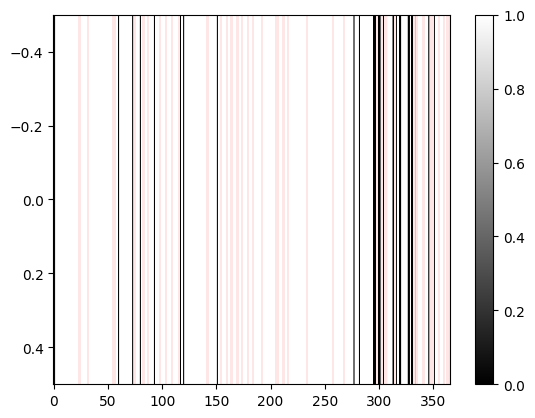

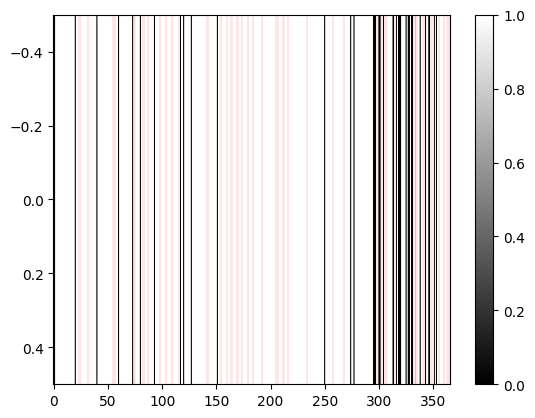

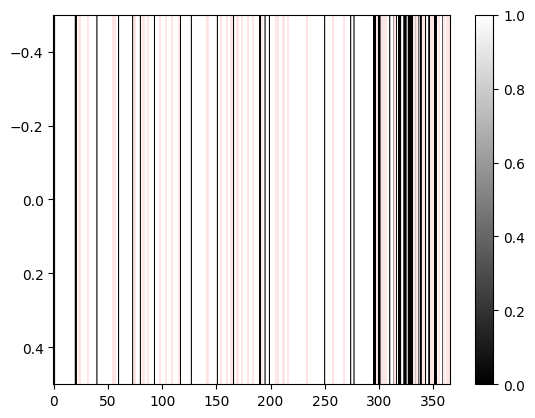

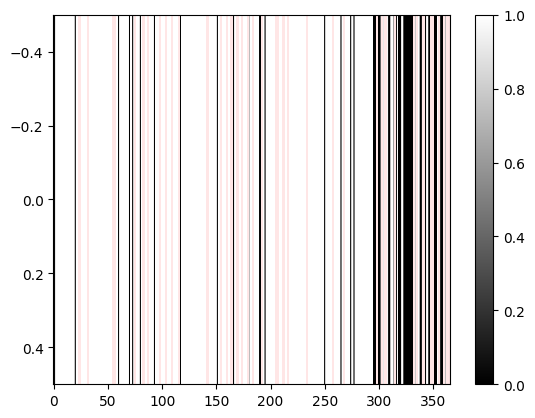

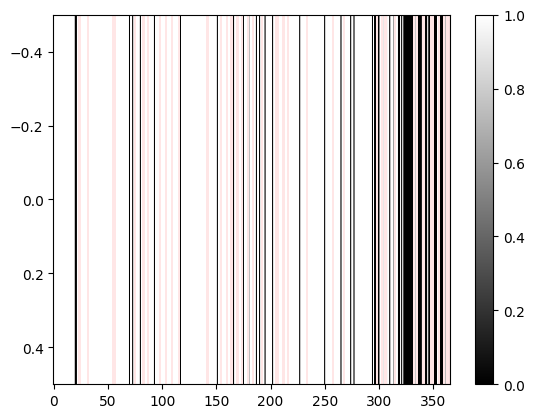

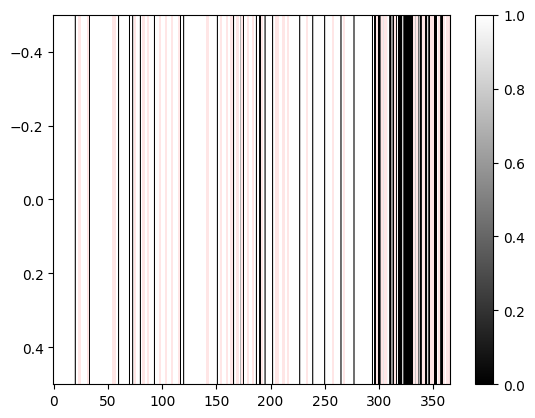

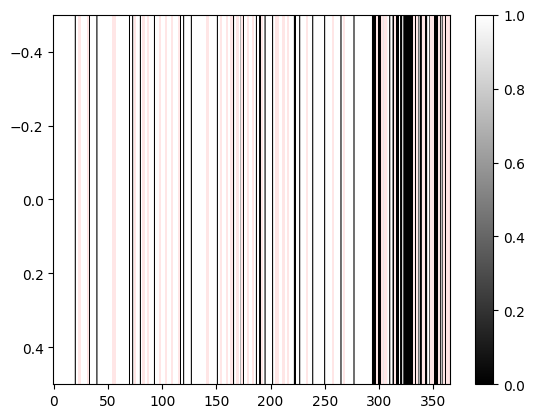

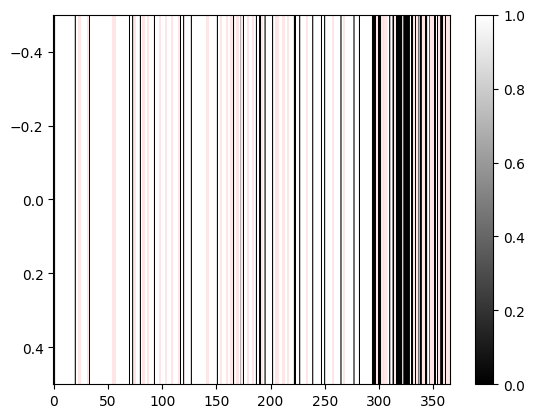

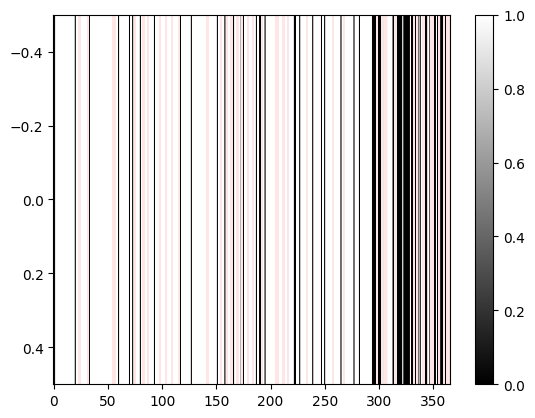

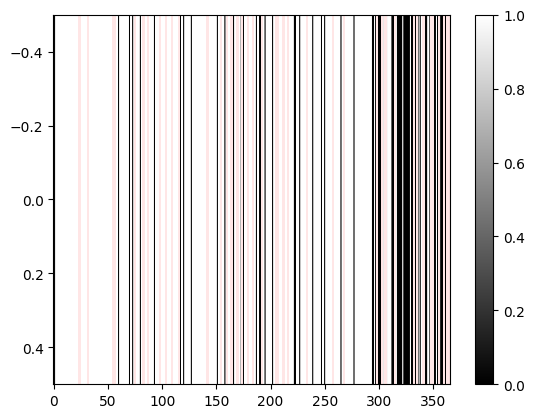

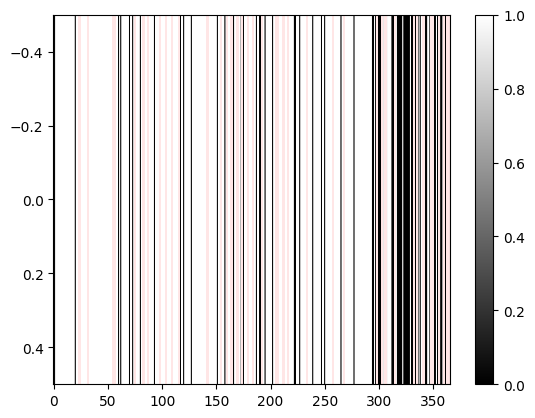

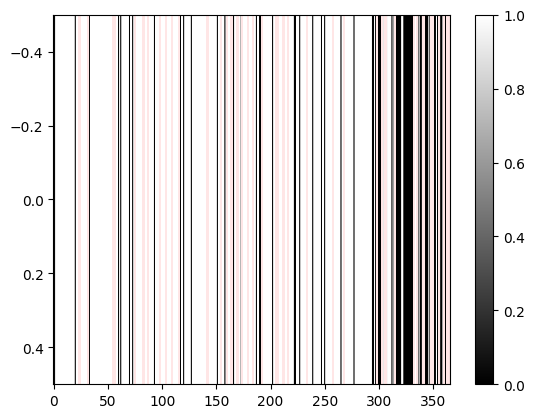

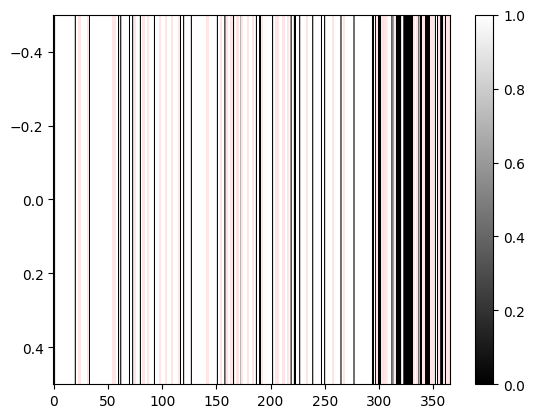

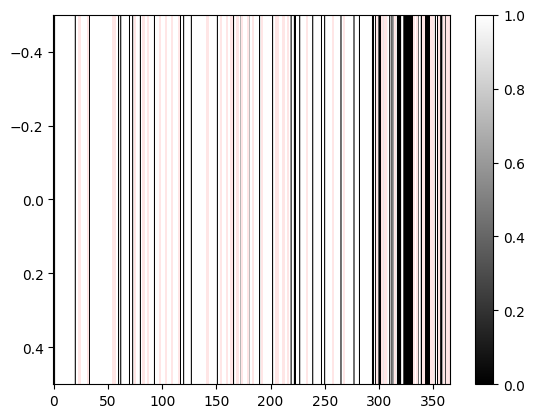

In [ ]:
# NON SEMANTIC NOISE
#grid
somegrid_l = ['v2','v3','v4'] 
#training env
someghost_l = ['RandomGhost_{"index":1,"prob":{}}','DirectionalGhost_{"index":1,"prob":0.3}','DirectionalGhost_{"index":1,"prob":0.6}'] 
somenoise_l = ['{"mean":0,"std":0}','{"mean":0,"std":0}','{"mean":0,"std":0}']
#testing env
someotherghost_l = ['RandomGhost_{"index":1,"prob":{}}','DirectionalGhost_{"index":1,"prob":0.3}','DirectionalGhost_{"index":1,"prob":0.6}']
someothernoise_l = ['{"mean":0,"std":0.1}','{"mean":0,"std":0.1}','{"mean":0,"std":0.1}']

for somegrid in somegrid_l:
    for someghost, somenoise, someotherghost, someothernoise in zip(someghost_l, somenoise_l, someotherghost_l, someothernoise_l):
        print(f"Generating gifs for {somegrid}, {someghost}, {somenoise}, {someotherghost}, {someothernoise}")
        folder = '_trial_learnability_BoltzmannAgent_' + re.sub(r"_training_agent_\d+_epoch", "", np.asarray(name[somegrid][someghost][somenoise])[0])
        subfolder = f"common_{somegrid}_{someghost}_{somenoise}_{someotherghost}_{someothernoise}"
        print(f"folder: {folder}")
        generate_gifs_inner_explored_states(folder,subfolder,somegrid, someghost, somenoise, someotherghost, someothernoise)
        input_folder = f"{folder}/{subfolder}/"
        output_file = f"{folder}/{subfolder}/{subfolder}.gif"
        create_gif(input_folder, output_file, duration=1.5)

In [ ]:
#SEMANTIC NOISE
#grid
somegrid_l = ['v2','v3','v4'] 
#training env
someghost_l = ['RandomGhost_{"index":1,"prob":{}}'] 
somenoise_l = ['{"mean":0,"std":0}']
#testing env
someotherghost_l = ['RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}']
someothernoise_l = ['{"mean":0,"std":0}']

for somegrid in somegrid_l:
    for someghost, somenoise, someotherghost, someothernoise in zip(someghost_l, somenoise_l, someotherghost_l, someothernoise_l):
        print(f"Generating gifs for {somegrid}, {someghost}, {somenoise}, {someotherghost}, {someothernoise}")
        folder = '_trial_learnability_BoltzmannAgent_' + re.sub(r"_training_agent_\d+_epoch", "", np.asarray(name[somegrid][someghost][somenoise])[0])
        subfolder = f"common_{somegrid}_{someghost}_{somenoise}_{someotherghost}_{someothernoise}"
        print(f"folder: {folder}")
        generate_gifs_inner_explored_states(folder,subfolder,somegrid, someghost, somenoise, someotherghost, someothernoise)
        input_folder = f"{folder}/{subfolder}/"
        output_file = f"{folder}/{subfolder}/{subfolder}.gif"
        create_gif(input_folder, output_file, duration=1.5)

v3 DirectionalGhost_{"index":1,"prob":0.6} {"mean":0,"std":0}
len: 100


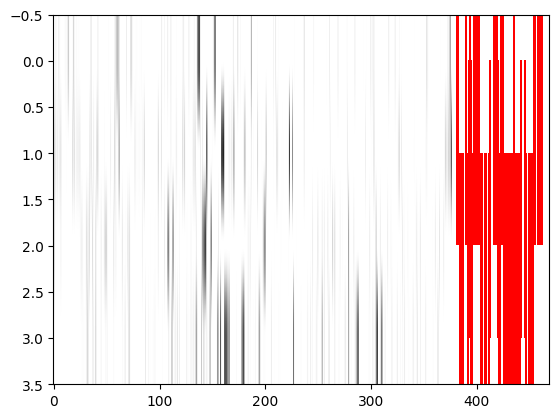

In [5]:
cmap = mpl.colormaps.get_cmap('binary')  # viridis is the default colormap for imshow
cmap.set_bad(color='red')
somegrid = 'v4' 
someghost = 'DirectionalGhost_{"index":1,"prob":0.6}' 
somenoise = '{"mean":0,"std":0}'
someothernoise = '{"mean":0,"std":0.1}'
print(somegrid, someghost, somenoise)
print(f"len: {len(data[somegrid][someghost][somenoise])}")
idxs = sorted(range(len(name[somegrid][someghost][somenoise])), key=lambda x: int(name[somegrid][someghost][somenoise][x].split('_')[-2]))
evolution_game = np.asarray(data[somegrid][someghost][somenoise])[idxs]
idxs_o = sorted_indices = sorted(range(len(name[somegrid][someghost][someothernoise])), key=lambda x: int(name[somegrid][someghost][someothernoise][x].split('_')[-2]))
evolution_game_other = np.asarray(data[somegrid][someghost][someothernoise])[idxs_o]
idx=99
action_pd_no_noise = pd.DataFrame(evolution_game[idx]).sort_index()
action_pd_noise = pd.DataFrame(evolution_game_other[idx]).sort_index()
merge = pd.merge(action_pd_no_noise, action_pd_noise, how="outer")
plt.imshow(np.where(np.isnan(merge.iloc[:4,:].to_numpy()) & np.isnan(merge.iloc[4:,:].to_numpy()), 0, abs(merge.iloc[:4,:].to_numpy() - merge.iloc[4:,:].to_numpy())), aspect="auto", cmap=cmap)

v4 RandomGhost_{"index":1,"prob":{}} {"mean":0,"std":0}
len: 100
0.0 387.35075243855584


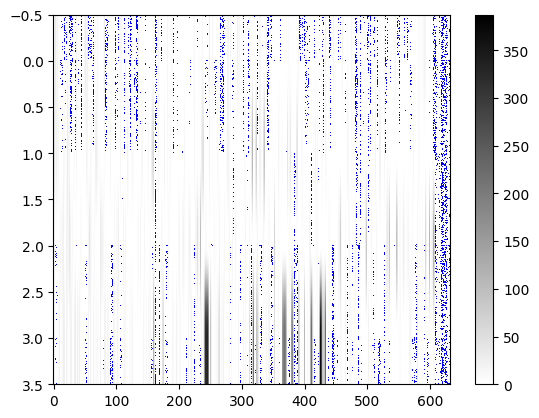

In [9]:
from matplotlib.colors import LinearSegmentedColormap
import tqdm
cmap = mpl.colormaps.get_cmap('binary')  # viridis is the default colormap for imshow

cmap.set_under(color ='blue')  # Set the color for values below vmin to blue
cmap.set_over(color ='red')
cmap.set_bad(color ='green', alpha=0.1)

somegrid = 'v4' 
someghost = 'RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}' 
someotherghost = 'RandomGhost_{"index":1,"prob":{}}' 
somenoise = '{"mean":0,"std":0}'
someothernoise = '{"mean":0,"std":0}'

print(somegrid, someghost, somenoise)
print(f"len: {len(data[somegrid][someghost][somenoise])}")
idxs = sorted(range(len(name[somegrid][someghost][somenoise])), key=lambda x: int(name[somegrid][someghost][somenoise][x].split('_')[-2]))
evolution_game = np.asarray(data[somegrid][someghost][somenoise])[idxs]
idxs_o = sorted_indices = sorted(range(len(name[somegrid][someotherghost][someothernoise])), key=lambda x: int(name[somegrid][someotherghost][someothernoise][x].split('_')[-2]))
evolution_game_other = np.asarray(data[somegrid][someotherghost][someothernoise])[idxs_o]
all_columns = pd.merge(pd.DataFrame(evolution_game[-1]).fillna(np.nan).astype(float), pd.DataFrame(evolution_game_other[-1]).fillna(np.nan).astype(float), how="outer").columns

sortex_idx = 86
#fig, ax = plt.subplots(1,1, figsize=(27,27))
action_pd_no_noise = pd.DataFrame(evolution_game[sortex_idx]).sort_index()
action_pd_noise = pd.DataFrame(evolution_game_other[sortex_idx]).sort_index()

action_pd_no_noise_complete = pd.concat([action_pd_no_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_no_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
action_pd_noise_complete = pd.concat([action_pd_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
common_nan_mask = np.isnan(action_pd_no_noise_complete.values) & np.isnan(action_pd_noise_complete.values)
action_pd_noise_nan_mask = np.isnan(action_pd_noise_complete.values) & ~np.isnan(action_pd_no_noise_complete.values)
action_pd_no_noise_nan_mask = np.isnan(action_pd_no_noise_complete.values) & ~np.isnan(action_pd_noise_complete.values)

merge = pd.merge(action_pd_no_noise_complete, action_pd_noise_complete, how='outer')[all_columns]
a = abs(merge.iloc[:4,:].to_numpy() - merge.iloc[4:,:].to_numpy())
min = np.nanmin(a)
max = np.nanmax(a)
a[common_nan_mask] = 0
print(min,max)
if np.any(action_pd_noise_nan_mask == 1):
    a[action_pd_noise_nan_mask] = np.nanmax(a) + 1
if np.any(action_pd_no_noise_nan_mask == 1):
    a[action_pd_no_noise_nan_mask] = np.nanmin(a) - 1
if np.any(action_pd_no_noise_nan_mask == 1):
    column_mask = np.all(common_nan_mask, axis=0)
    masked_data = np.ma.masked_array(common_nan_mask, mask=np.repeat(column_mask.reshape(1,-1), 4, axis=0))
    a[masked_data.mask] = np.nan
plt.imshow(a, aspect="auto", cmap=cmap)
plt.colorbar()
plt.show()

In [27]:
'_trial_learnability_BoltzmannAgent_v2_DirectionalGhost_{"index":1,"prob":0.4}_{"mean":0,"std":0.1}'
'_trial_learnability_BoltzmannAgent_' + re.sub(r"_training_agent_\d+_epoch", "", np.asarray(name[somegrid][someghost][noise])[idxs][99])

'_trial_learnability_BoltzmannAgent_v4_RandomGhost_{"index":1,"prob":{}}_{"mean":0,"std":0}'

v2 RandomGhostTeleportingNearWalls_{"index":1,"prob":{}} {"mean":0,"std":0}
len: 100
min: -1.0, max: 26.450000000000003
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_0_epoch


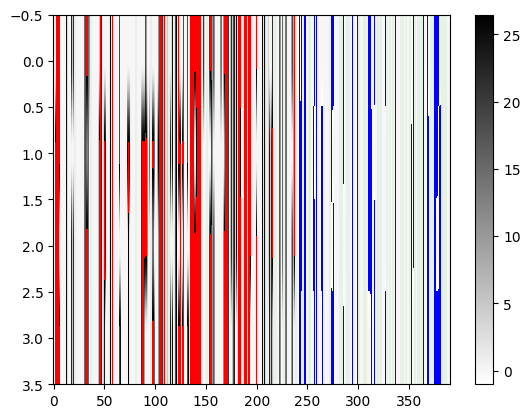

min: -1.0, max: 26.450000000000003
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_1_epoch


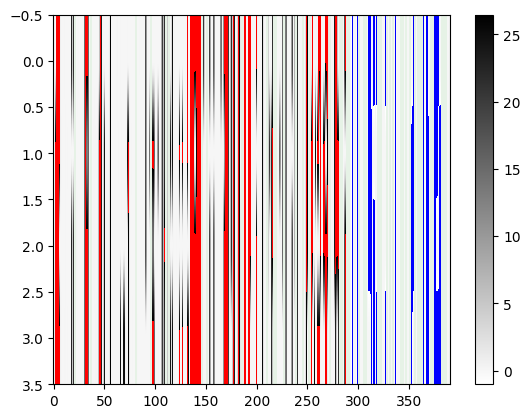

min: -1.0, max: 95.41631875
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_2_epoch


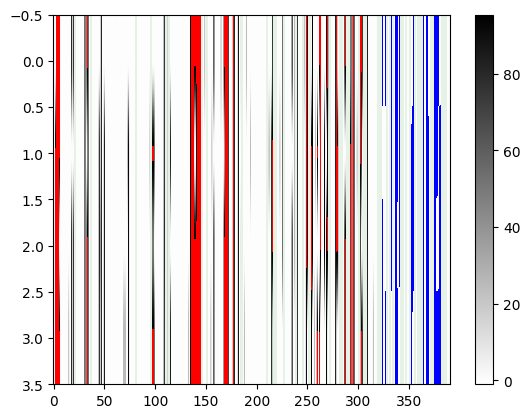

min: -1.0, max: 116.1455028125
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_3_epoch


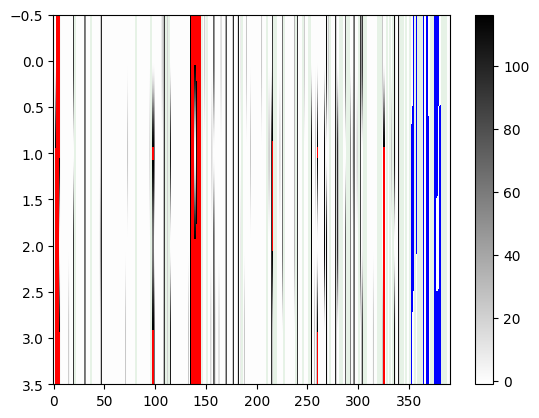

min: -1.0, max: 116.1455028125
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_4_epoch


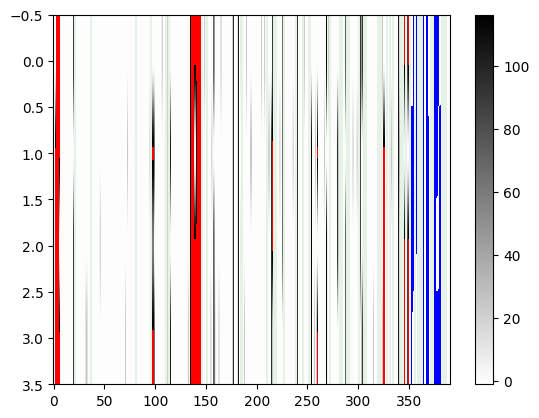

min: -1.0, max: 116.1455028125
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_5_epoch


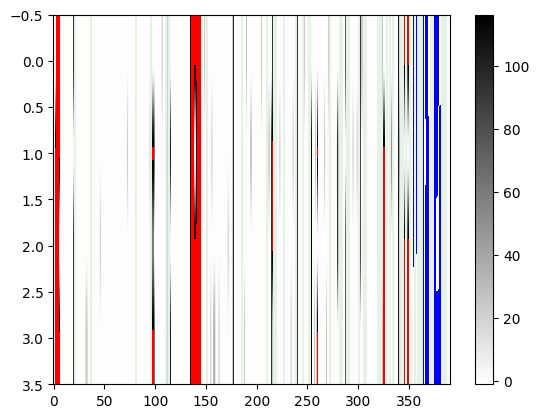

min: -1.0, max: 135.838227671875
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_6_epoch


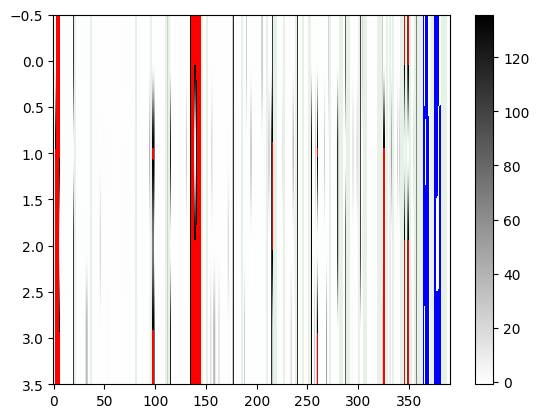

min: -1.0, max: 172.3190004738672
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_7_epoch


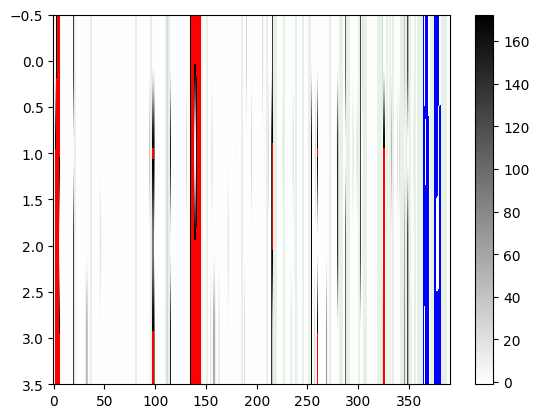

min: -1.0, max: 172.3190004738672
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_8_epoch


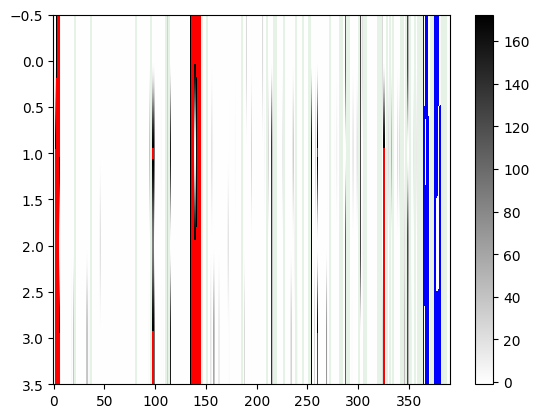

min: -1.0, max: 172.3190004738672
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_9_epoch


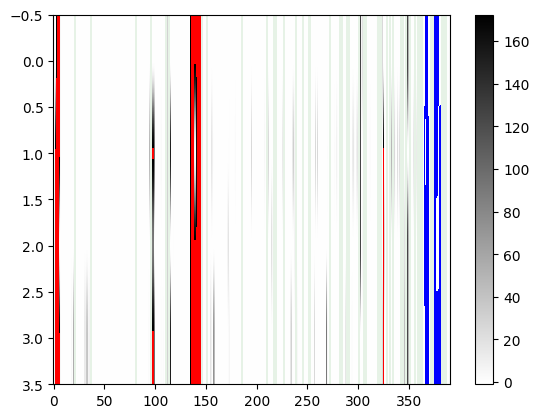

min: -1.0, max: 172.3190004738672
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_10_epoch


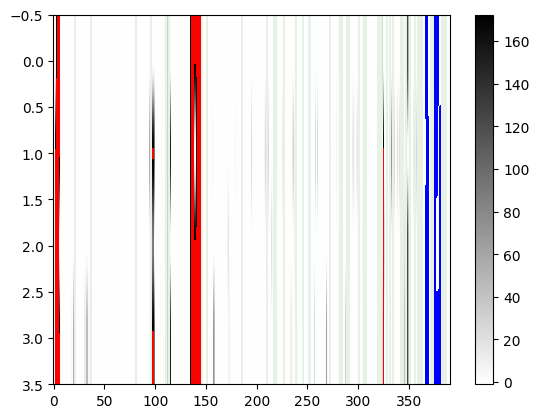

min: -1.0, max: 122.6915004738672
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_11_epoch


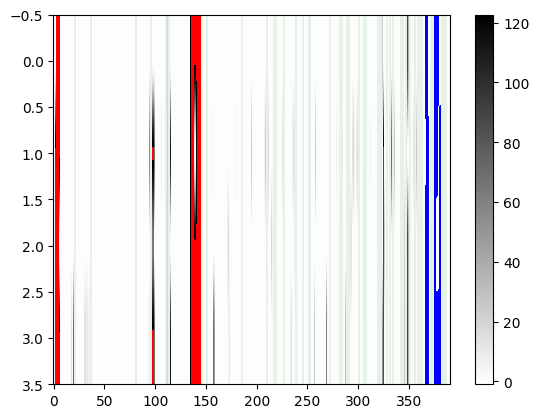

min: -1.0, max: 135.838227671875
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_12_epoch


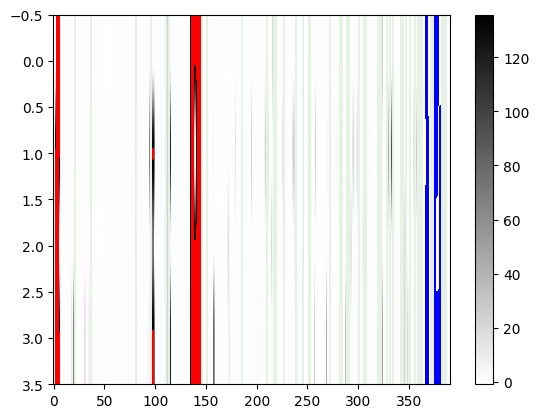

min: -1.0, max: 154.54631628828125
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_13_epoch


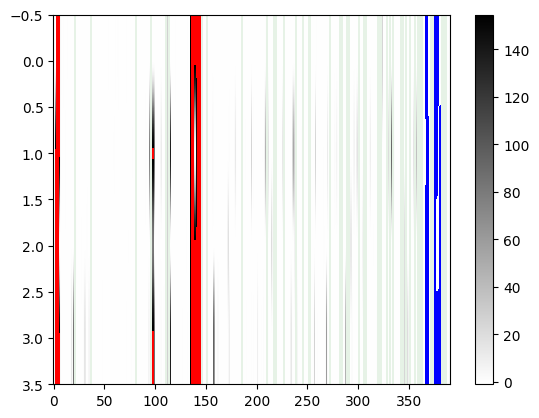

min: -1.0, max: 154.54631628828125
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_14_epoch


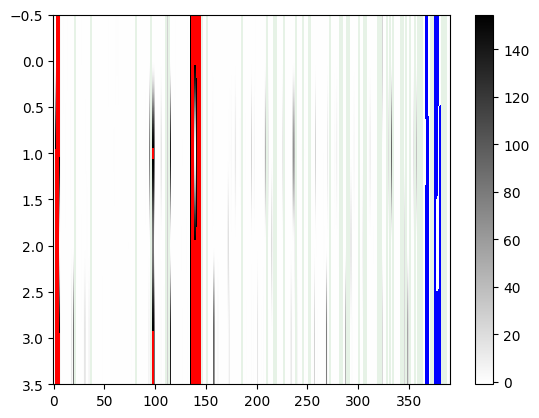

min: -1.0, max: 172.3190004738672
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_15_epoch


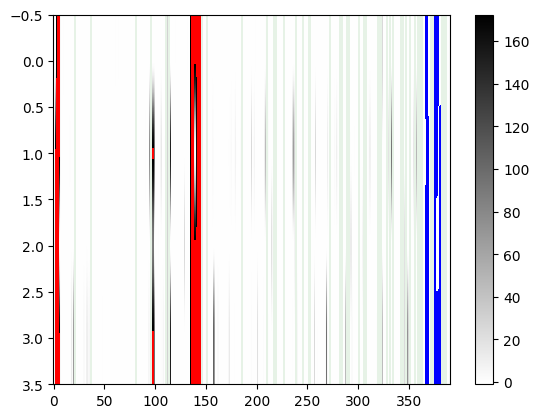

min: -1.0, max: 189.20305045017383
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_16_epoch


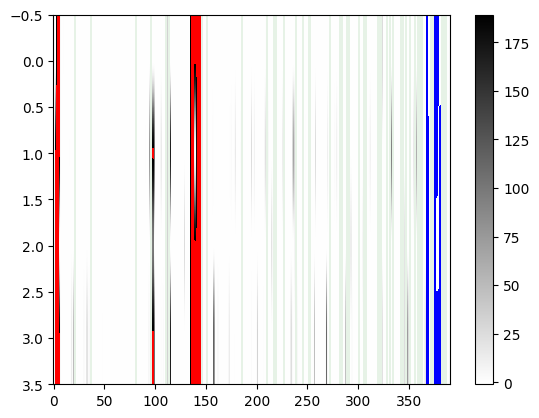

min: -1.0, max: 205.24289792766515
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_17_epoch


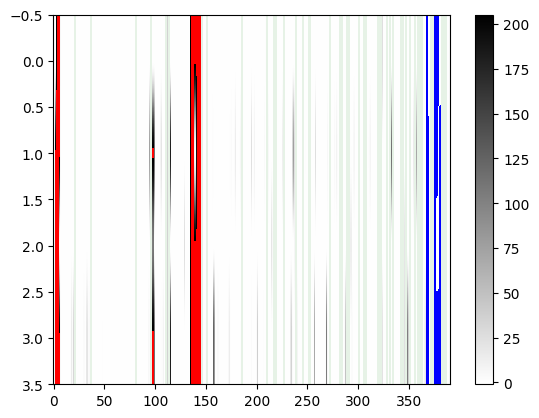

min: -1.0, max: 179.79289792766514
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_18_epoch


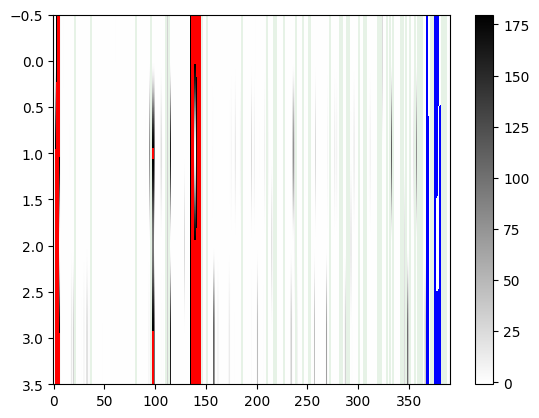

min: -1.0, max: 195.0307530312819
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_19_epoch


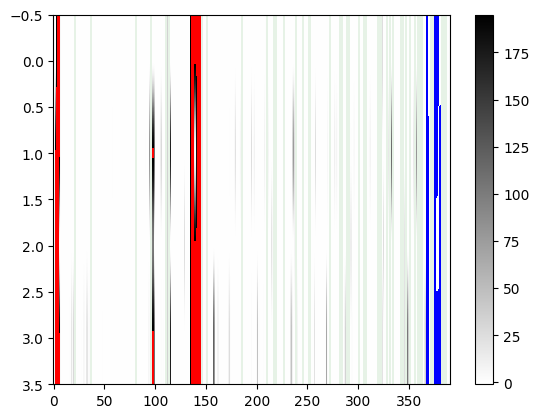

min: -1.0, max: 195.0307530312819
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_20_epoch


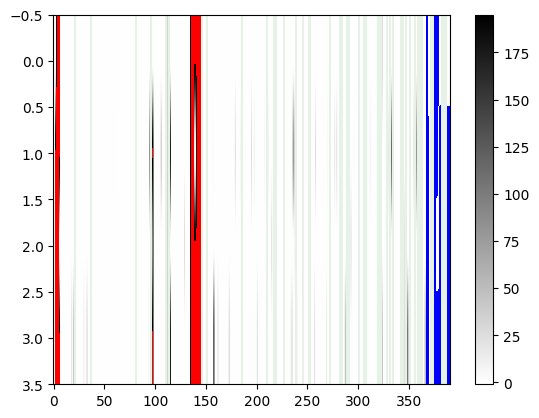

min: -1.0, max: 170.8532530312819
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_21_epoch


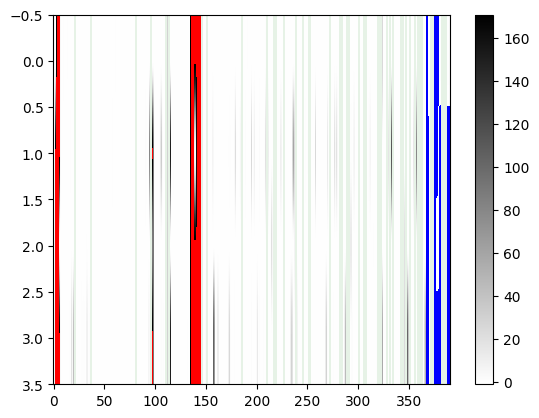

min: -1.0, max: 154.54631628828125
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_22_epoch


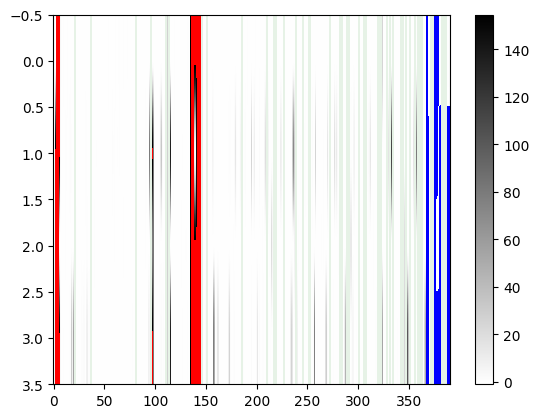

min: -1.0, max: 172.3190004738672
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_23_epoch


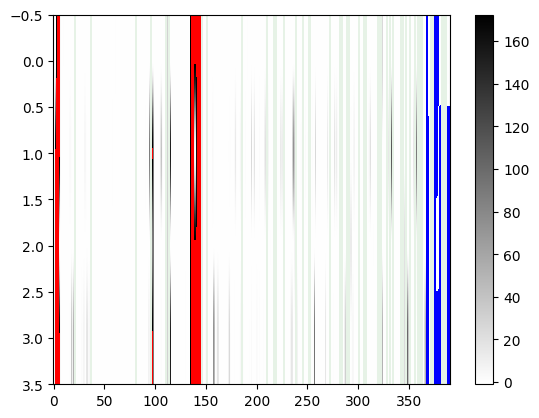

min: -1.0, max: 172.3190004738672
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_24_epoch


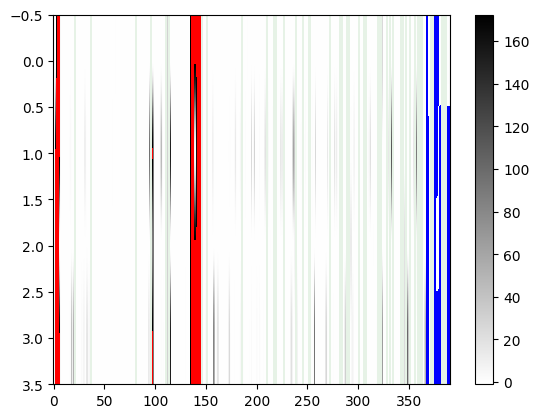

min: -1.0, max: 189.20305045017383
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_25_epoch


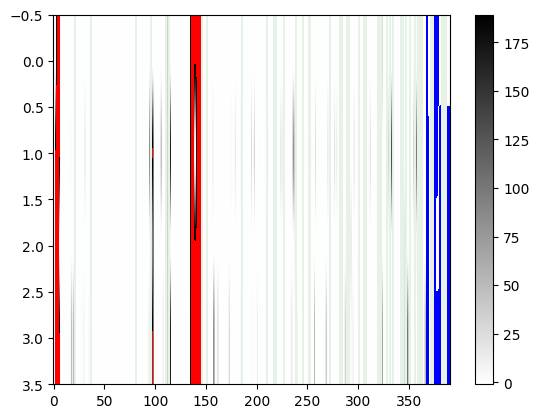

min: -1.0, max: 189.20305045017383
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_26_epoch


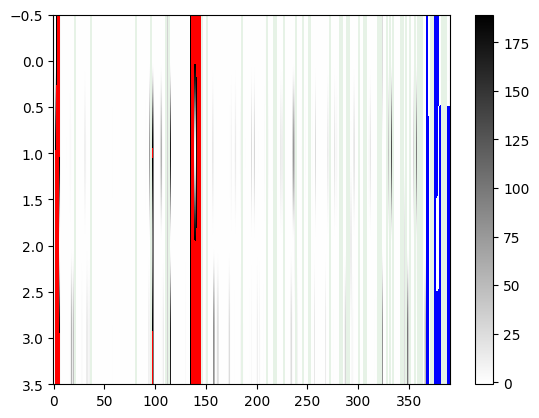

min: -1.0, max: 189.20305045017383
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_27_epoch


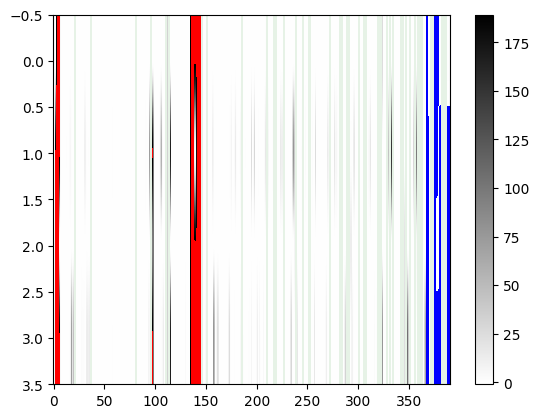

min: -1.0, max: 189.20305045017383
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_28_epoch


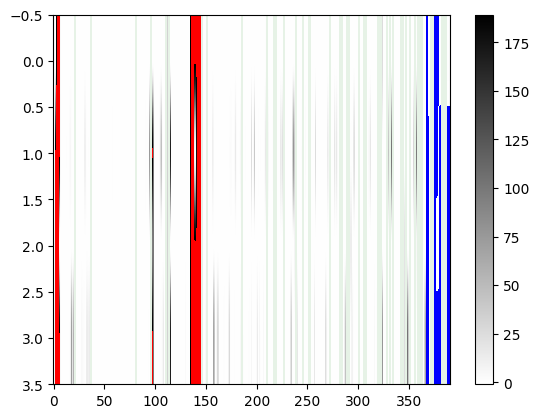

min: -1.0, max: 189.20305045017383
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_29_epoch


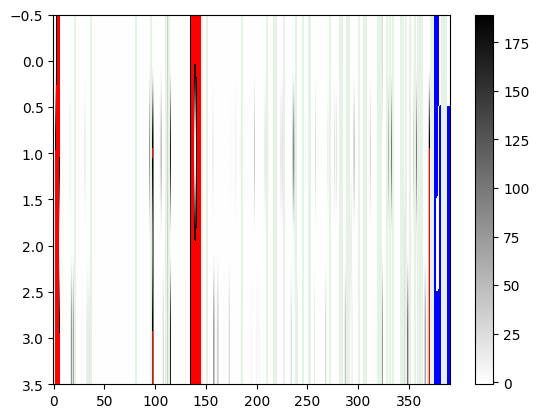

min: -1.0, max: 205.24289792766515
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_30_epoch


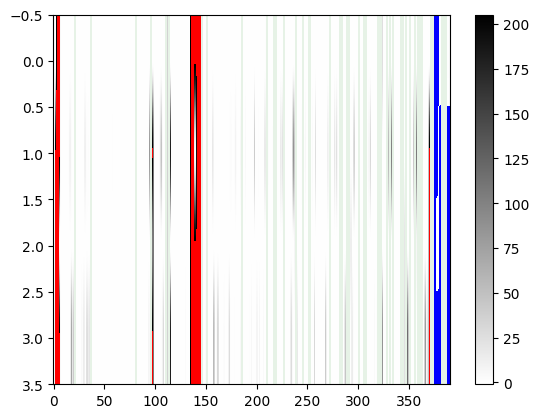

min: -1.0, max: 205.24289792766515
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_31_epoch


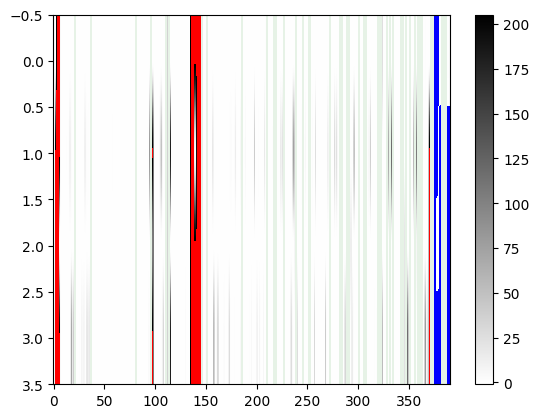

min: -1.0, max: 220.4807530312819
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_32_epoch


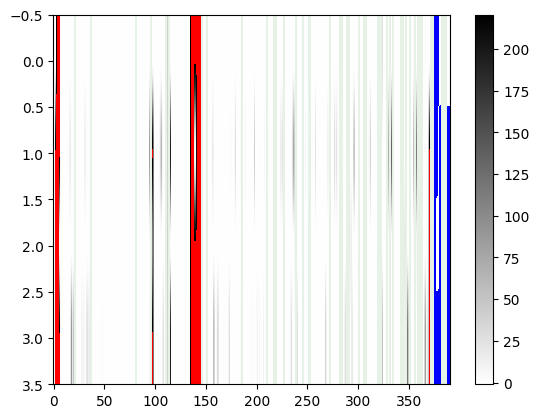

min: -1.0, max: 220.4807530312819
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_33_epoch


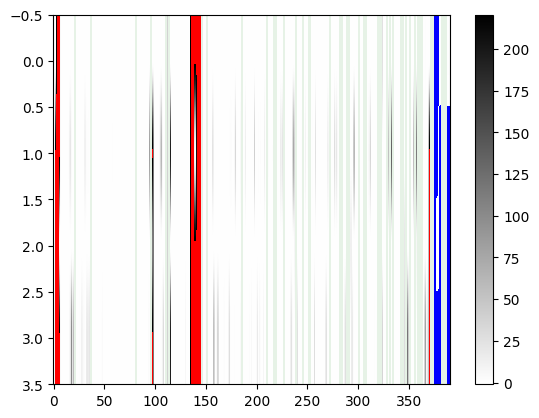

min: -1.0, max: 220.4807530312819
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_34_epoch


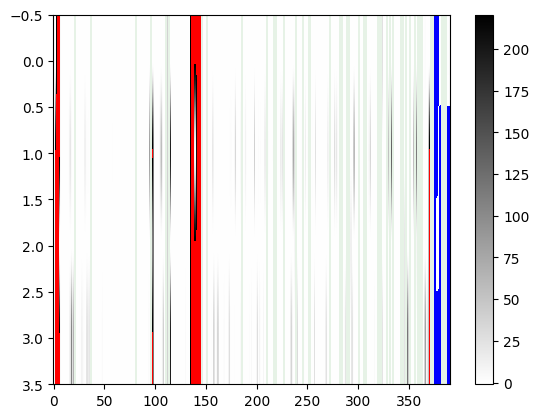

min: -1.0, max: 248.7088796107319
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_35_epoch


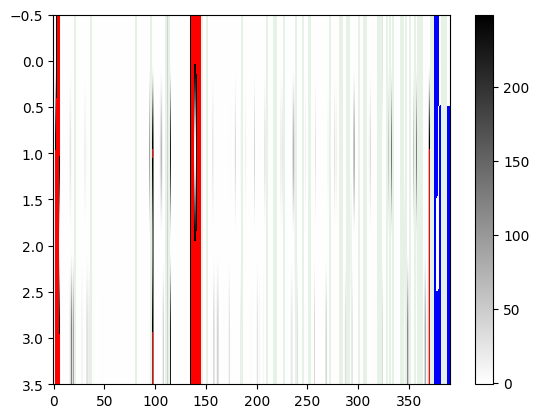

min: -1.0, max: 248.7088796107319
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_36_epoch


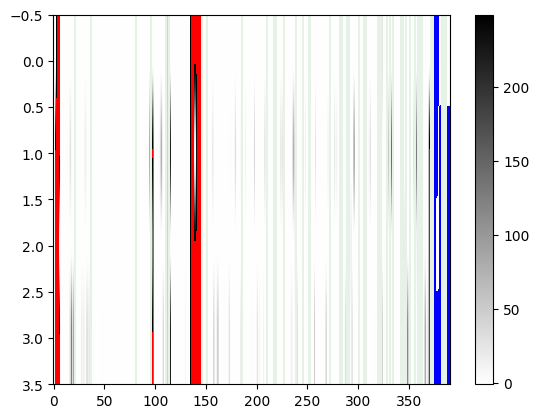

min: -1.0, max: 248.7088796107319
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_37_epoch


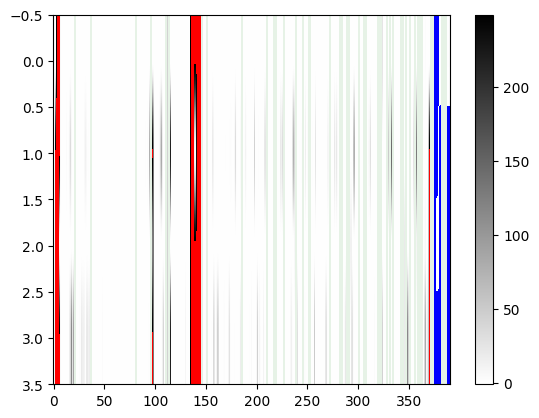

min: -1.0, max: 248.7088796107319
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_38_epoch


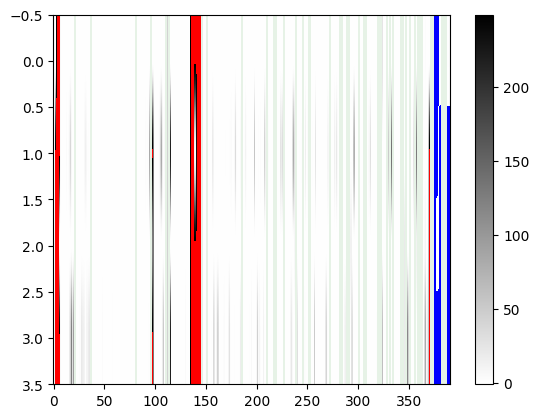

min: -1.0, max: 261.7734356301953
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_39_epoch


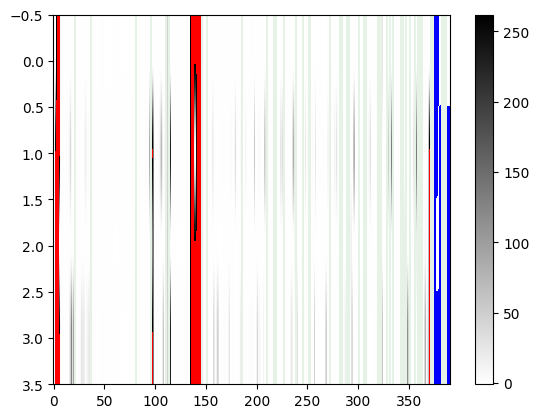

min: -1.0, max: 261.7734356301953
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_40_epoch


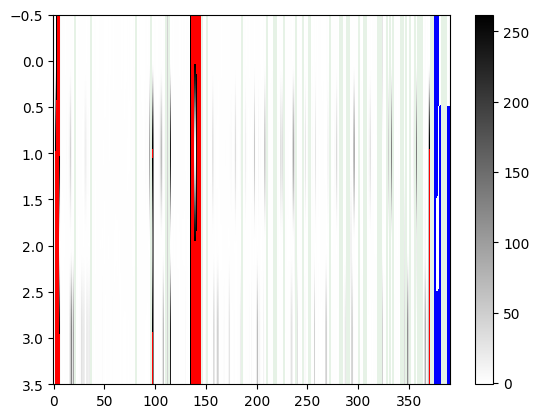

min: -1.0, max: 261.7734356301953
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_41_epoch


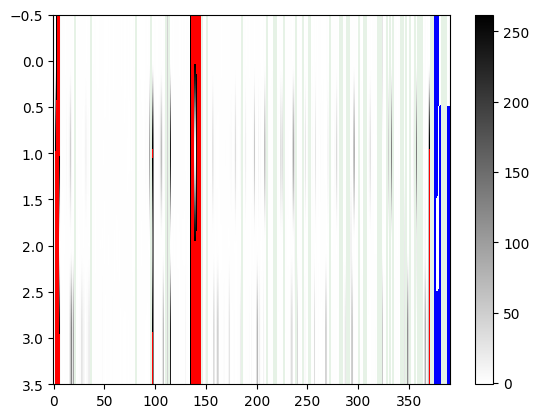

min: -1.0, max: 261.7734356301953
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_42_epoch


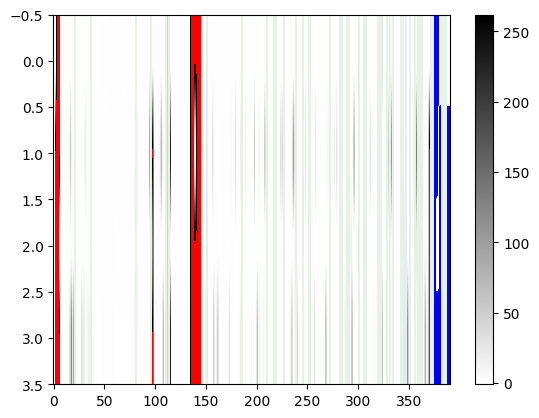

min: -1.0, max: 261.7734356301953
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_43_epoch


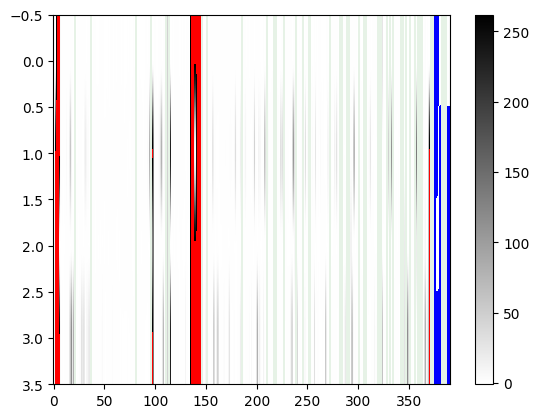

min: -1.0, max: 261.7734356301953
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_44_epoch


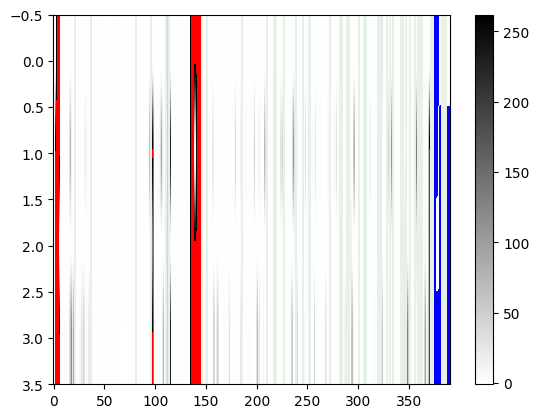

min: -1.0, max: 261.7734356301953
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_45_epoch


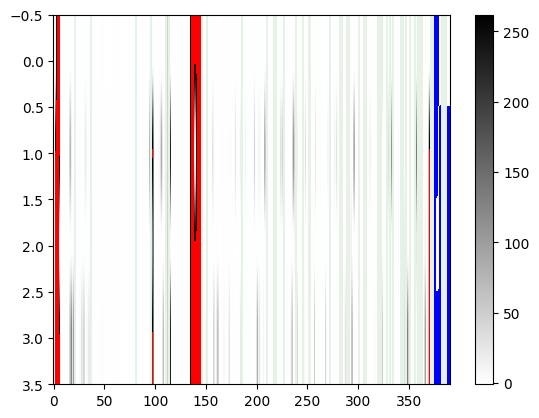

min: -1.0, max: 261.7734356301953
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_46_epoch


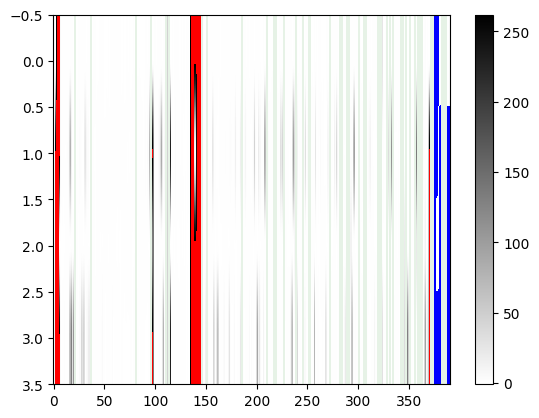

min: -1.0, max: 261.7734356301953
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_47_epoch


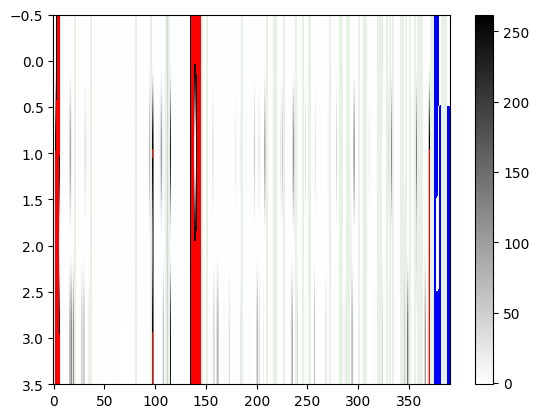

min: -1.0, max: 285.97552565625125
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_48_epoch


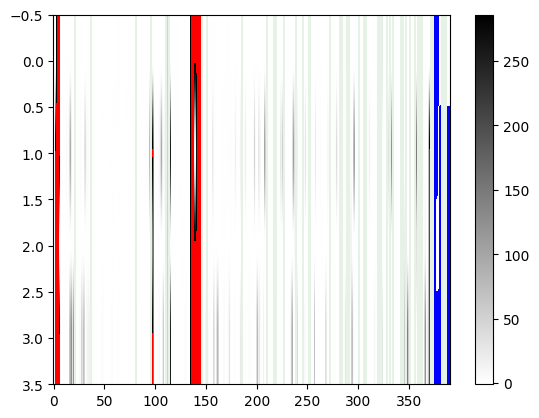

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_49_epoch


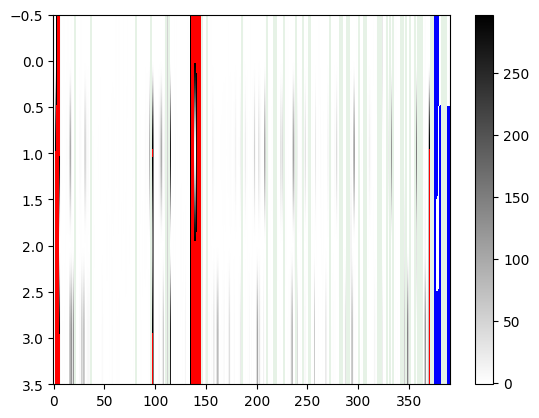

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_50_epoch


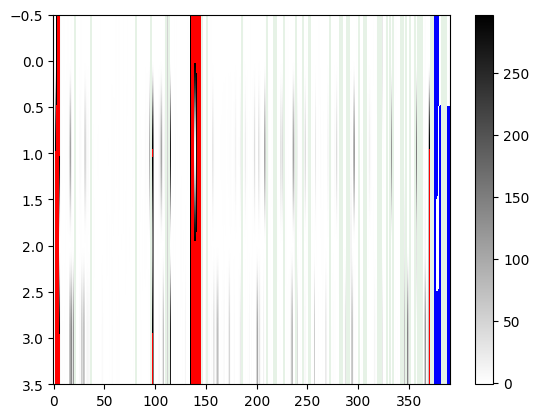

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_51_epoch


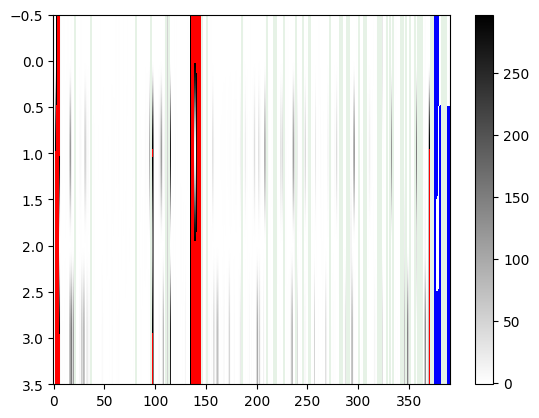

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_52_epoch


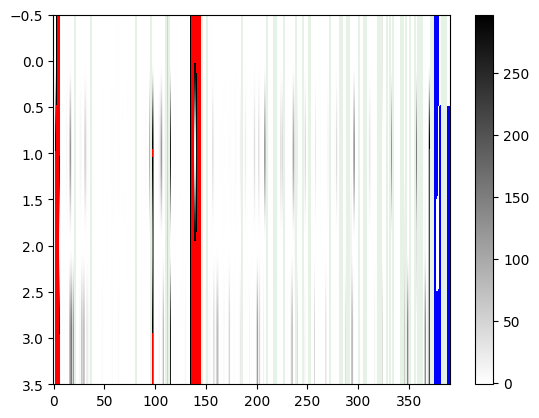

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_53_epoch


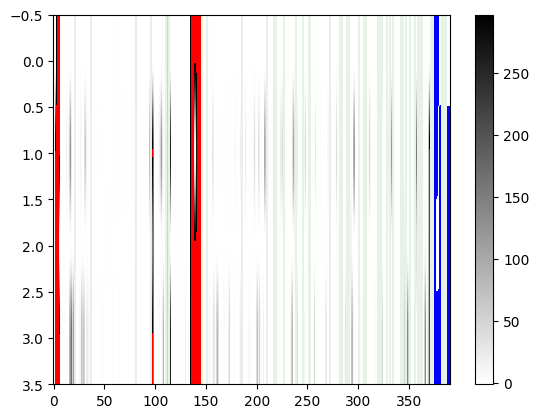

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_54_epoch


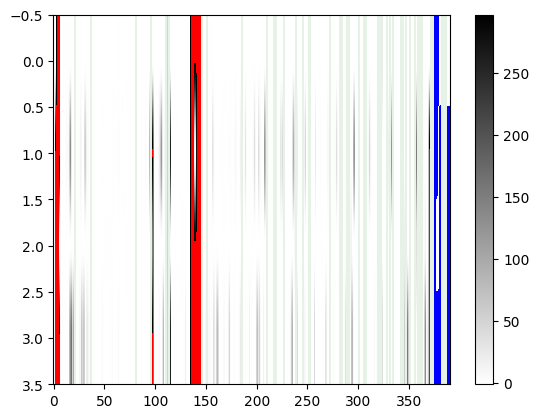

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_55_epoch


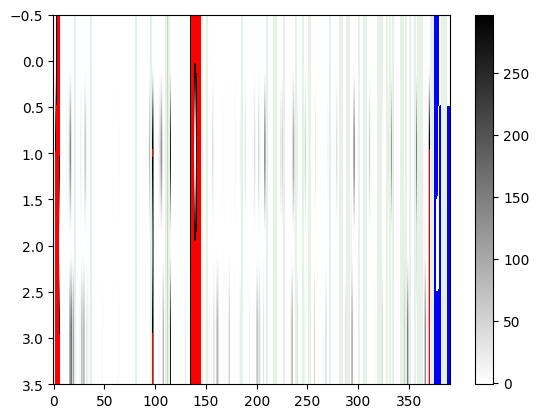

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_56_epoch


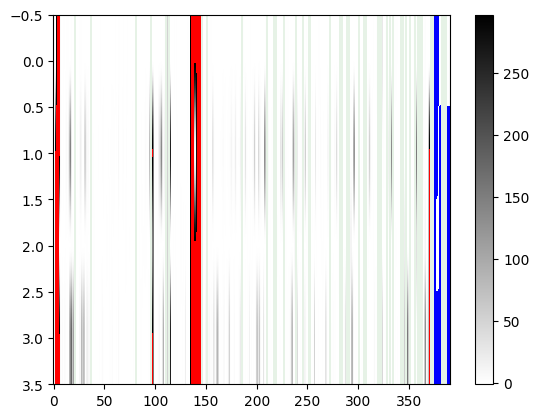

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_57_epoch


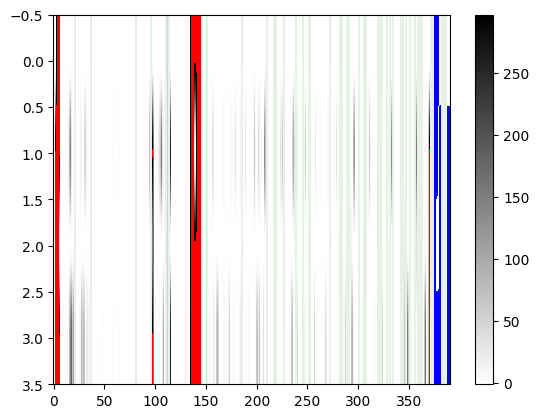

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_58_epoch


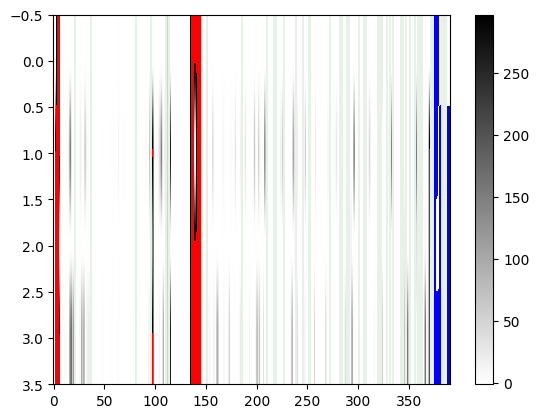

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_59_epoch


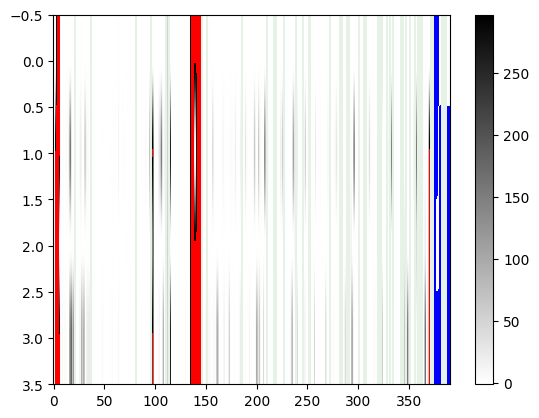

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_60_epoch


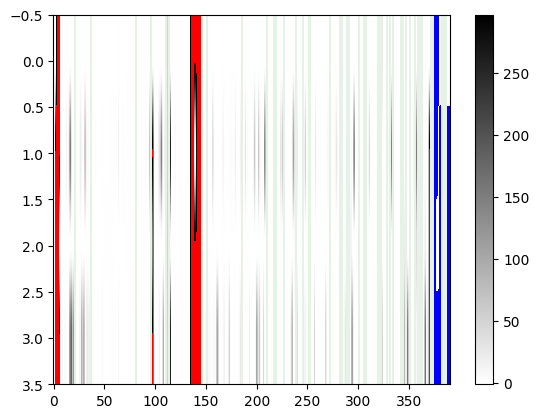

min: -1.0, max: 297.17674937343867
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_61_epoch


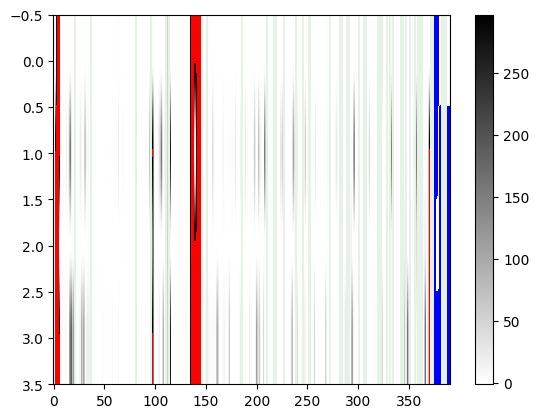

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_62_epoch


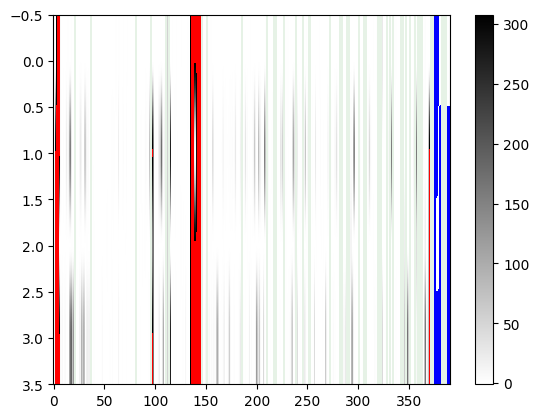

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_63_epoch


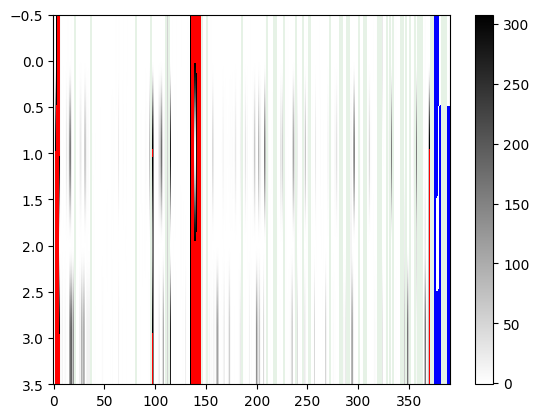

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_64_epoch


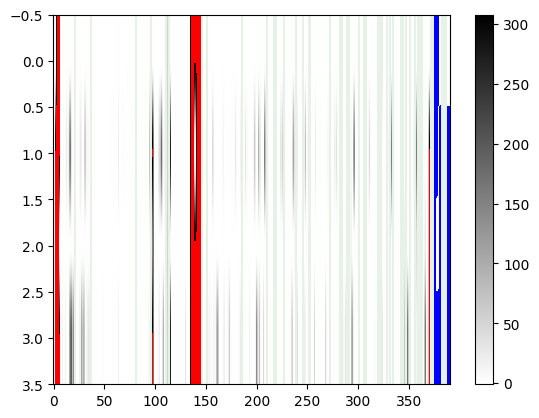

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_65_epoch


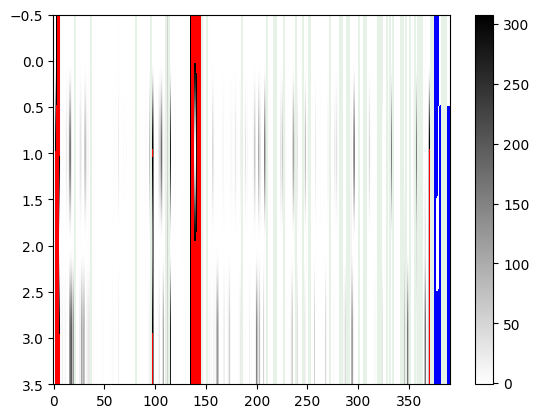

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_66_epoch


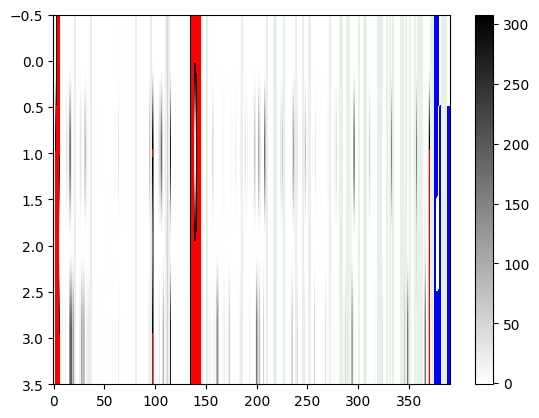

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_67_epoch


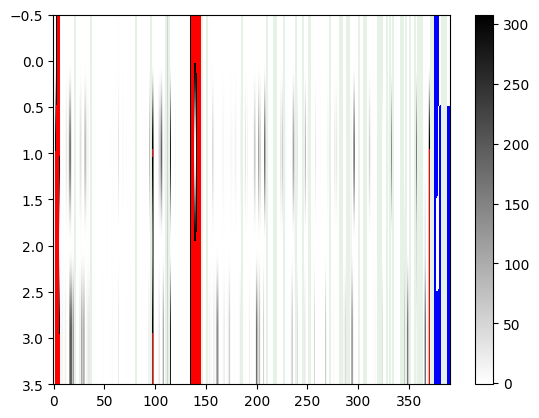

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_68_epoch


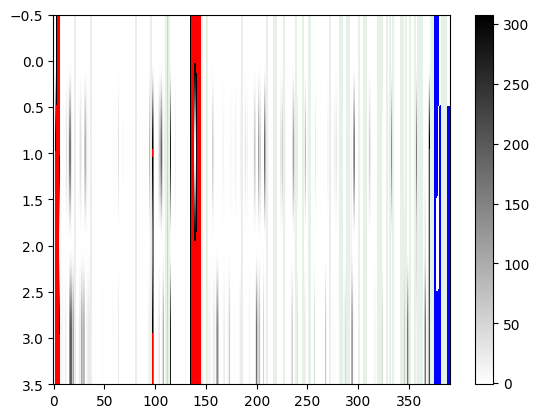

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_69_epoch


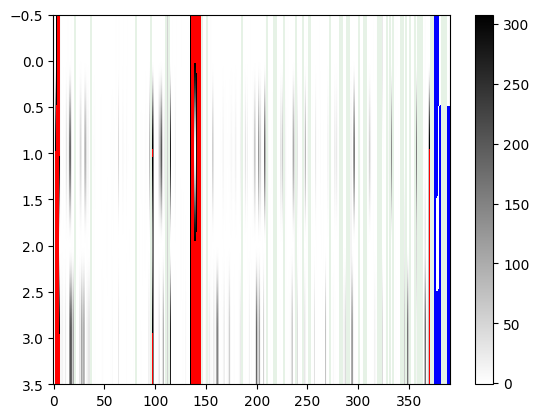

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_70_epoch


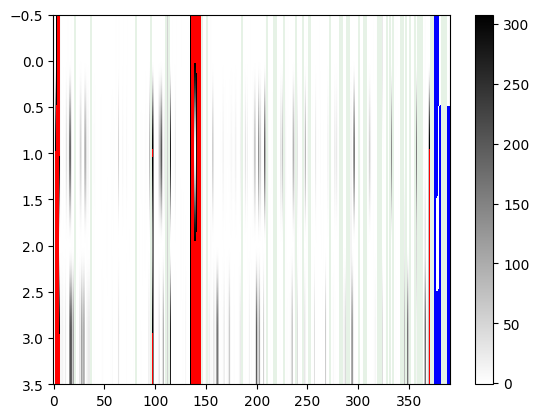

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_71_epoch


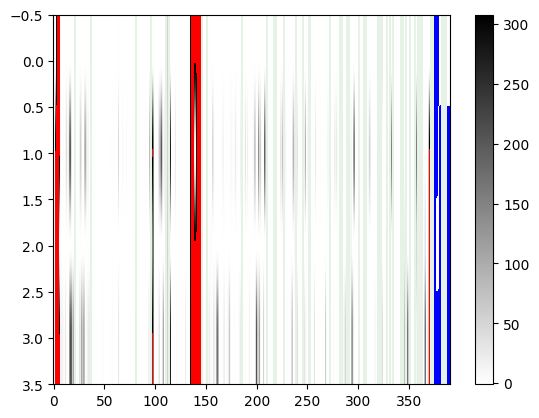

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_72_epoch


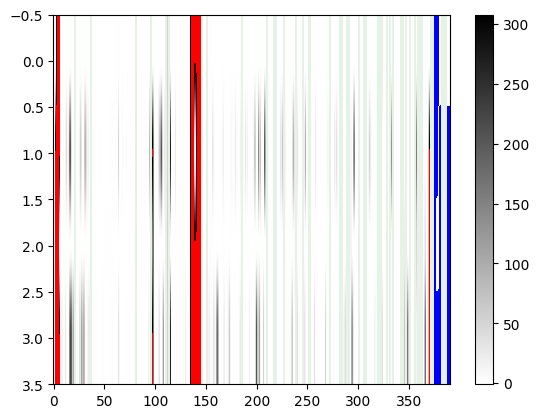

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_73_epoch


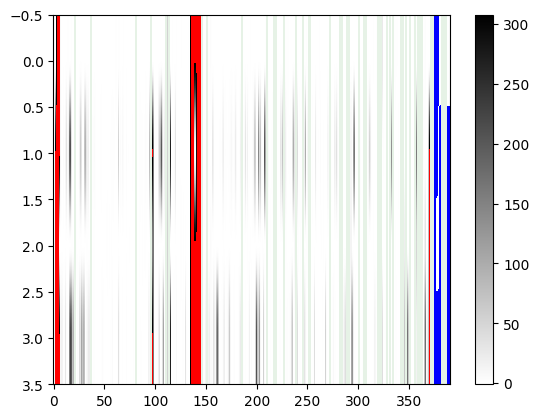

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_74_epoch


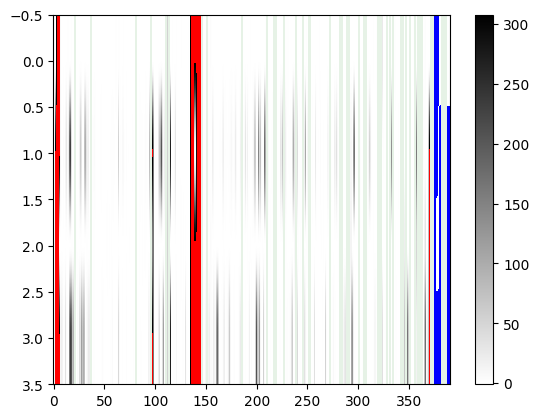

min: -1.0, max: 307.81791190476673
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_75_epoch


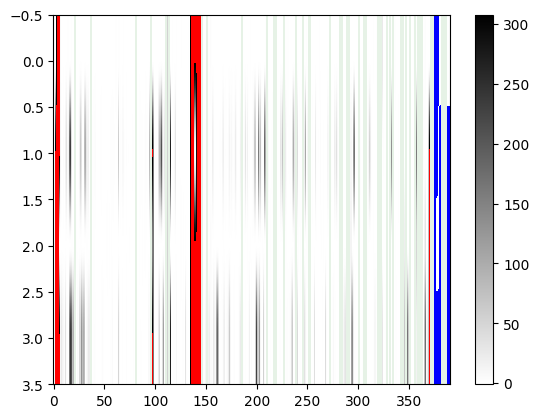

min: -1.0, max: 317.92701630952837
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_76_epoch


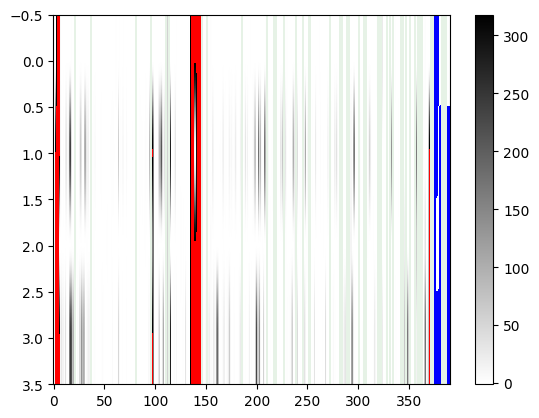

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_77_epoch


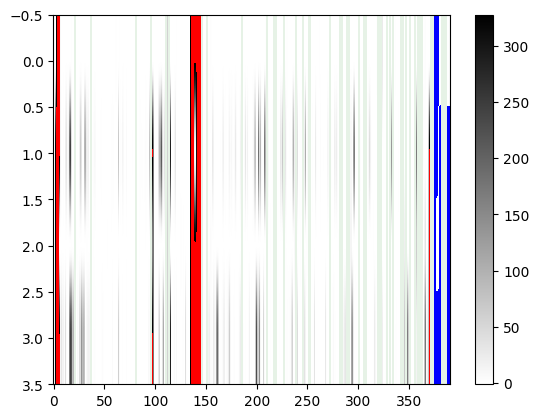

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_78_epoch


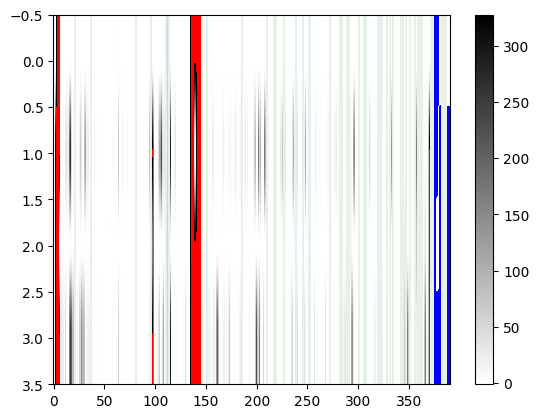

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_79_epoch


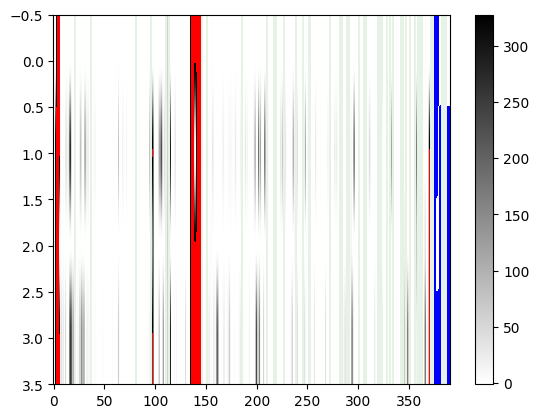

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_80_epoch


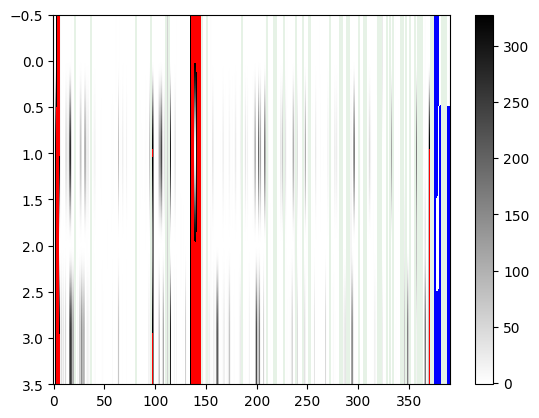

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_81_epoch


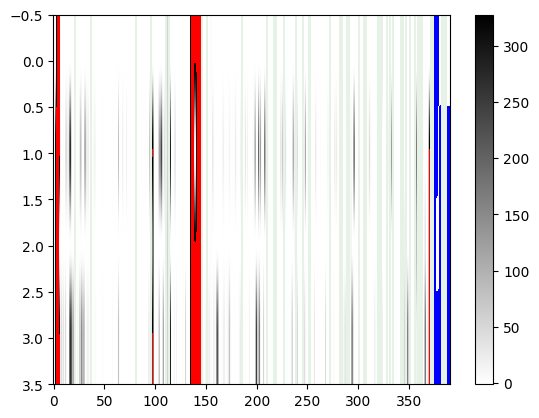

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_82_epoch


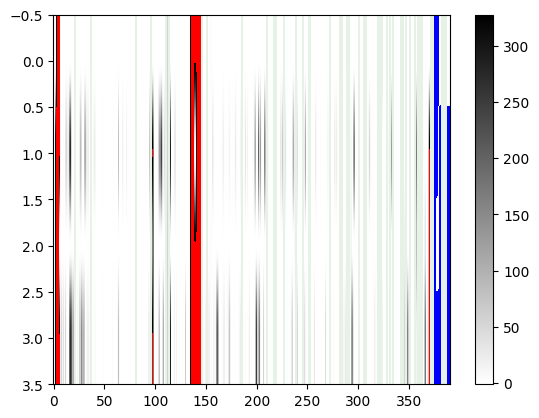

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_83_epoch


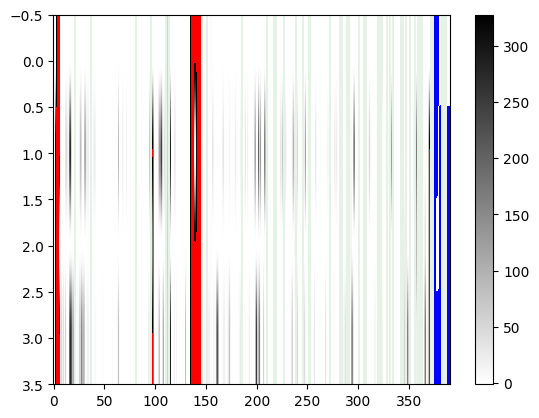

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_84_epoch


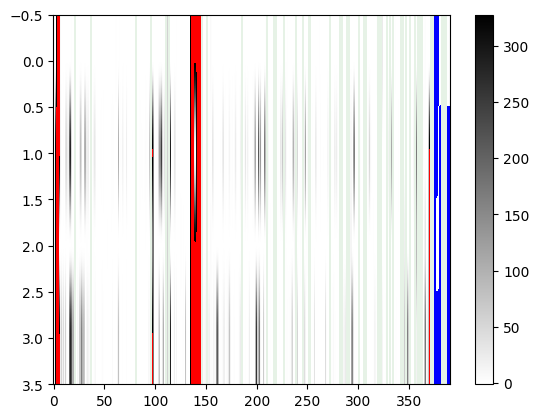

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_85_epoch


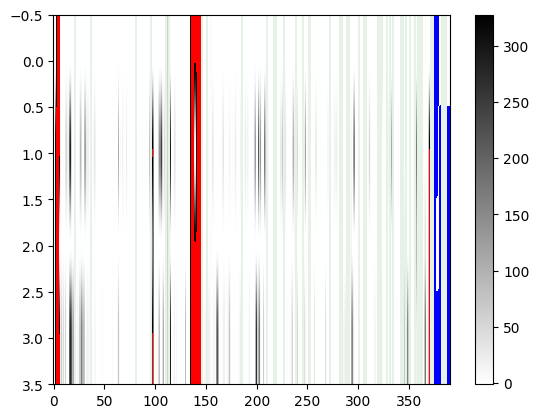

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_86_epoch


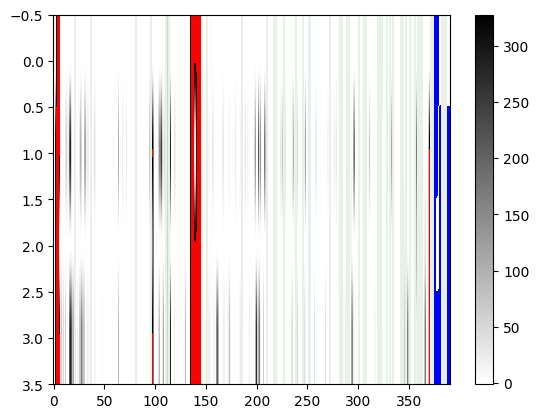

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_87_epoch


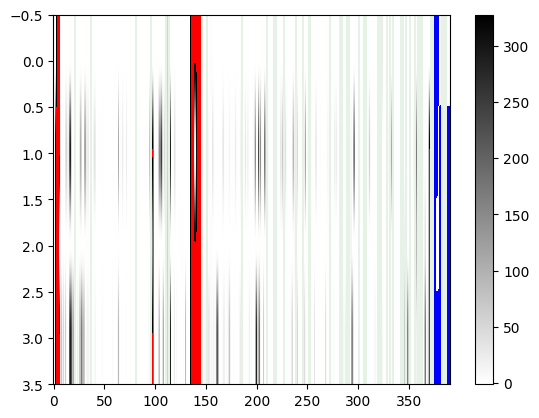

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_88_epoch


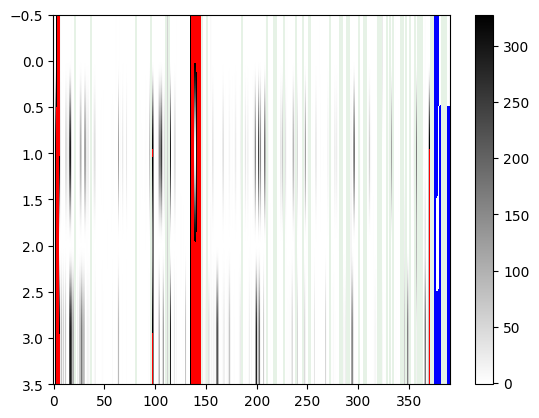

min: -1.0, max: 327.53066549405196
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_89_epoch


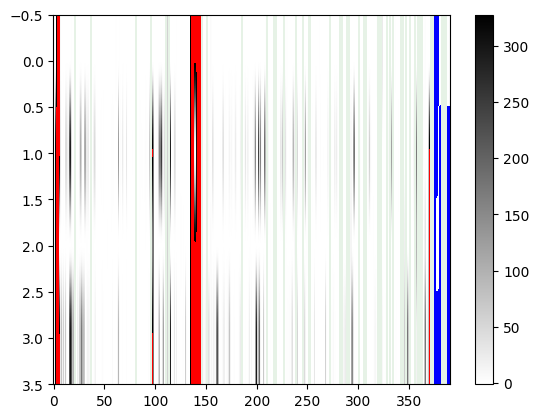

min: -1.0, max: 331.46826021642
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_90_epoch


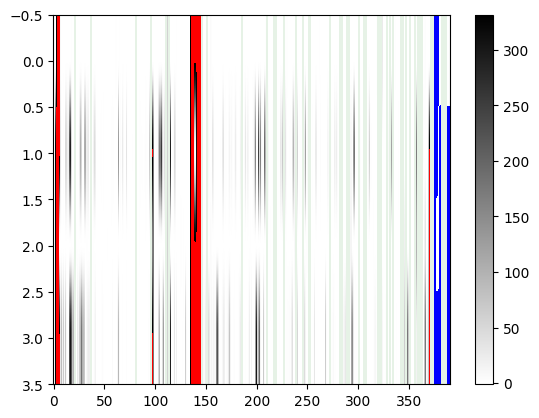

min: -1.0, max: 337.82643052167714
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_91_epoch


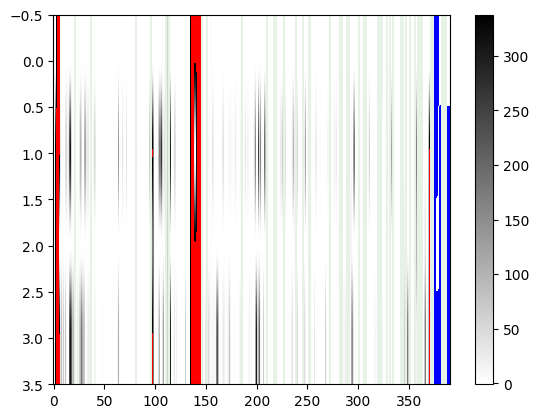

min: -1.0, max: 337.82643052167714
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_92_epoch


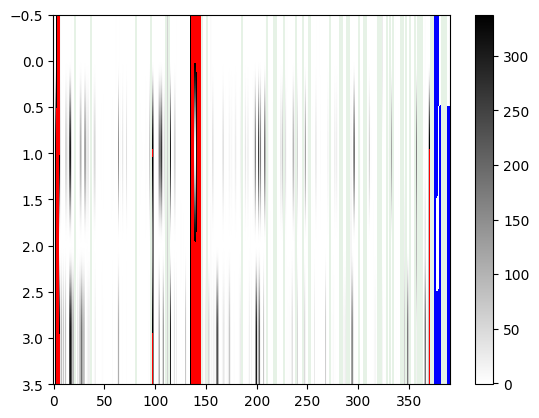

min: -1.0, max: 337.82643052167714
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_93_epoch


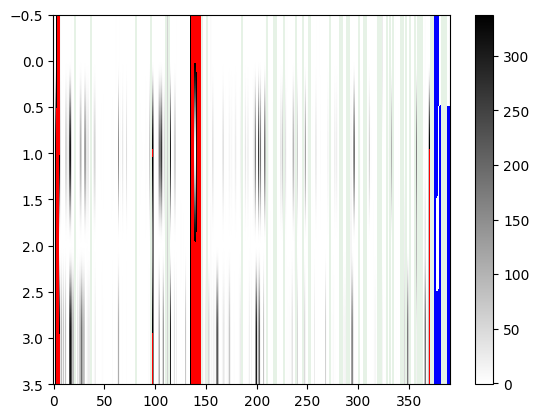

min: -1.0, max: 337.82643052167714
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_94_epoch


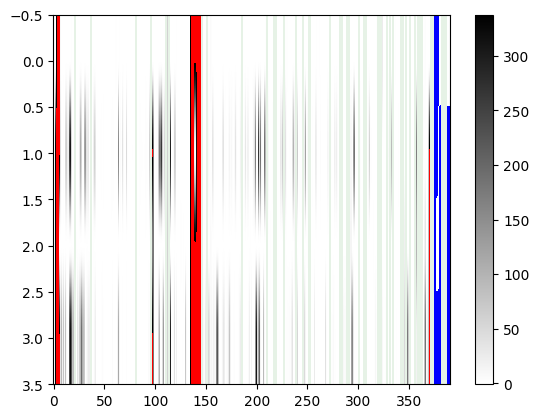

min: -1.0, max: 340.30590302931466
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_95_epoch


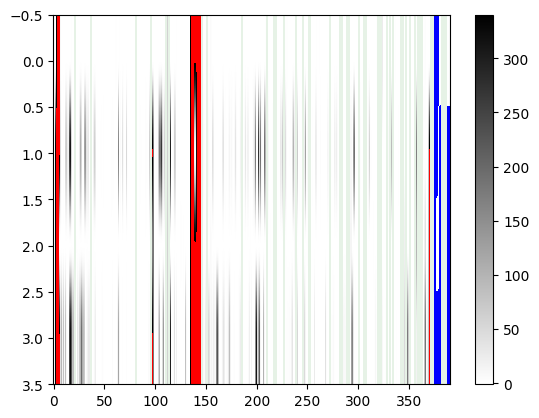

min: -1.0, max: 341.26500308753356
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_96_epoch


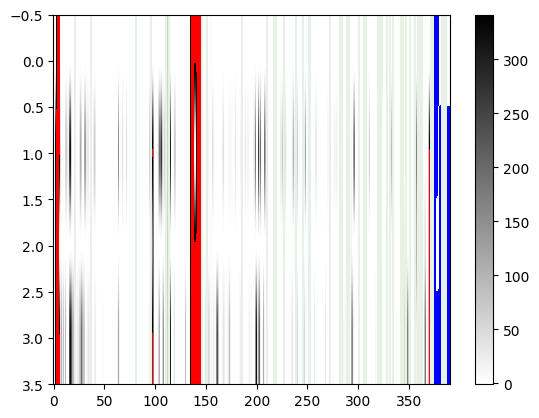

min: -1.0, max: 344.64819168687194
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_97_epoch


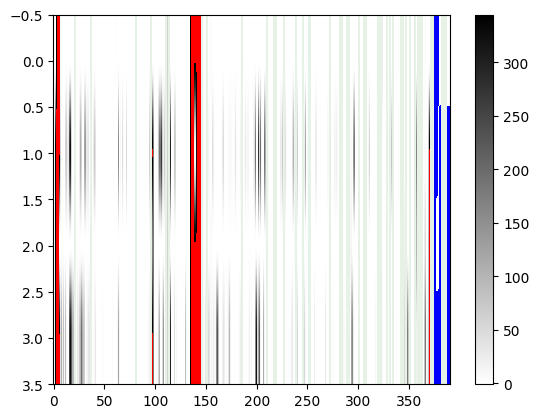

min: -1.0, max: 344.64819168687194
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_98_epoch


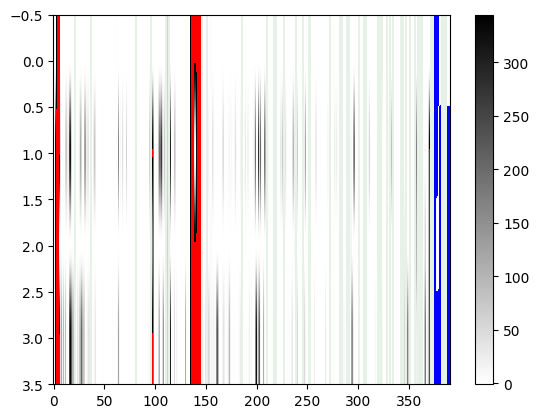

min: -1.0, max: 349.0149175633541
True
True
name: v2_RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}_{"mean":0,"std":0}_training_agent_99_epoch


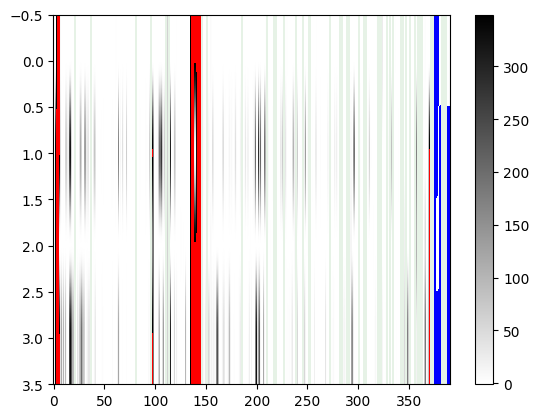

/tmp/ipykernel_27493/1209110859.py:81: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [65]:
from matplotlib.colors import LinearSegmentedColormap
import tqdm
import os
import imageio

cmap = mpl.colormaps.get_cmap('binary')  # viridis is the default colormap for imshow

cmap.set_under(color ='blue')  # Set the color for values below vmin to blue
cmap.set_over(color ='red')
cmap.set_bad(color ='green', alpha=0.1)

somegrid = 'v2' 
someghost = 'RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}' 
someotherghost = 'RandomGhost_{"index":1,"prob":{}}' 
somenoise = '{"mean":0,"std":0}'
someothernoise = '{"mean":0,"std":0}'

print(somegrid, someghost, somenoise)
print(f"len: {len(data[somegrid][someghost][somenoise])}")
idxs = sorted(range(len(name[somegrid][someghost][somenoise])), key=lambda x: int(name[somegrid][someghost][somenoise][x].split('_')[-2]))
evolution_game = np.asarray(data[somegrid][someghost][somenoise])[idxs]
idxs_o = sorted_indices = sorted(range(len(name[somegrid][someotherghost][someothernoise])), key=lambda x: int(name[somegrid][someotherghost][someothernoise][x].split('_')[-2]))
evolution_game_other = np.asarray(data[somegrid][someotherghost][someothernoise])[idxs_o]
action_pd_no_noise = pd.DataFrame(evolution_game[-1]).sort_index()
action_pd_noise = pd.DataFrame(evolution_game_other[-1]).sort_index()
all_columns = pd.merge(action_pd_no_noise.fillna(np.nan).astype(float), action_pd_noise.fillna(np.nan).astype(float), how="outer").columns
action_pd_no_noise_complete = pd.concat([action_pd_no_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_no_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
action_pd_noise_complete = pd.concat([action_pd_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
common_nan_mask = np.isnan(action_pd_no_noise_complete.values) & np.isnan(action_pd_noise_complete.values)
column_mask = np.all(common_nan_mask, axis=0)
masked_data_terminal = np.ma.masked_array(common_nan_mask, mask=np.repeat(column_mask.reshape(1,-1), 4, axis=0))
folder = '_trial_learnability_BoltzmannAgent_' + re.sub(r"_training_agent_\d+_epoch", "", np.asarray(name[somegrid][someghost][somenoise])[idxs][0])

for sortex_idx in range(100):
    #fig, ax = plt.subplots(1,1, figsize=(27,27))
    action_pd_no_noise = pd.DataFrame(evolution_game[sortex_idx]).sort_index()
    action_pd_noise = pd.DataFrame(evolution_game_other[sortex_idx]).sort_index()
    
    action_pd_no_noise_complete = pd.concat([action_pd_no_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_no_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    action_pd_noise_complete = pd.concat([action_pd_noise,pd.DataFrame(columns=list(set(all_columns) - set(action_pd_noise.columns)))]).fillna(np.nan).sort_index()[all_columns]
    common_nan_mask = np.isnan(action_pd_no_noise_complete.values) & np.isnan(action_pd_noise_complete.values)
    action_pd_noise_nan_mask = np.isnan(action_pd_noise_complete.values) & ~np.isnan(action_pd_no_noise_complete.values)
    action_pd_no_noise_nan_mask = np.isnan(action_pd_no_noise_complete.values) & ~np.isnan(action_pd_noise_complete.values)
    
    merge = pd.merge(action_pd_no_noise_complete, action_pd_noise_complete, how='outer')[all_columns]
    a = abs(merge.iloc[:4,:].to_numpy() - merge.iloc[4:,:].to_numpy())
    a[common_nan_mask] = 0
    min = np.nanmin(a) - 1
    max = np.nanmax(a) + 1
    print(f"min: {min}, max: {max}")
    print(np.any(action_pd_noise_nan_mask == True))
    print(np.any(action_pd_no_noise_nan_mask == True))
    if np.any(action_pd_noise_nan_mask == True):
        a[action_pd_noise_nan_mask] = np.nanmax(a) + 2
    if np.any(action_pd_no_noise_nan_mask == True):
        a[action_pd_no_noise_nan_mask] = np.nanmin(a) - 2
    # VISUALIZE TERMINAL STATES
    a[masked_data_terminal.mask] = np.nan
    plt.imshow(a, aspect="auto", cmap=cmap, vmin=min, vmax=max)
    plt.colorbar()
    
    subfolder = "imgs"
    print(f"name: {name[somegrid][someghost][somenoise][idxs[sortex_idx]]}")
    if not os.path.exists(f"{folder}/{subfolder}"):
        os.makedirs(f"{folder}/{subfolder}")
    plt.savefig(f"{folder}/{subfolder}/{name[somegrid][someghost][somenoise][idxs[sortex_idx]]}.png")
    plt.show()


# generate GIFS
import os
import imageio

def create_gif(input_folder, output_file, file_extension=".png", duration=1.0):
    images = []

    # Get file names and sort them based on the number of epochs
    idxs = sorted(range(len(name[somegrid][someghost][somenoise])), key=lambda x: int(name[somegrid][someghost][somenoise][x].split('_')[-2]))
    for filename in np.asarray(name[somegrid][someghost][somenoise])[idxs]:
        filepath = os.path.join(input_folder, filename + ".png")
        images.append(imageio.imread(filepath))

    # Save the images as a GIF with the specified duration
    imageio.mimsave(output_file, images, duration=duration)

# Example usage
folder = '_trial_learnability_BoltzmannAgent_' + re.sub(r"_training_agent_\d+_epoch", "", np.asarray(name[somegrid][someghost][noise])[idxs][0])
result = re.sub(r"_training_agent_\d+_epoch", "", np.asarray(name[somegrid][someghost][noise])[idxs][0])
subfolder = "imgs"
input_folder = f"{folder}/{subfolder}/"
output_file = f"{folder}/{subfolder}/{result}.gif"
create_gif(input_folder, output_file, duration=1.5)

In [30]:
column_mask = np.all(merge_common.iloc[:4,:], axis=0)
masked_data_terminal = np.ma.masked_array(merge_common.iloc[:4,:], mask=np.repeat(column_mask.reshape(1,-1), 4, axis=0))
merge_common.iloc[:4,:][~masked_data_terminal]

AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
def nanargmax_with_default(series):
    return 0 if series.isna().all() else np.nanargmax(series)

In [34]:
def nanargmax_with_default(series):
    if series.isna().all():
        return 0
    else:
        return np.nanargmax(series)

# Apply the custom function to each column of the DataFrame
max_indices = merge_common.iloc[:4,:].apply(nanargmax_with_default)

max_indices.values

array([3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 2,
       1, 0, 0, 2, 2, 2, 2, 3, 0, 3, 3, 3, 1, 1, 1, 3, 3, 0, 3, 1, 1, 0,
       1, 3, 0, 0, 1, 3, 3, 3, 0, 0, 1, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0, 2,
       2, 2, 2, 2, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 3,
       0, 3, 3, 0, 2, 0, 3, 3, 3, 2, 2, 1, 0, 1, 1, 0, 0, 2, 2, 0, 2, 2,
       0, 1, 3, 2, 3, 2, 1, 1, 2, 2, 1, 0, 1, 1, 1, 3, 2, 2, 0, 1, 2, 2,
       1, 1, 1, 3, 0, 0, 0, 0, 3, 2, 2, 2, 2, 1, 0, 2, 3, 2, 0, 3, 0, 0,
       3, 3, 3, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 1, 2, 1, 1, 0, 2, 0, 0,
       0, 1, 3, 3, 3, 1, 1, 0, 2, 3, 3, 0, 0, 1, 3, 3, 1, 1, 3, 3, 0, 1,
       3, 2, 2, 1, 2, 0, 0, 2, 3, 0, 0, 3, 3, 1, 1, 3, 2, 3, 1, 2, 3, 0,
       1, 2, 2, 1, 0, 0, 1, 3, 0, 1, 2, 1, 1, 1, 3, 3, 1, 1, 0, 0, 3, 3,
       3, 3, 3, 3, 0, 3, 3, 2, 2, 0, 1, 0, 3, 0, 3, 0, 0, 2, 3, 1, 1, 0,
       2, 0, 3, 0, 1, 1, 3, 2, 0, 2, 0, 3, 1, 0, 1, 3, 3, 3, 3, 0, 2, 3,
       3, 3, 2, 0, 3, 0, 0, 0, 1, 1, 1, 0, 3, 3, 0,

In [29]:
!pip install imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 2.3 MB/s eta 0:00:000:00:01


In [2]:
grid=list(data.keys())[1]
ghost=list(data[grid].keys())[1]
nois_df = pd.DataFrame(data[grid][ghost], index=name[grid][ghost])

In [3]:
color_maps=['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
             'piyg', 'plasma', 'plotly4', 'portland', 'prgn', 'pubu', 'pubugn',
             'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
             'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
             'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
             'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
             'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
             'ylorrd']

In [5]:
cmp = 'algae'
def correlation_heatmap(y_cols, x_cols, full_data):
    '''
    Uses scipy.stats.spearmanr function
    Params:
    y_cols, x_cols: sets of column titles (strings)
    full_data: pandas dataframe that includes all columns listed in y_cols, x_cols
    Returns:
    corr: Spearman correlation coefficient matrix (y_cols = rows, x_cols = cols of matrix)
    fig_corr: annotated plotly heatmap of coefficients
    p: Spearman p-value matrix
    fig_p: annotated plotly heatmap of p-values
    '''
    cols = y_cols+x_cols
    all_correlations = scipy.stats.spearmanr(full_data[cols], nan_policy='omit')
    corr = all_correlations.statistic[:len(y_cols), -len(x_cols):]
    corr = pd.DataFrame(corr)
    corr.columns = x_cols
    corr.index = y_cols

    p = all_correlations.pvalue[:len(y_cols), -len(x_cols):]
    p = pd.DataFrame(p)
    p.columns = x_cols
    p.index = y_cols
    
    fig_corr = px.imshow(corr, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_r2 = px.imshow(corr**2, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_p = px.imshow(p, text_auto=True, aspect='auto', color_continuous_scale='gray_r')

    return corr, fig_corr, p, fig_p, fig_r2

In [6]:
def correlation(df_final):
    corr, fig_corr, p, fig_p, fig_r2 = correlation_heatmap(col_1, col_2, df_final)
    fig_corr.show()
    fig_p.show()
    fig_r2.show()
    return corr, fig_corr, p, fig_p, fig_r2

In [15]:
import numpy as np

np.nan -np.nan

nan

In [45]:
list(data[grid].keys())[2]

'RandomGhost_{"index":1,"prob":{}}'

In [23]:
data.keys()

dict_keys(['v2', 'v4', 'v3'])

In [29]:
grid1=list(data.keys())[0]
ghost1=list(data[grid].keys())[0]
grid2=list(data.keys())[0]
ghost2=list(data[grid].keys())[2]
f"grid: {grid1} w ghost {ghost1}, grid: {grid2} w ghost {ghost2}"

'grid: v2 w ghost DirectionalGhost_{"index":1,"prob":0.6}, grid: v2 w ghost RandomGhost_{"index":1,"prob":{}}'

grid: v2 w ghost RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}, grid: v2 w ghost RandomGhost_{"index":1,"prob":{}}


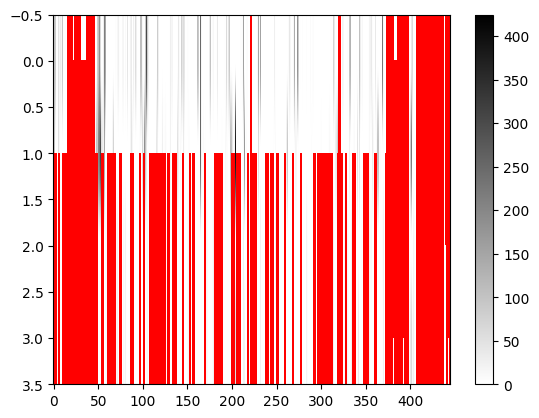

In [52]:
grid1=list(data.keys())[0]
ghost1=list(data[grid].keys())[-1]
grid2=list(data.keys())[2]
ghost2=list(data[grid].keys())[2]

name_ = f"grid: {grid1} w ghost {ghost1}, grid: {grid2} w ghost {ghost2}"
print(name_)
action_pd_no_noise = pd.DataFrame(data[grid1][ghost1],index=name[grid1][ghost1]).T.filter(like='{"mean":0,"std":0}').T.stack().apply(pd.Series).T.iloc[["0","1","2","4"]]
action_pd_no_noise.columns = action_pd_no_noise.columns.droplevel()
action_pd_noise = pd.DataFrame(data[grid2][ghost2],index=name[grid2][ghost2]).T.filter(like='{"mean":0,"std":0}').T.stack().apply(pd.Series).T.iloc[["0","1","2","4"]]
action_pd_noise.columns = action_pd_noise.columns.droplevel()
merge = pd.merge(action_pd_no_noise, action_pd_noise, how='outer')
cmap = mpl.colormaps.get_cmap('binary')  # viridis is the default colormap for imshow
cmap.set_bad(color='red')
plt.imshow(np.where(np.isnan(merge.iloc[:4,:].to_numpy()) & np.isnan(merge.iloc[4:,:].to_numpy()), 0, abs(merge.iloc[:4,:].to_numpy() - merge.iloc[4:,:].to_numpy())), aspect="auto", cmap=cmap)
plt.colorbar()
plt.savefig(f"img/{name_}.png")

In [56]:
action_pd_noise.shape, action_pd_no_noise.shape

((4, 430), (4, 431))

In [57]:
name.keys()

dict_keys(['v2', 'v4', 'v3'])

In [58]:
name['v2']['RandomGhost_{"index":1,"prob":{}}']

['{"index":1,"prob":{}}_{"mean":0,"std":0.1}',
 '{"index":1,"prob":{}}_{"mean":0,"std":0}']

exploring grid: v2 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise
exploring grid: v2 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise
exploring grid: v2 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise
exploring grid: v2 w/ ghost RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}, noise-no_noise
exploring grid: v4 w/ ghost RandomGhostTeleportingNearWalls_{"index":1,"prob":{}}, noise-no_noise
exploring grid: v4 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise
exploring grid: v4 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise
exploring grid: v4 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise
exploring grid: v3 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise
exploring grid: v3 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise
exploring grid: v3 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise
exploring grid: v3 w/ ghost RandomGhostTeleportingNearWalls_{"inde

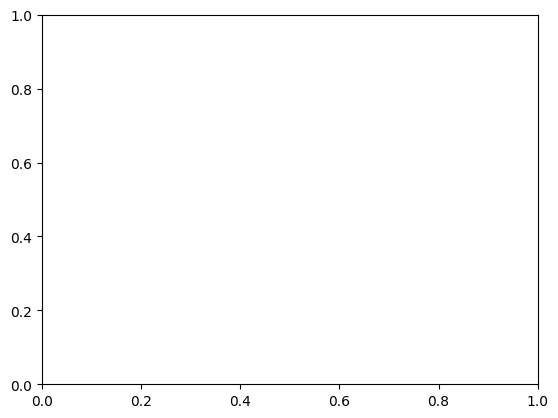

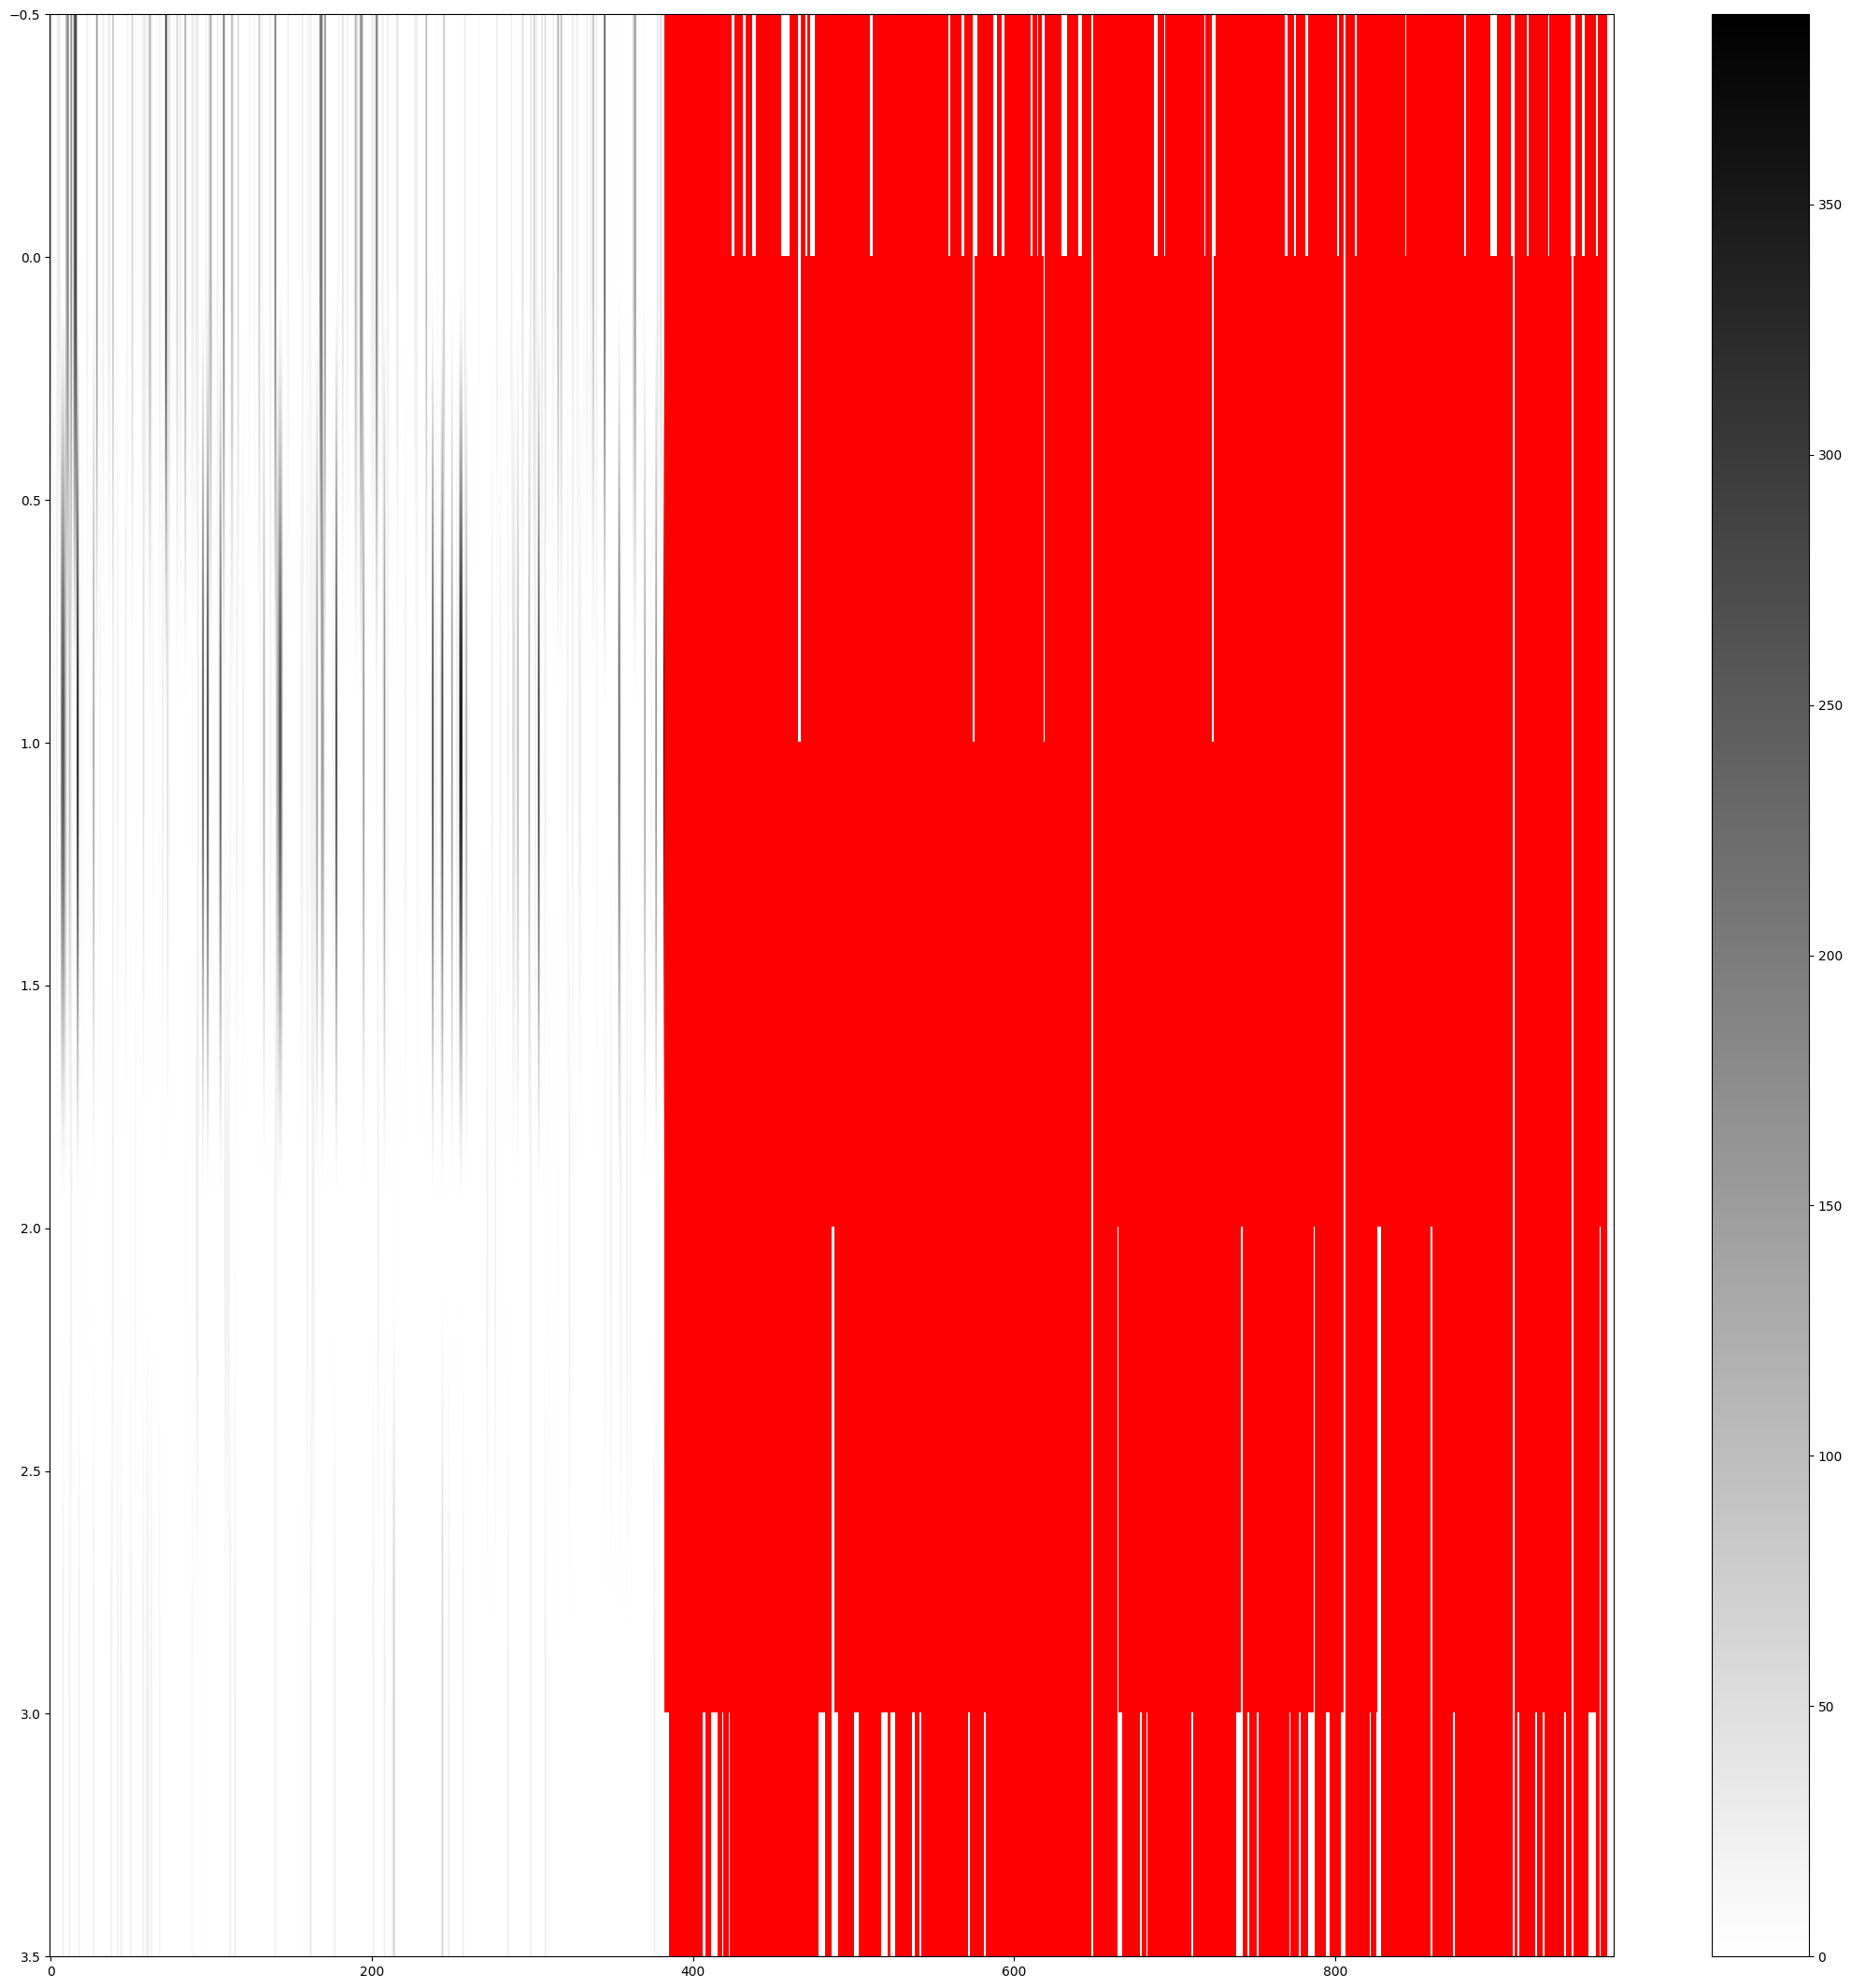

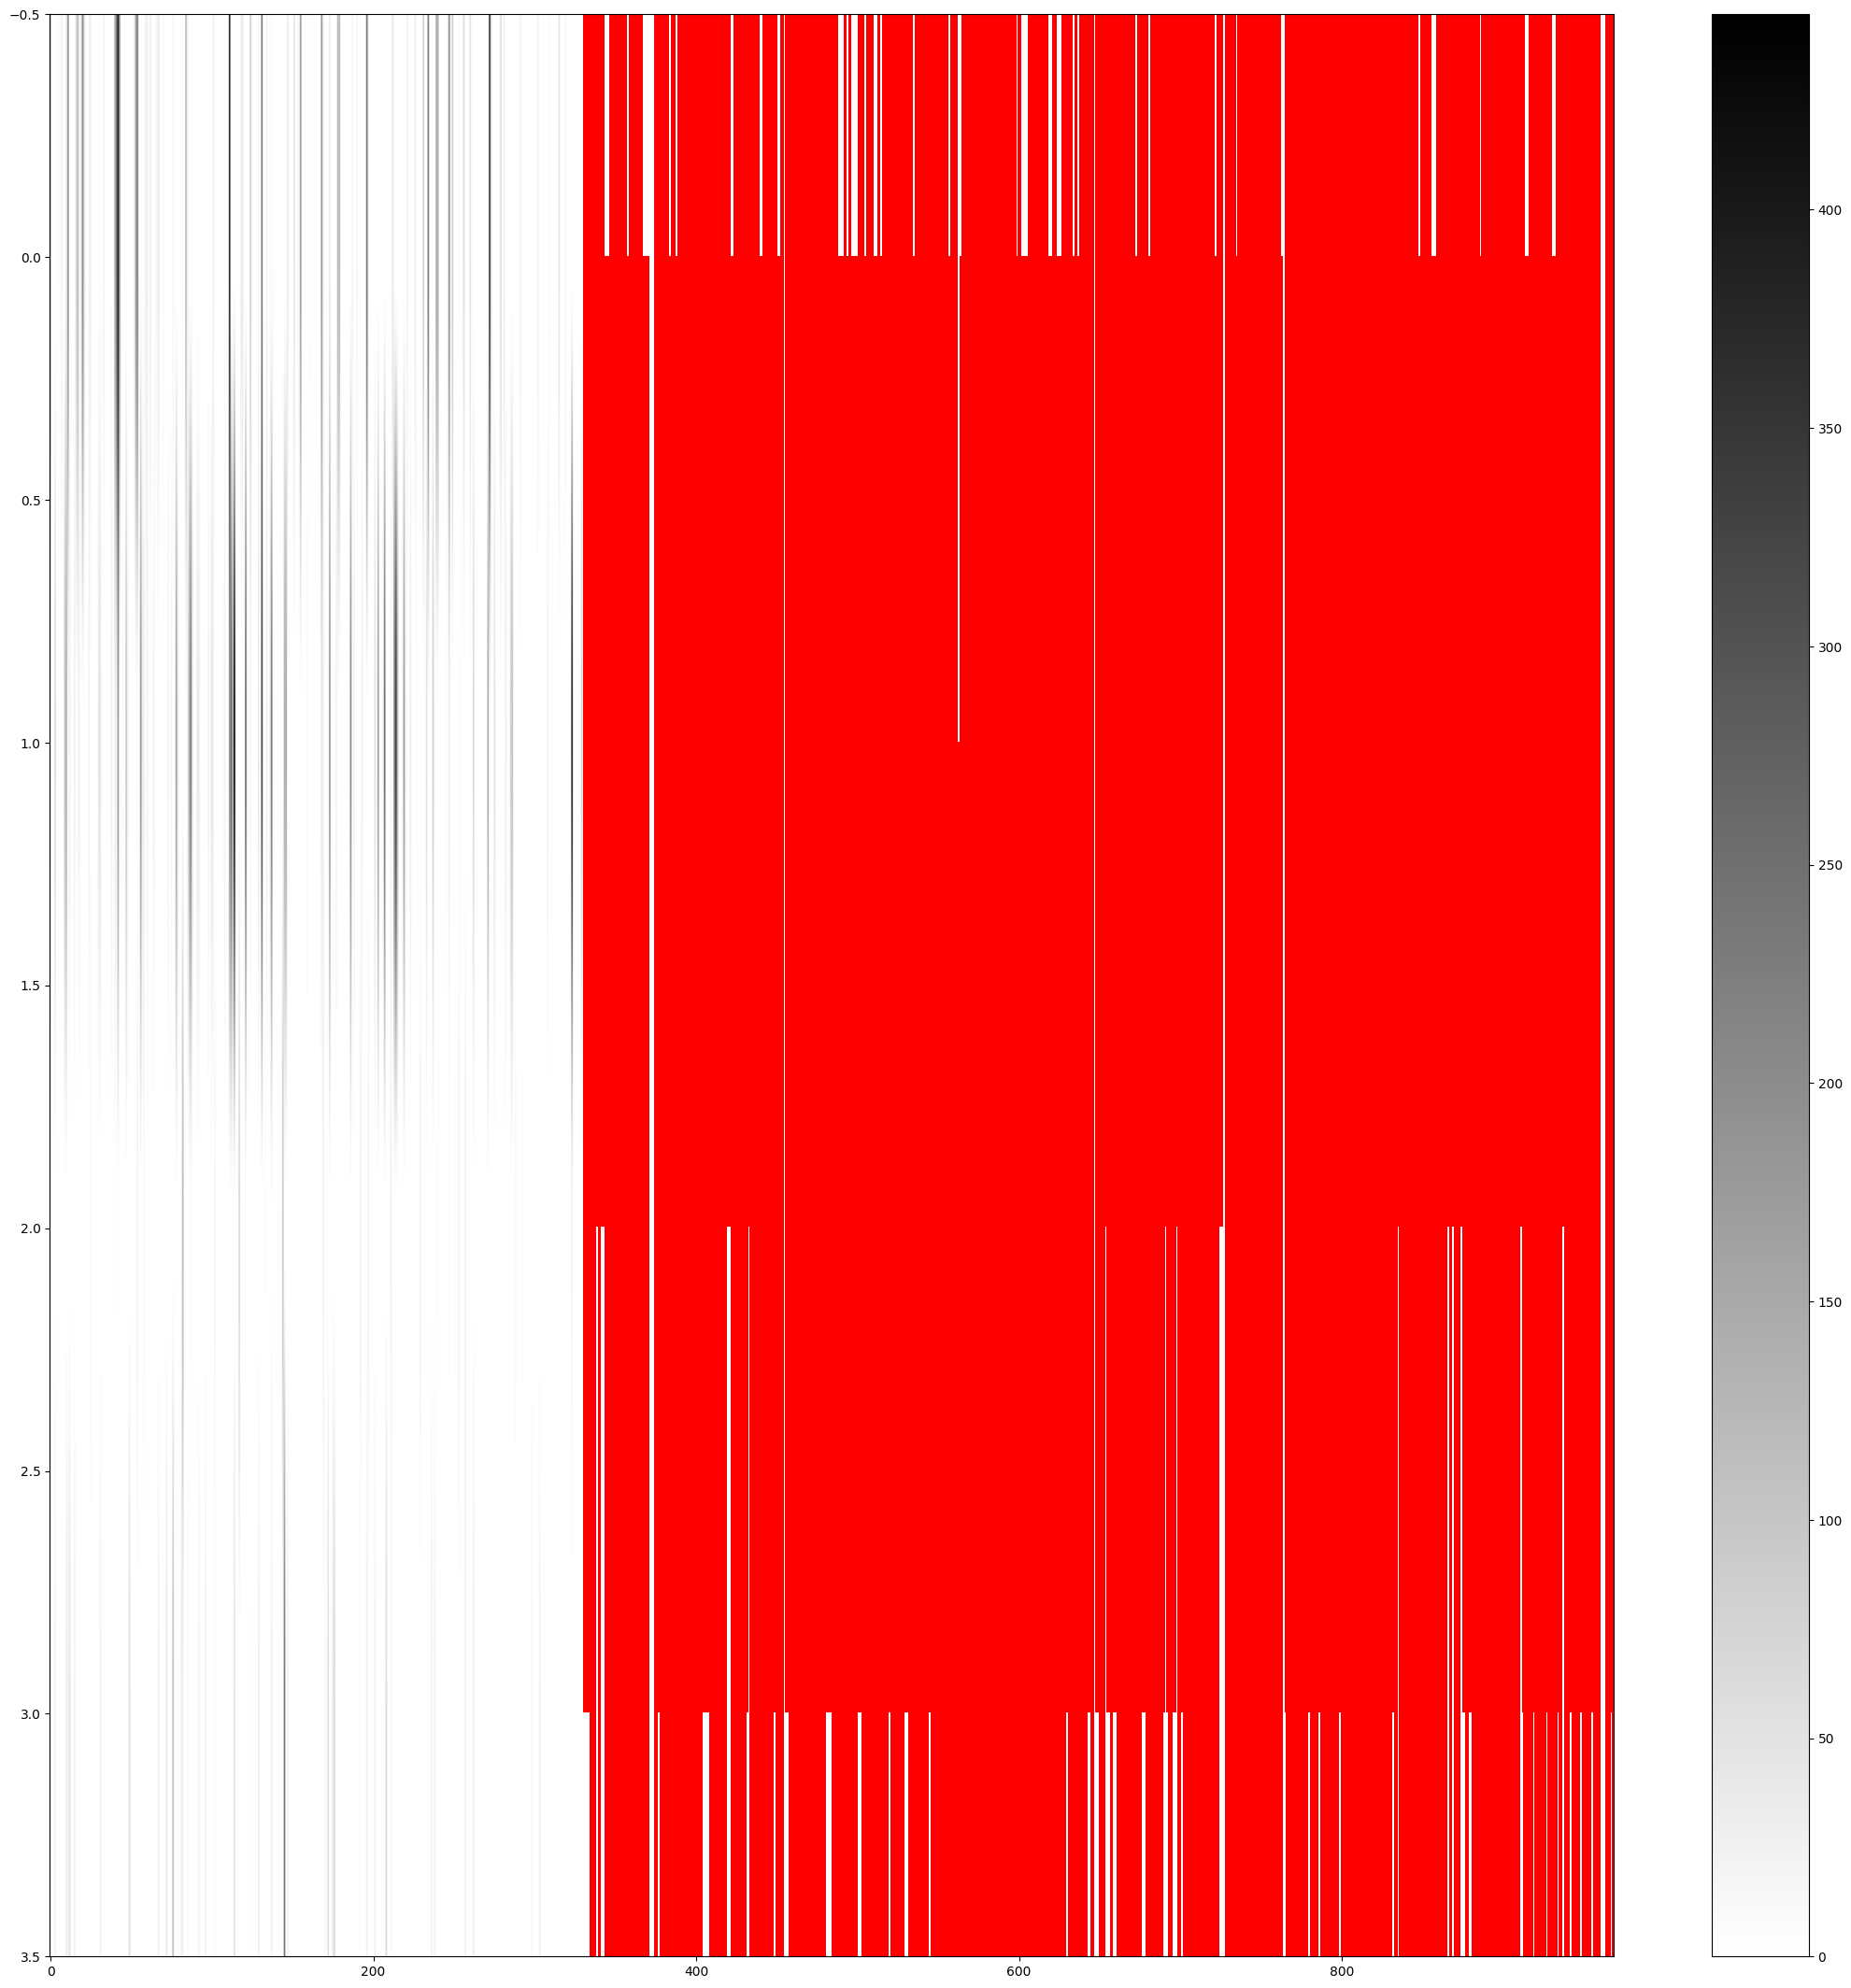

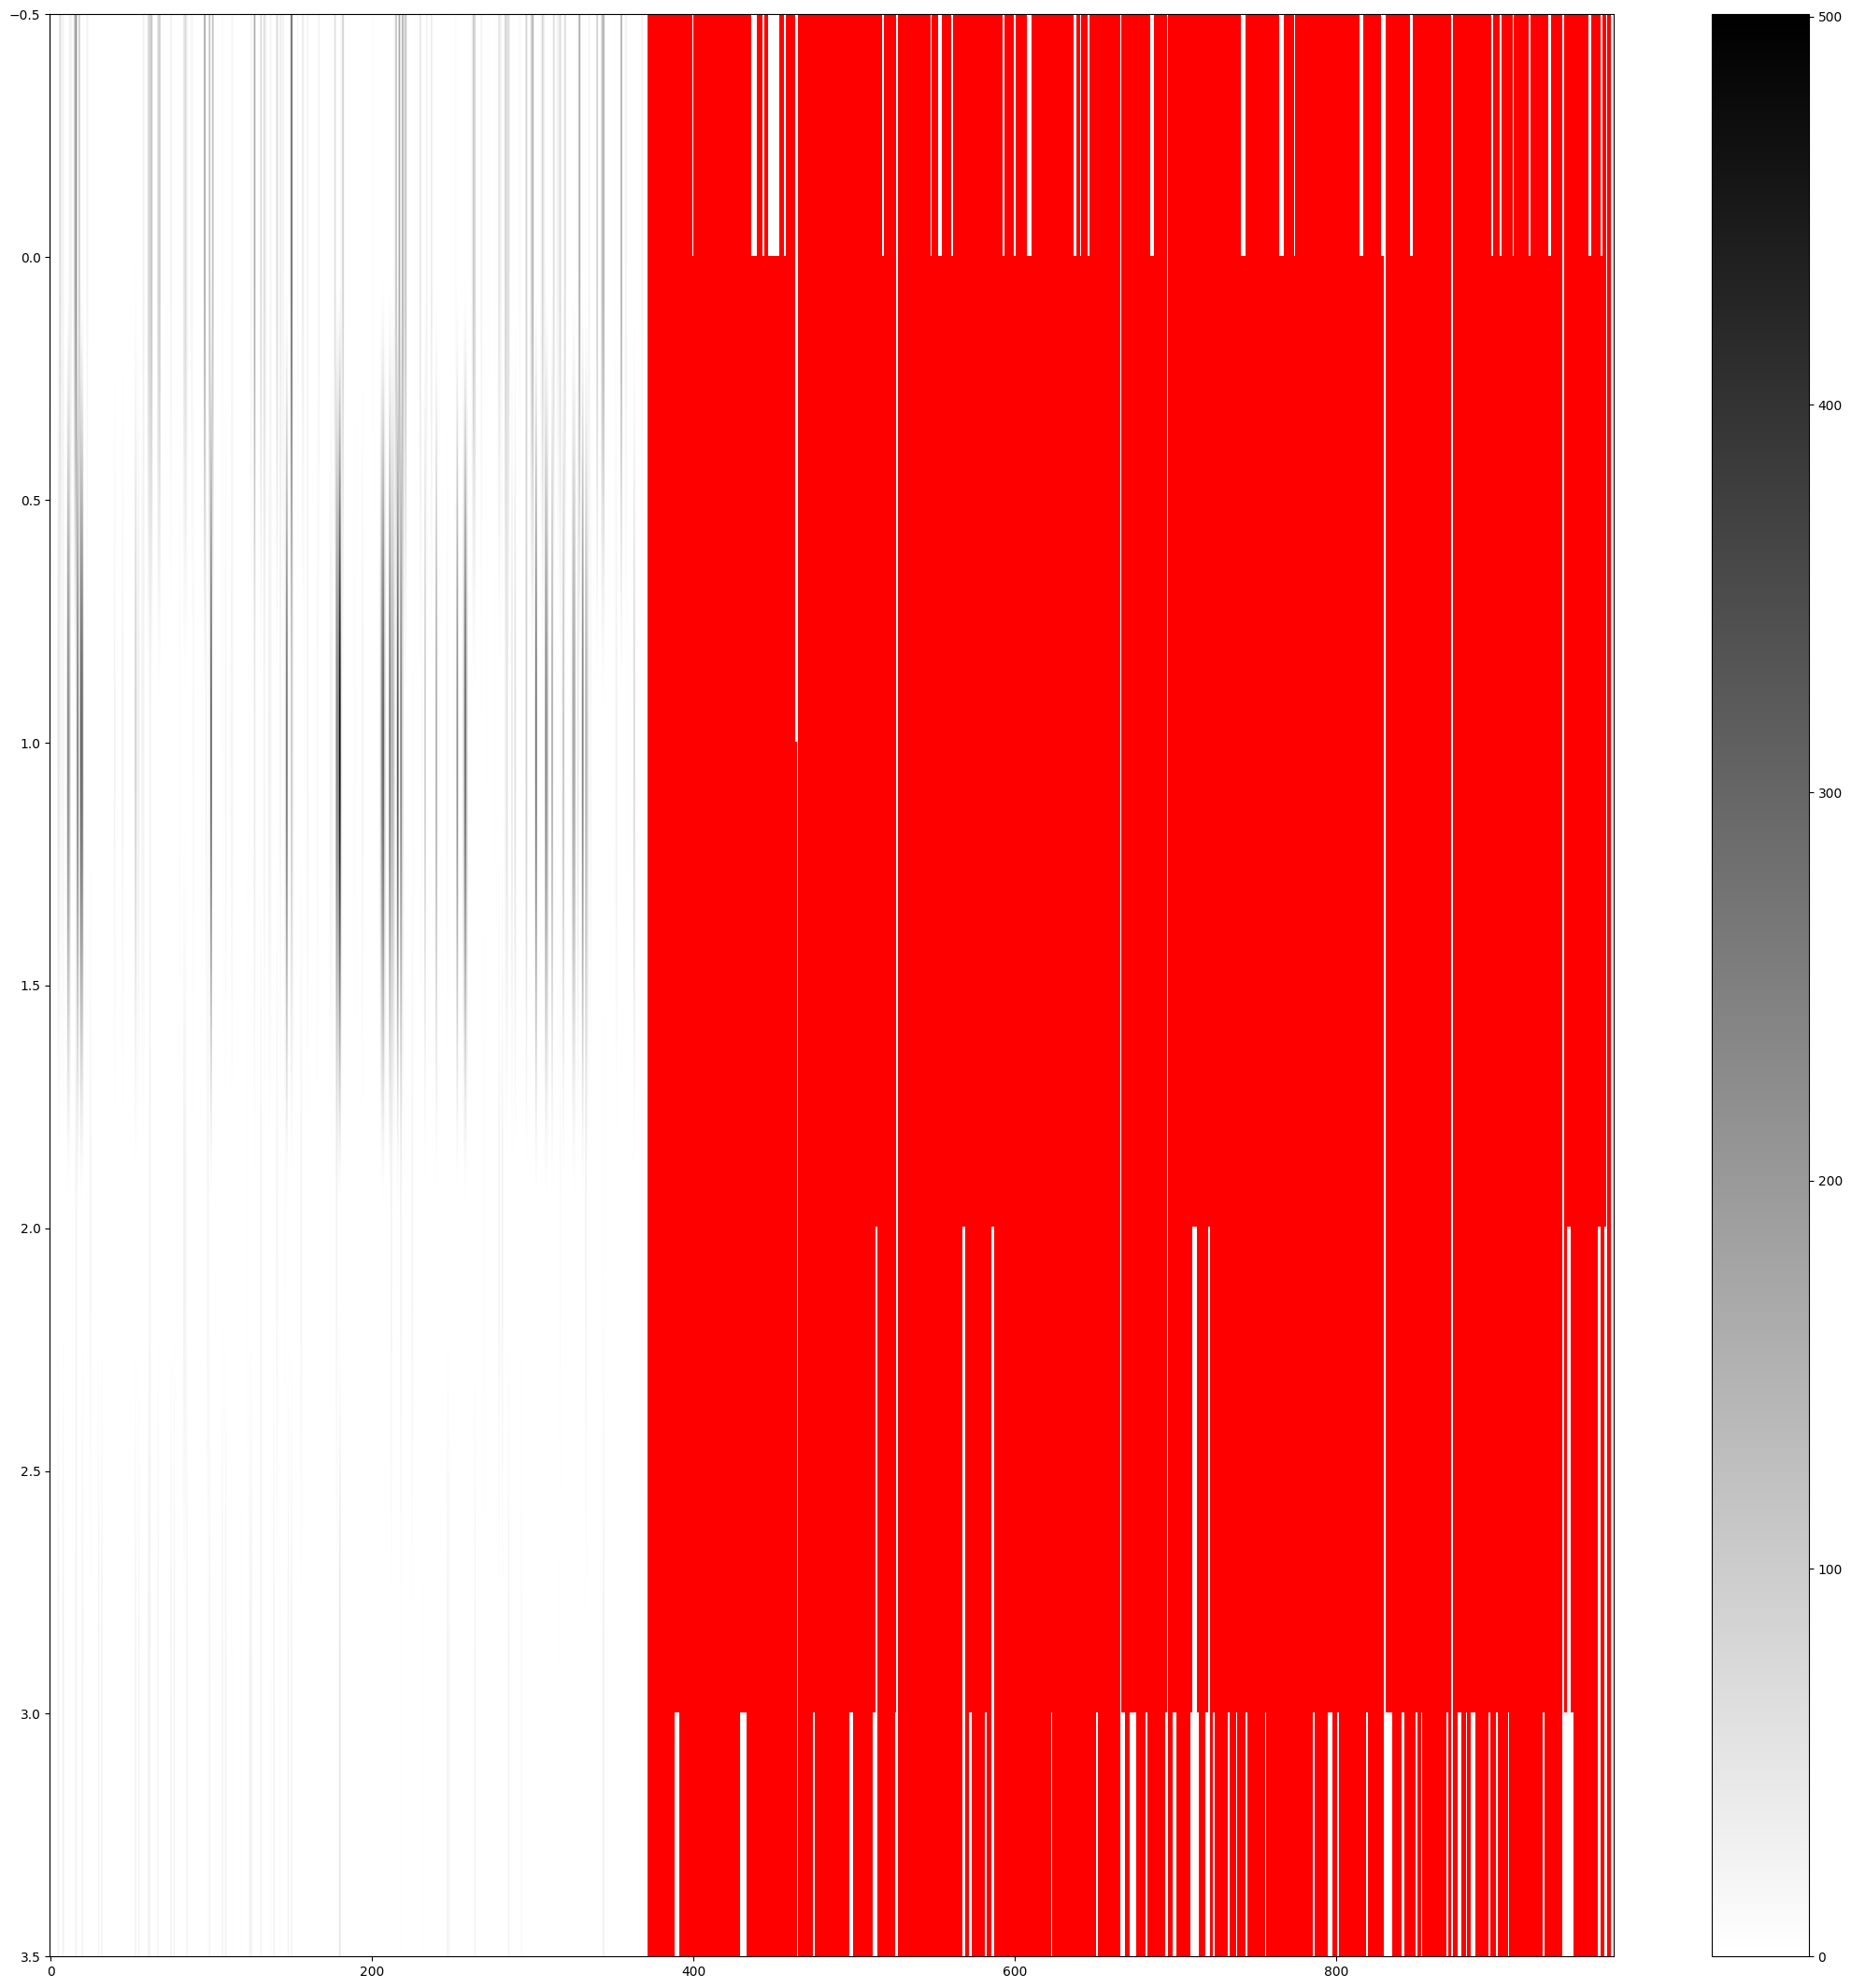

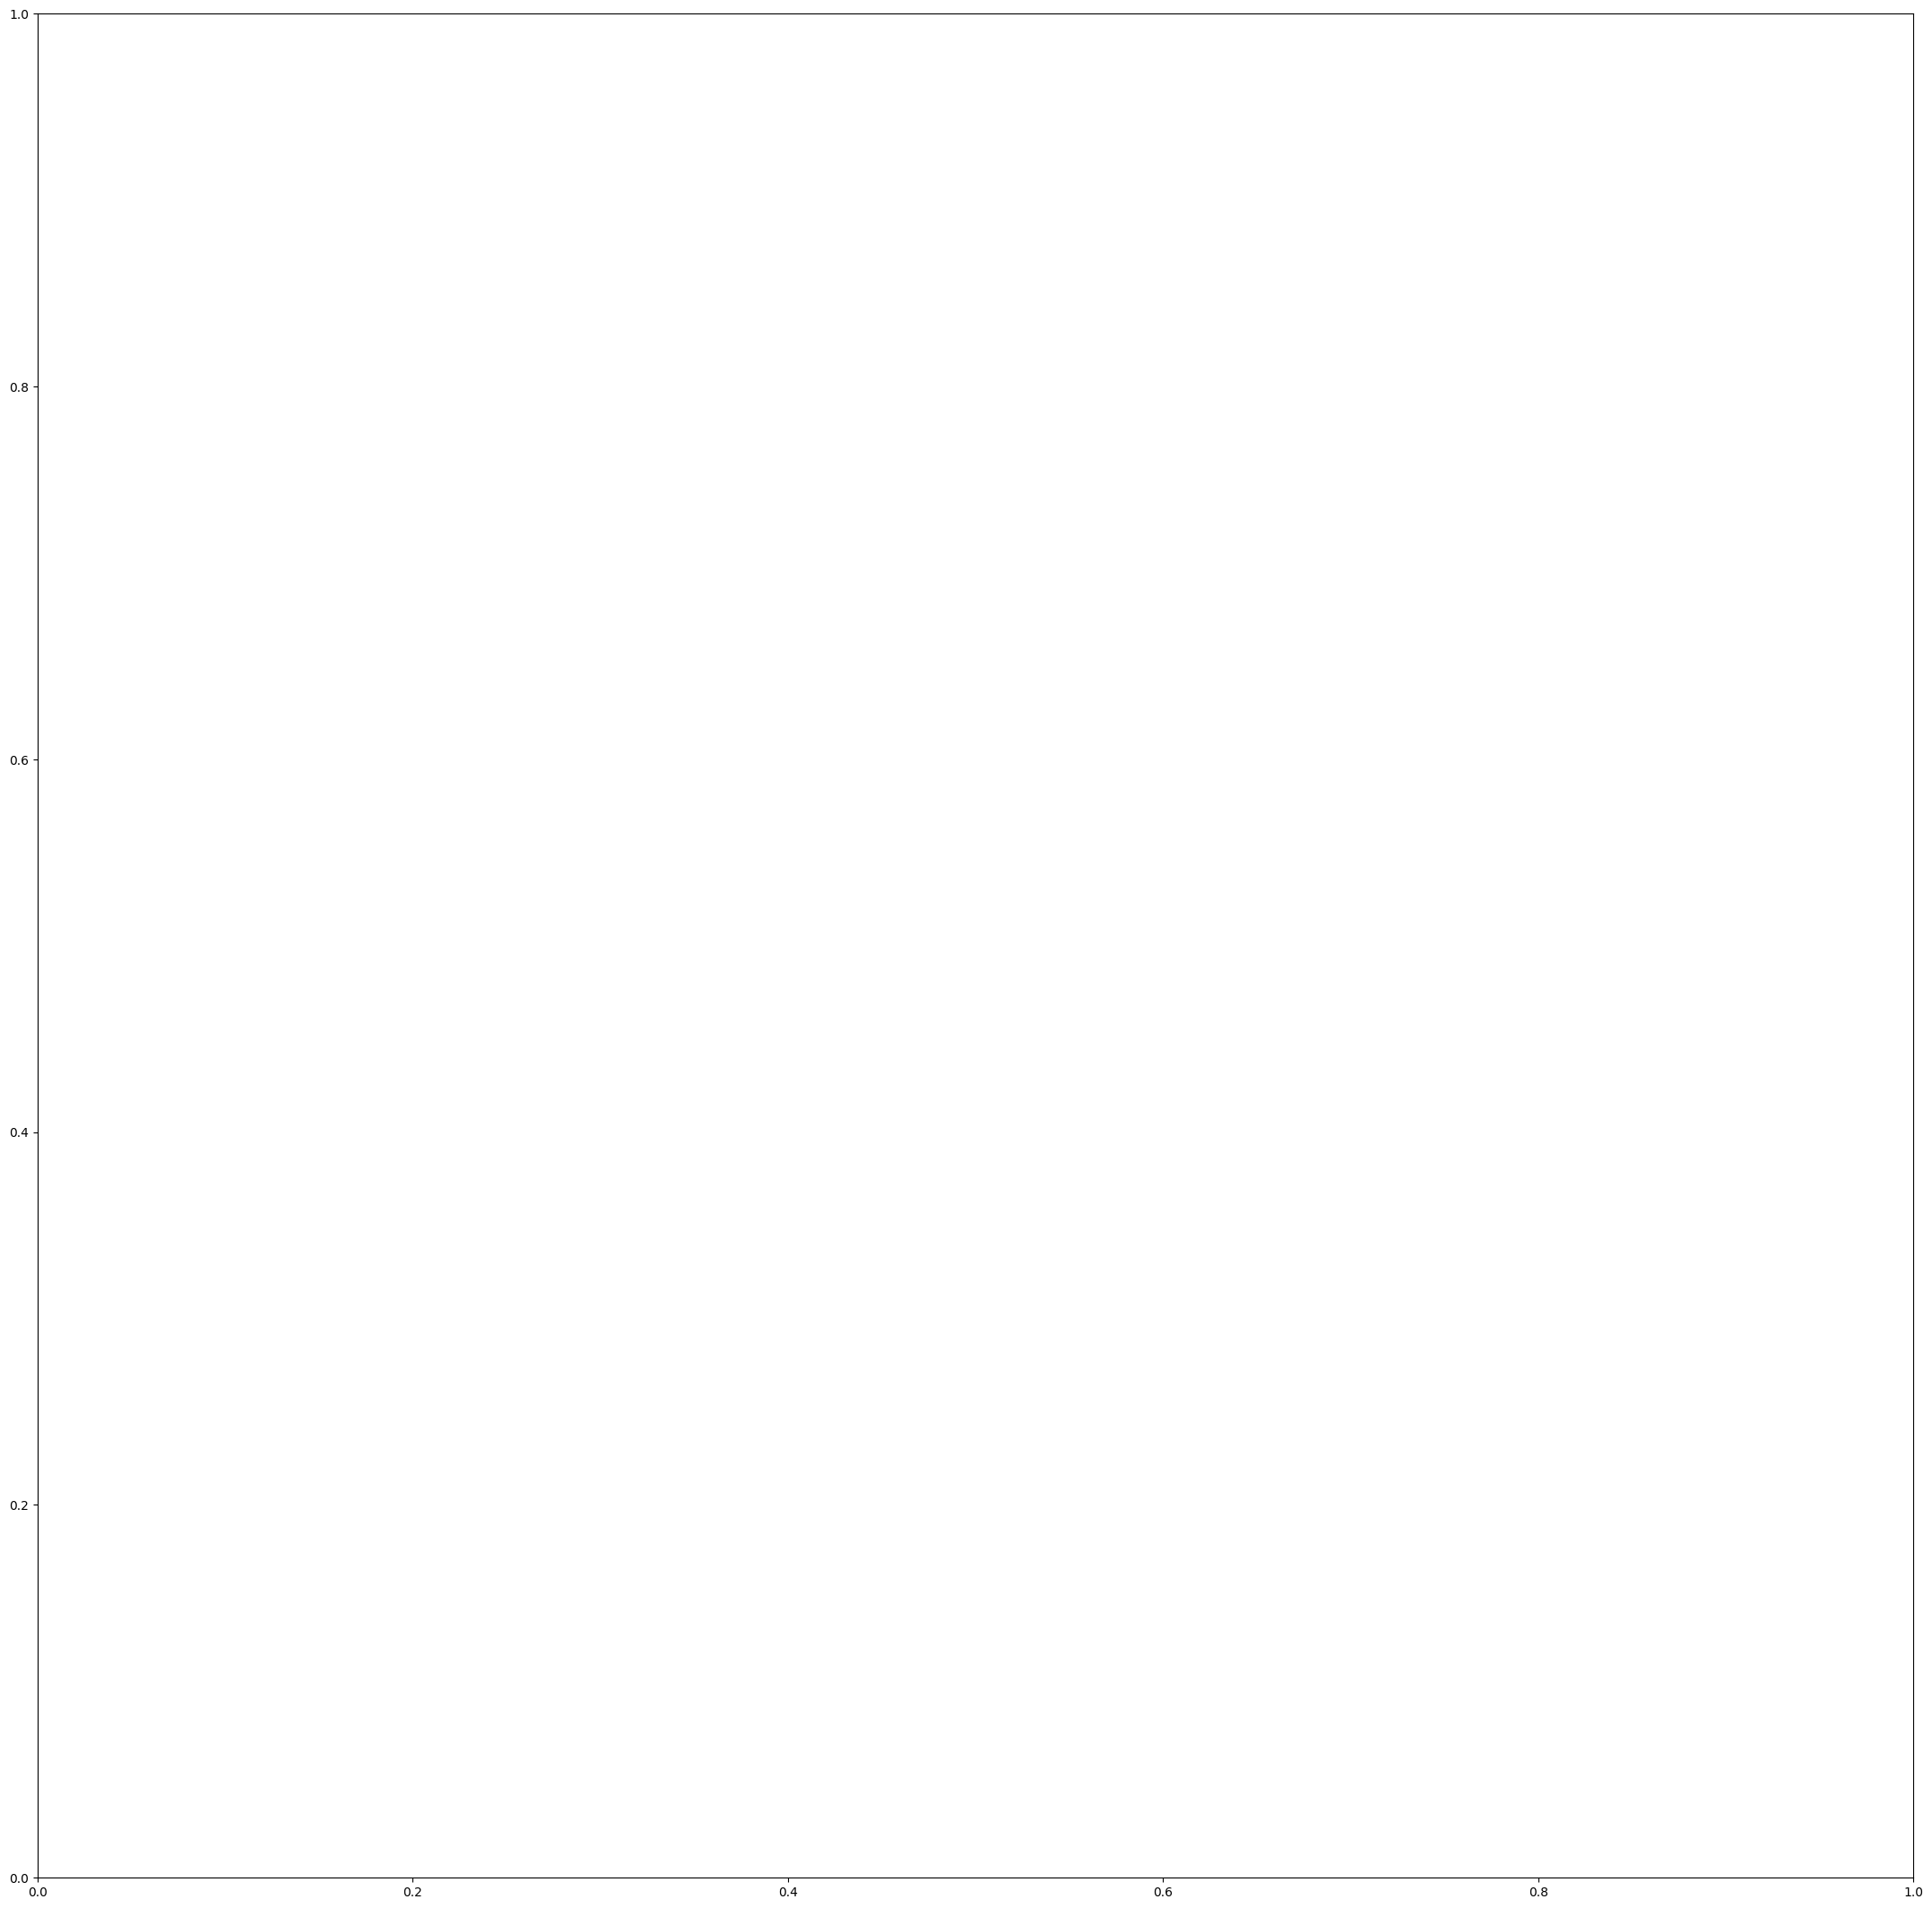

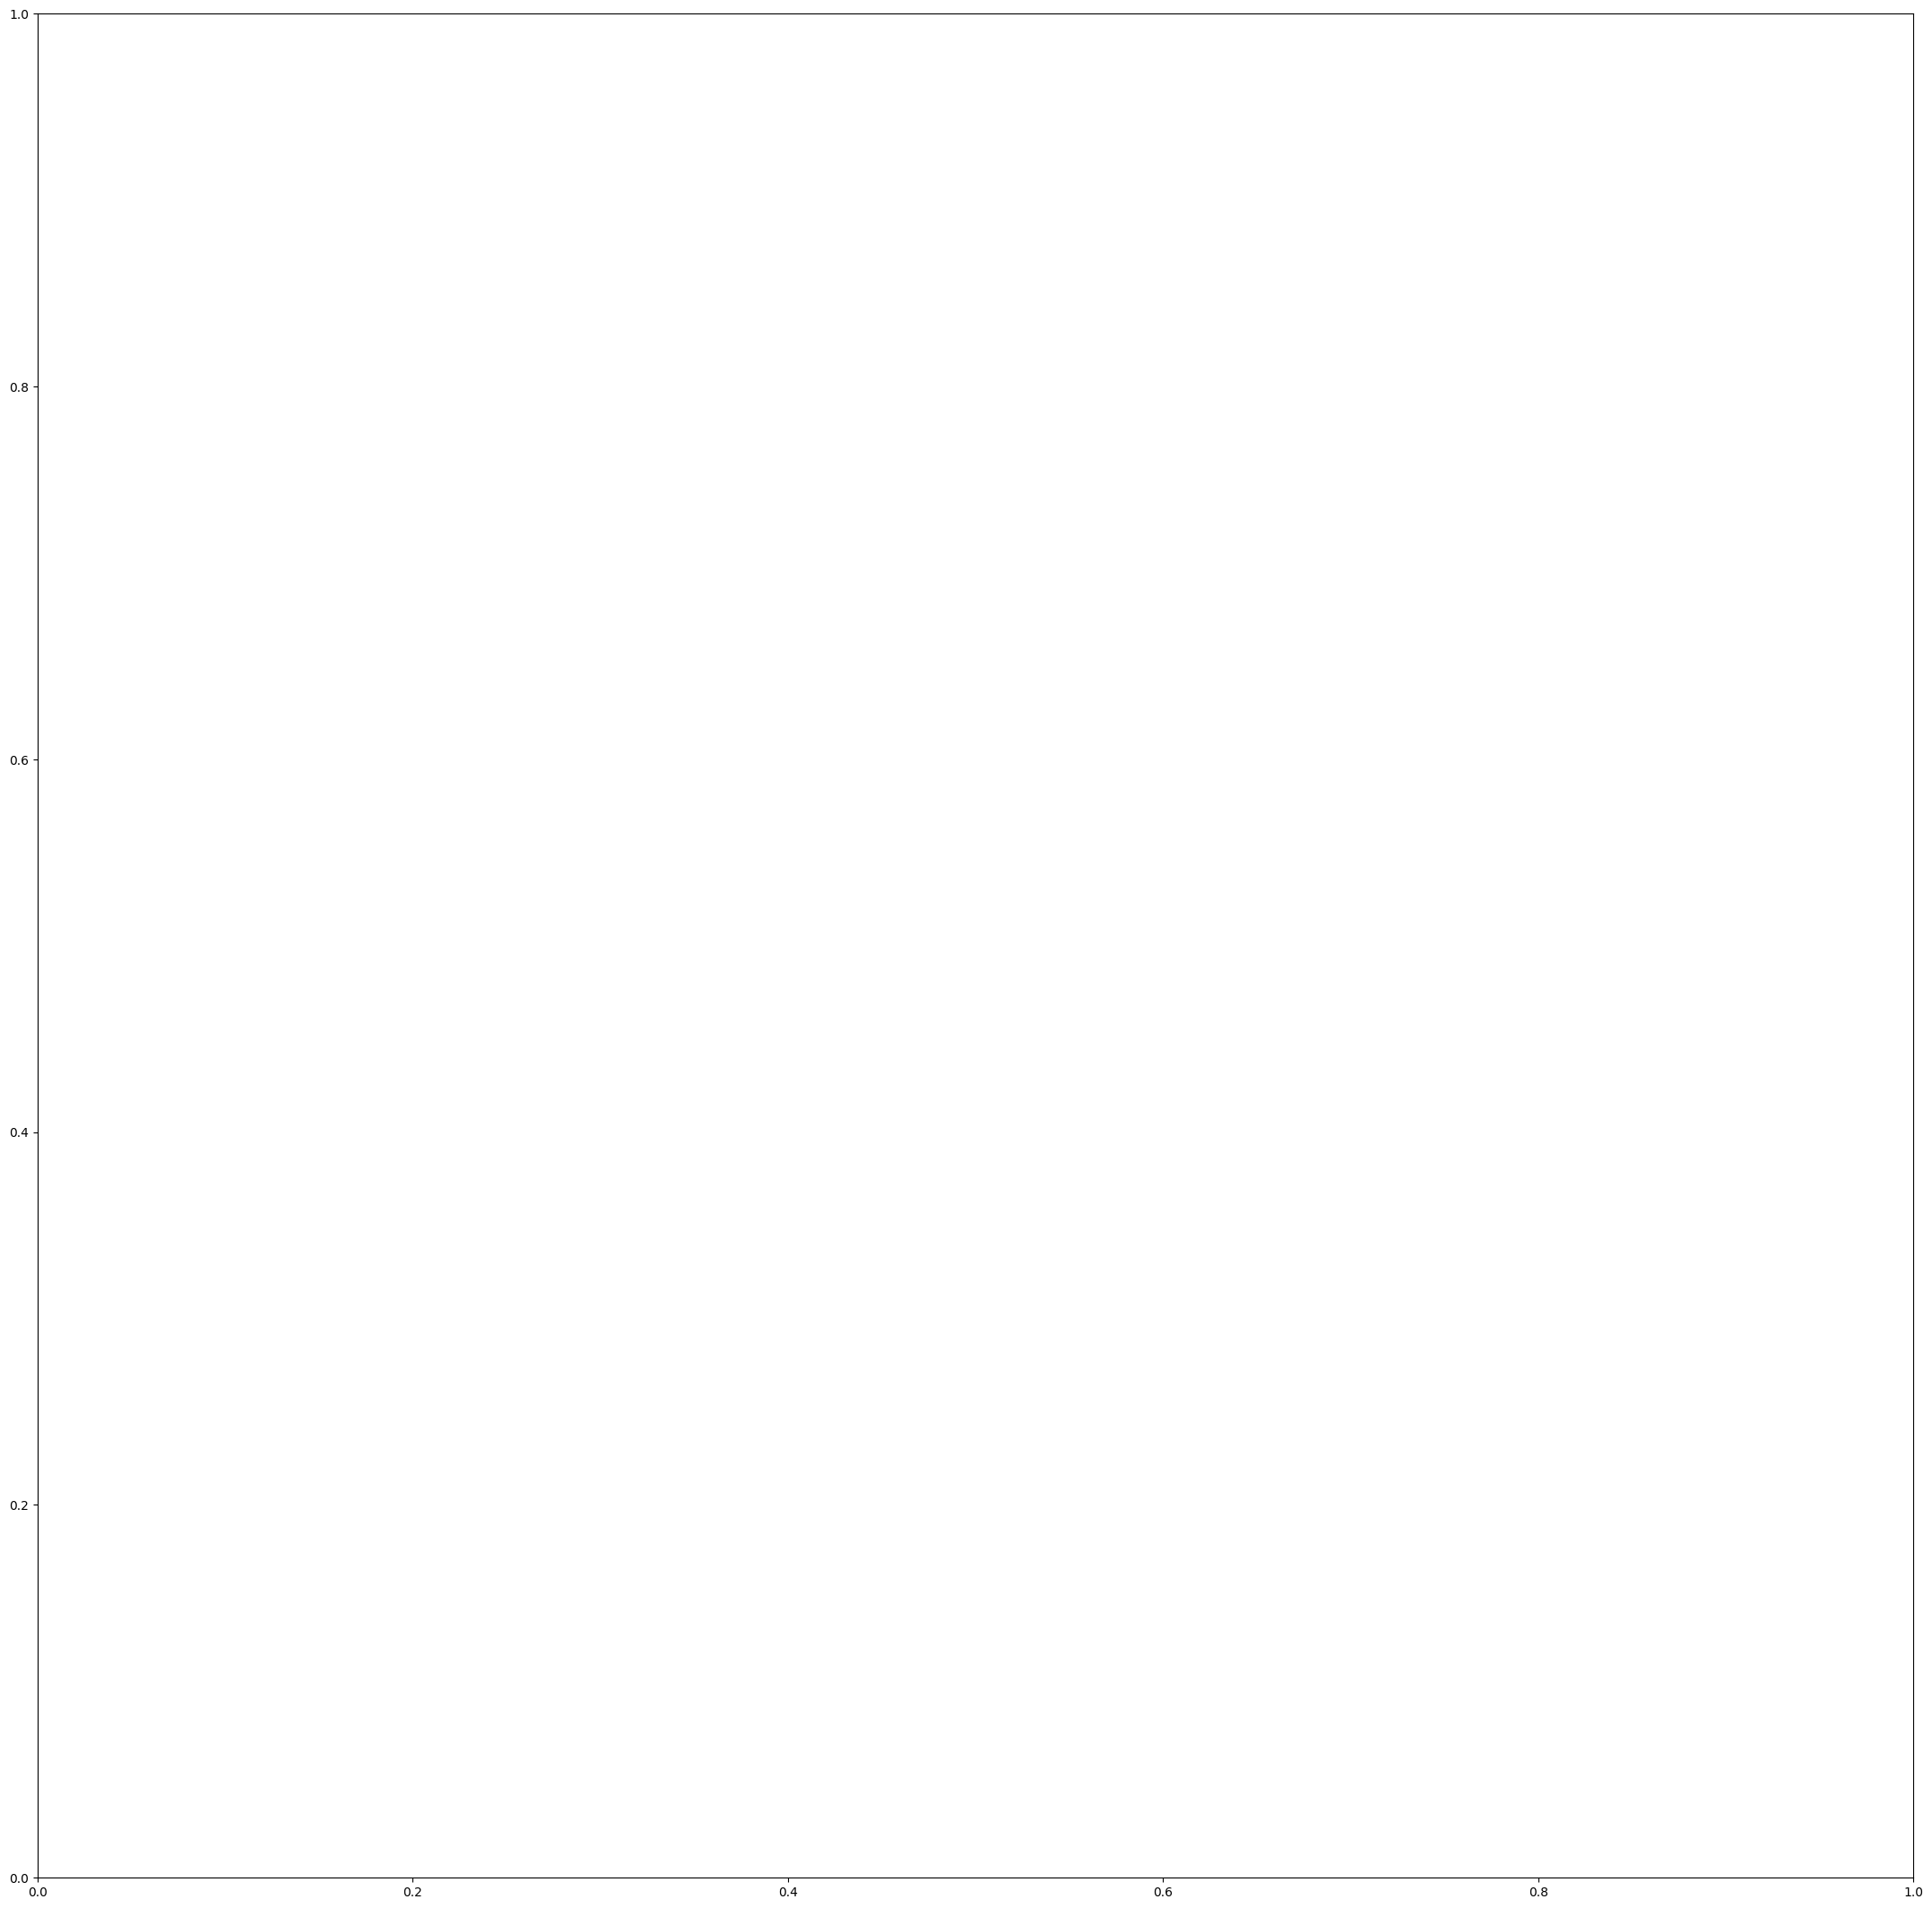

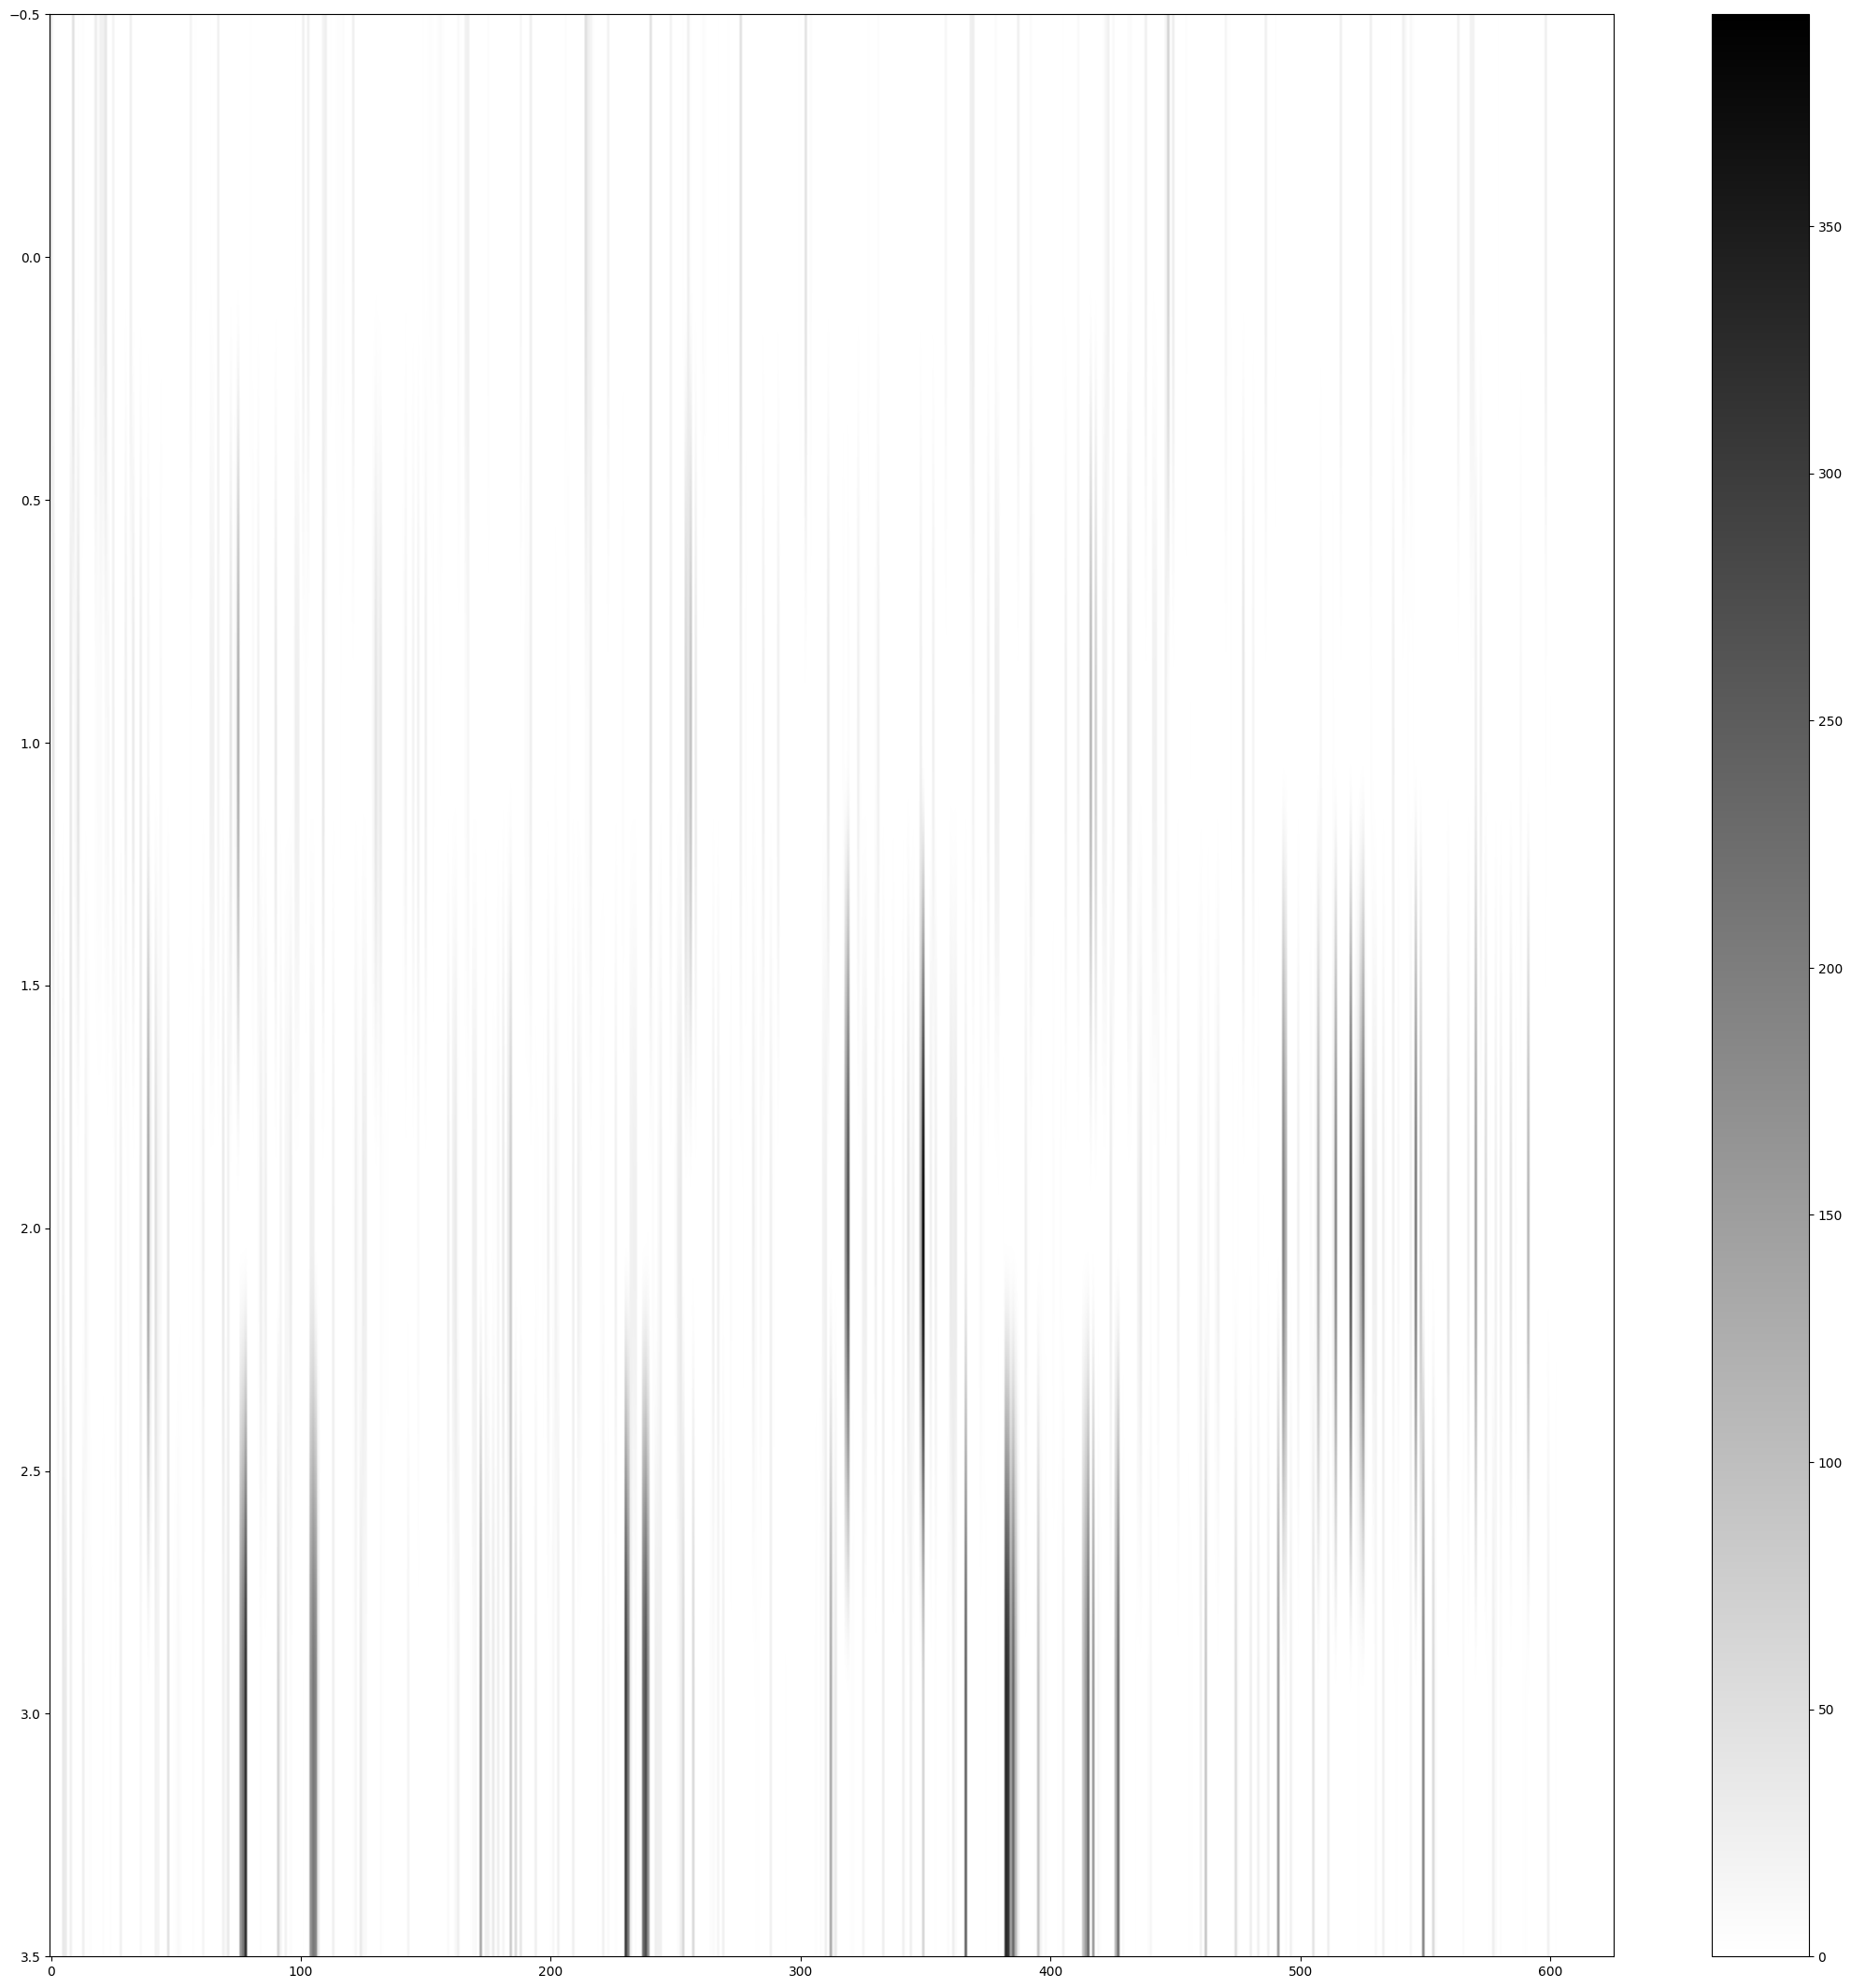

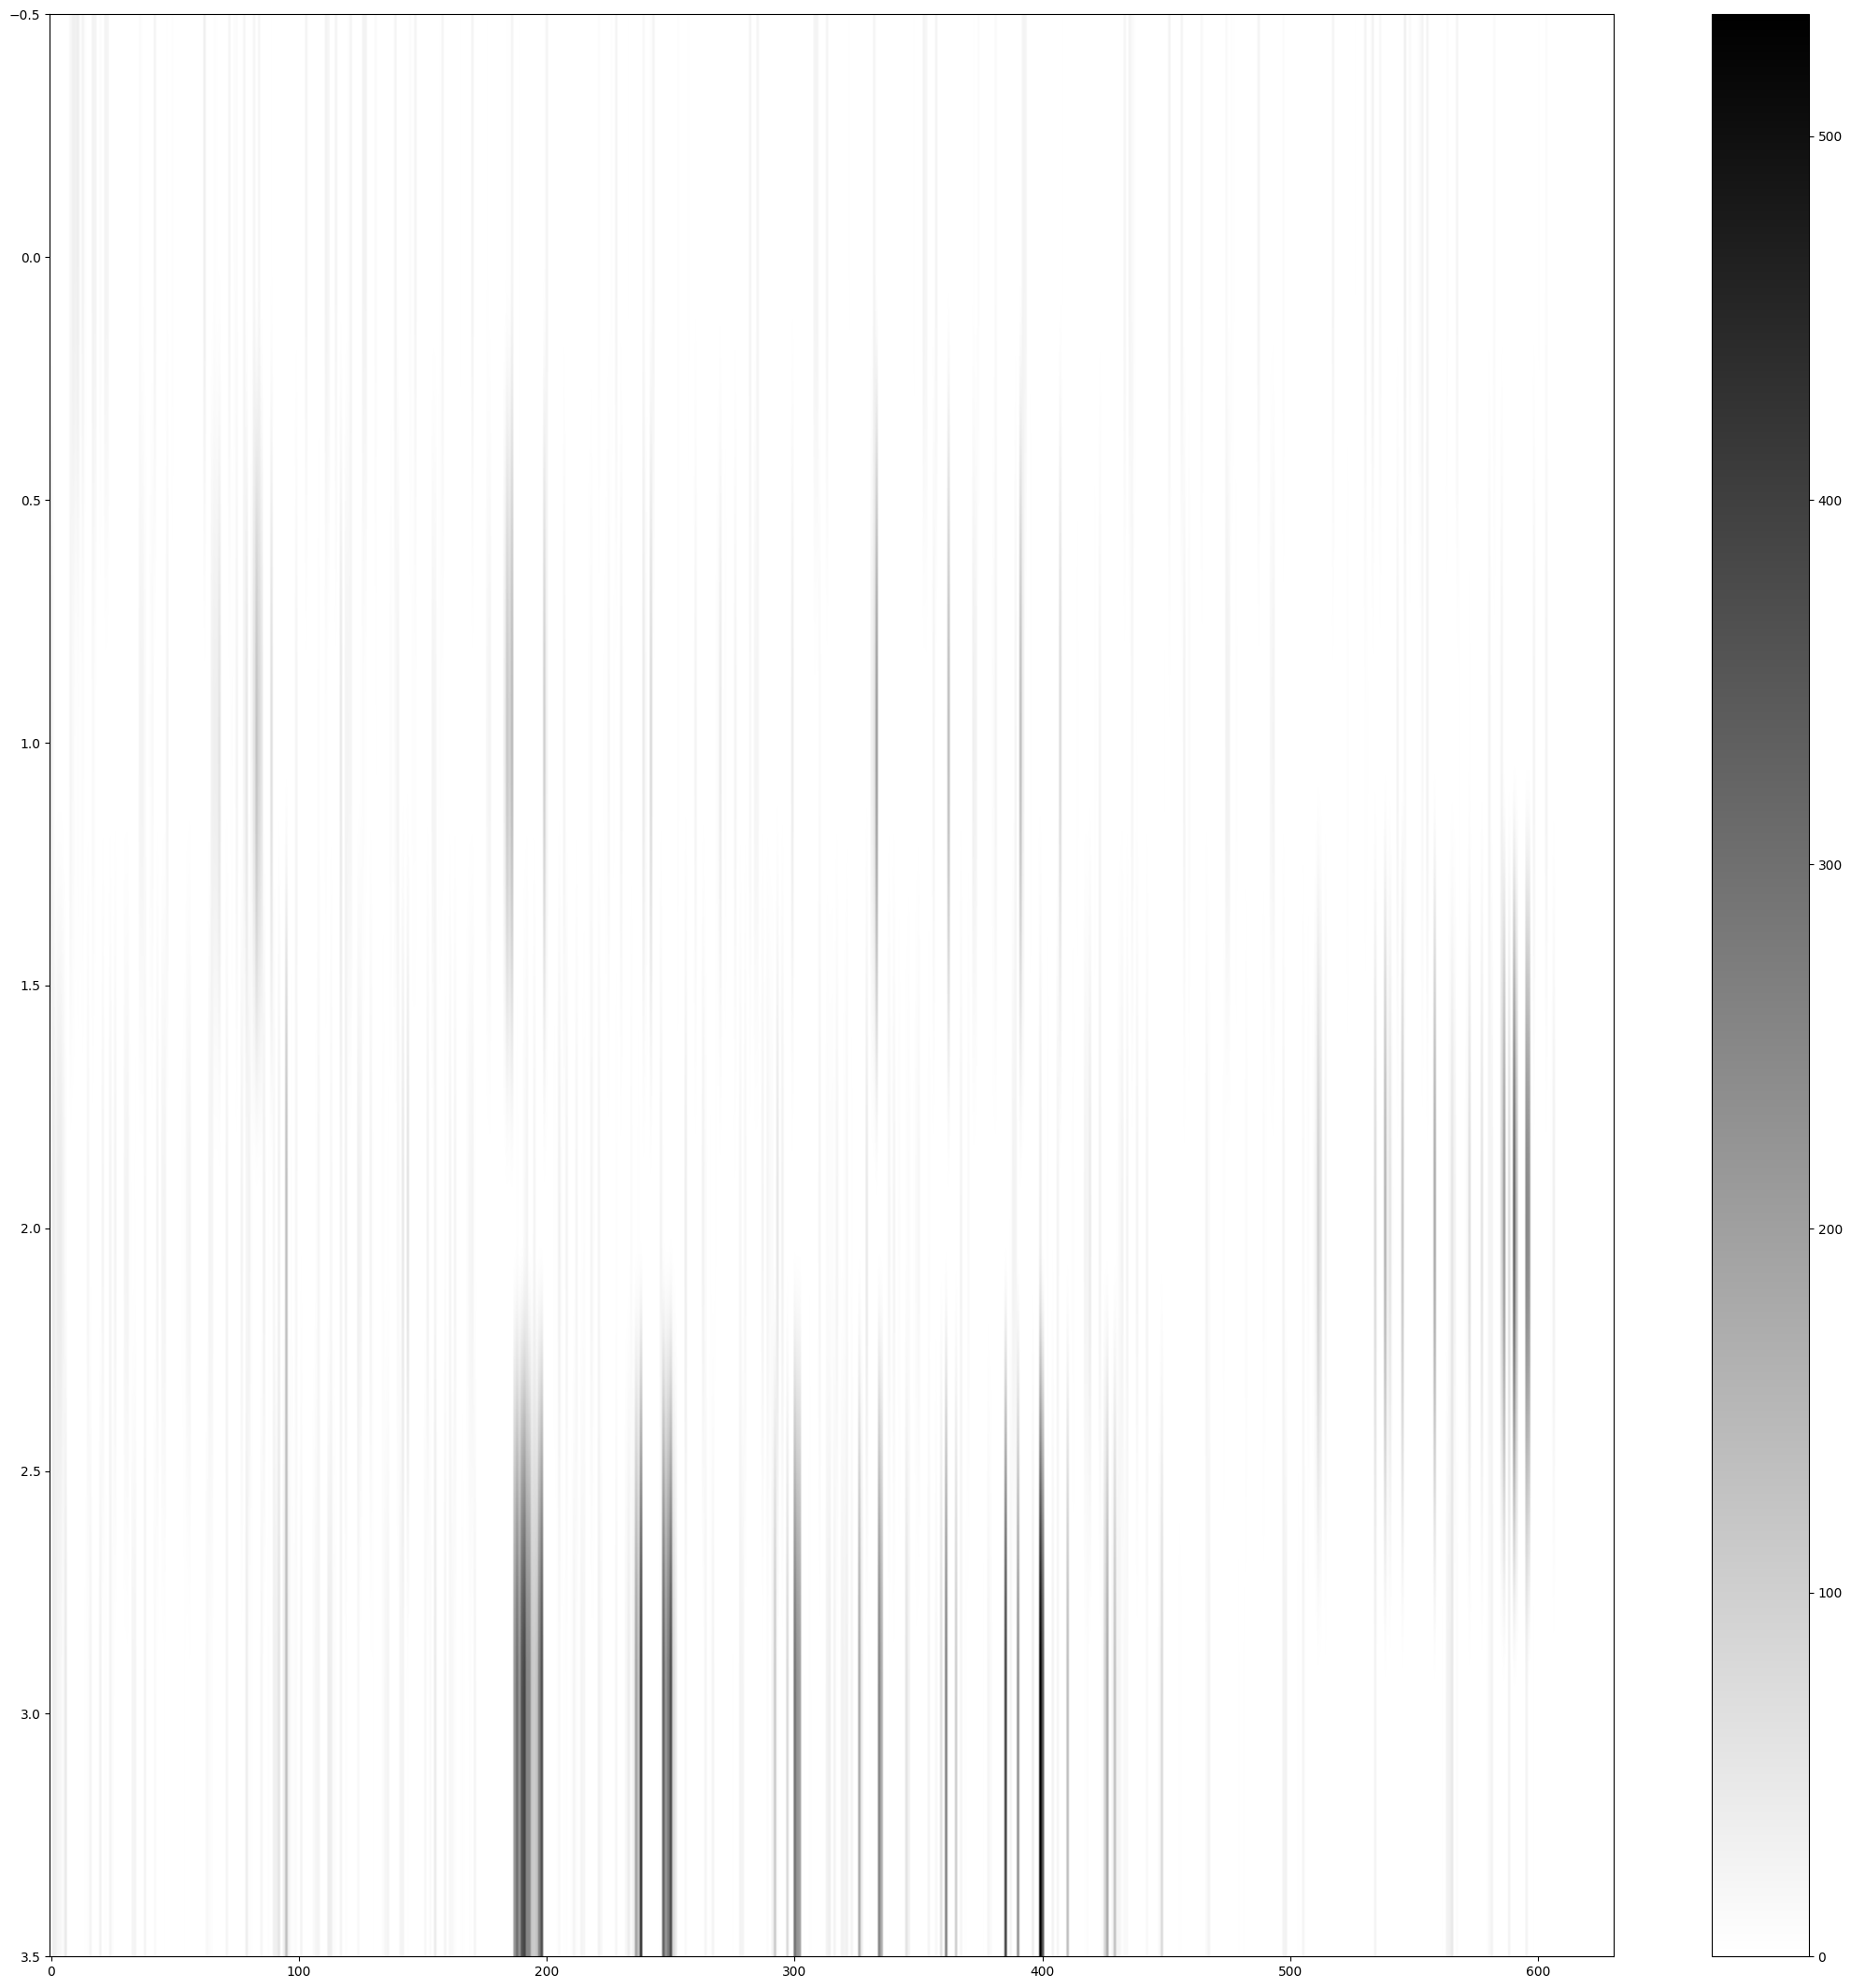

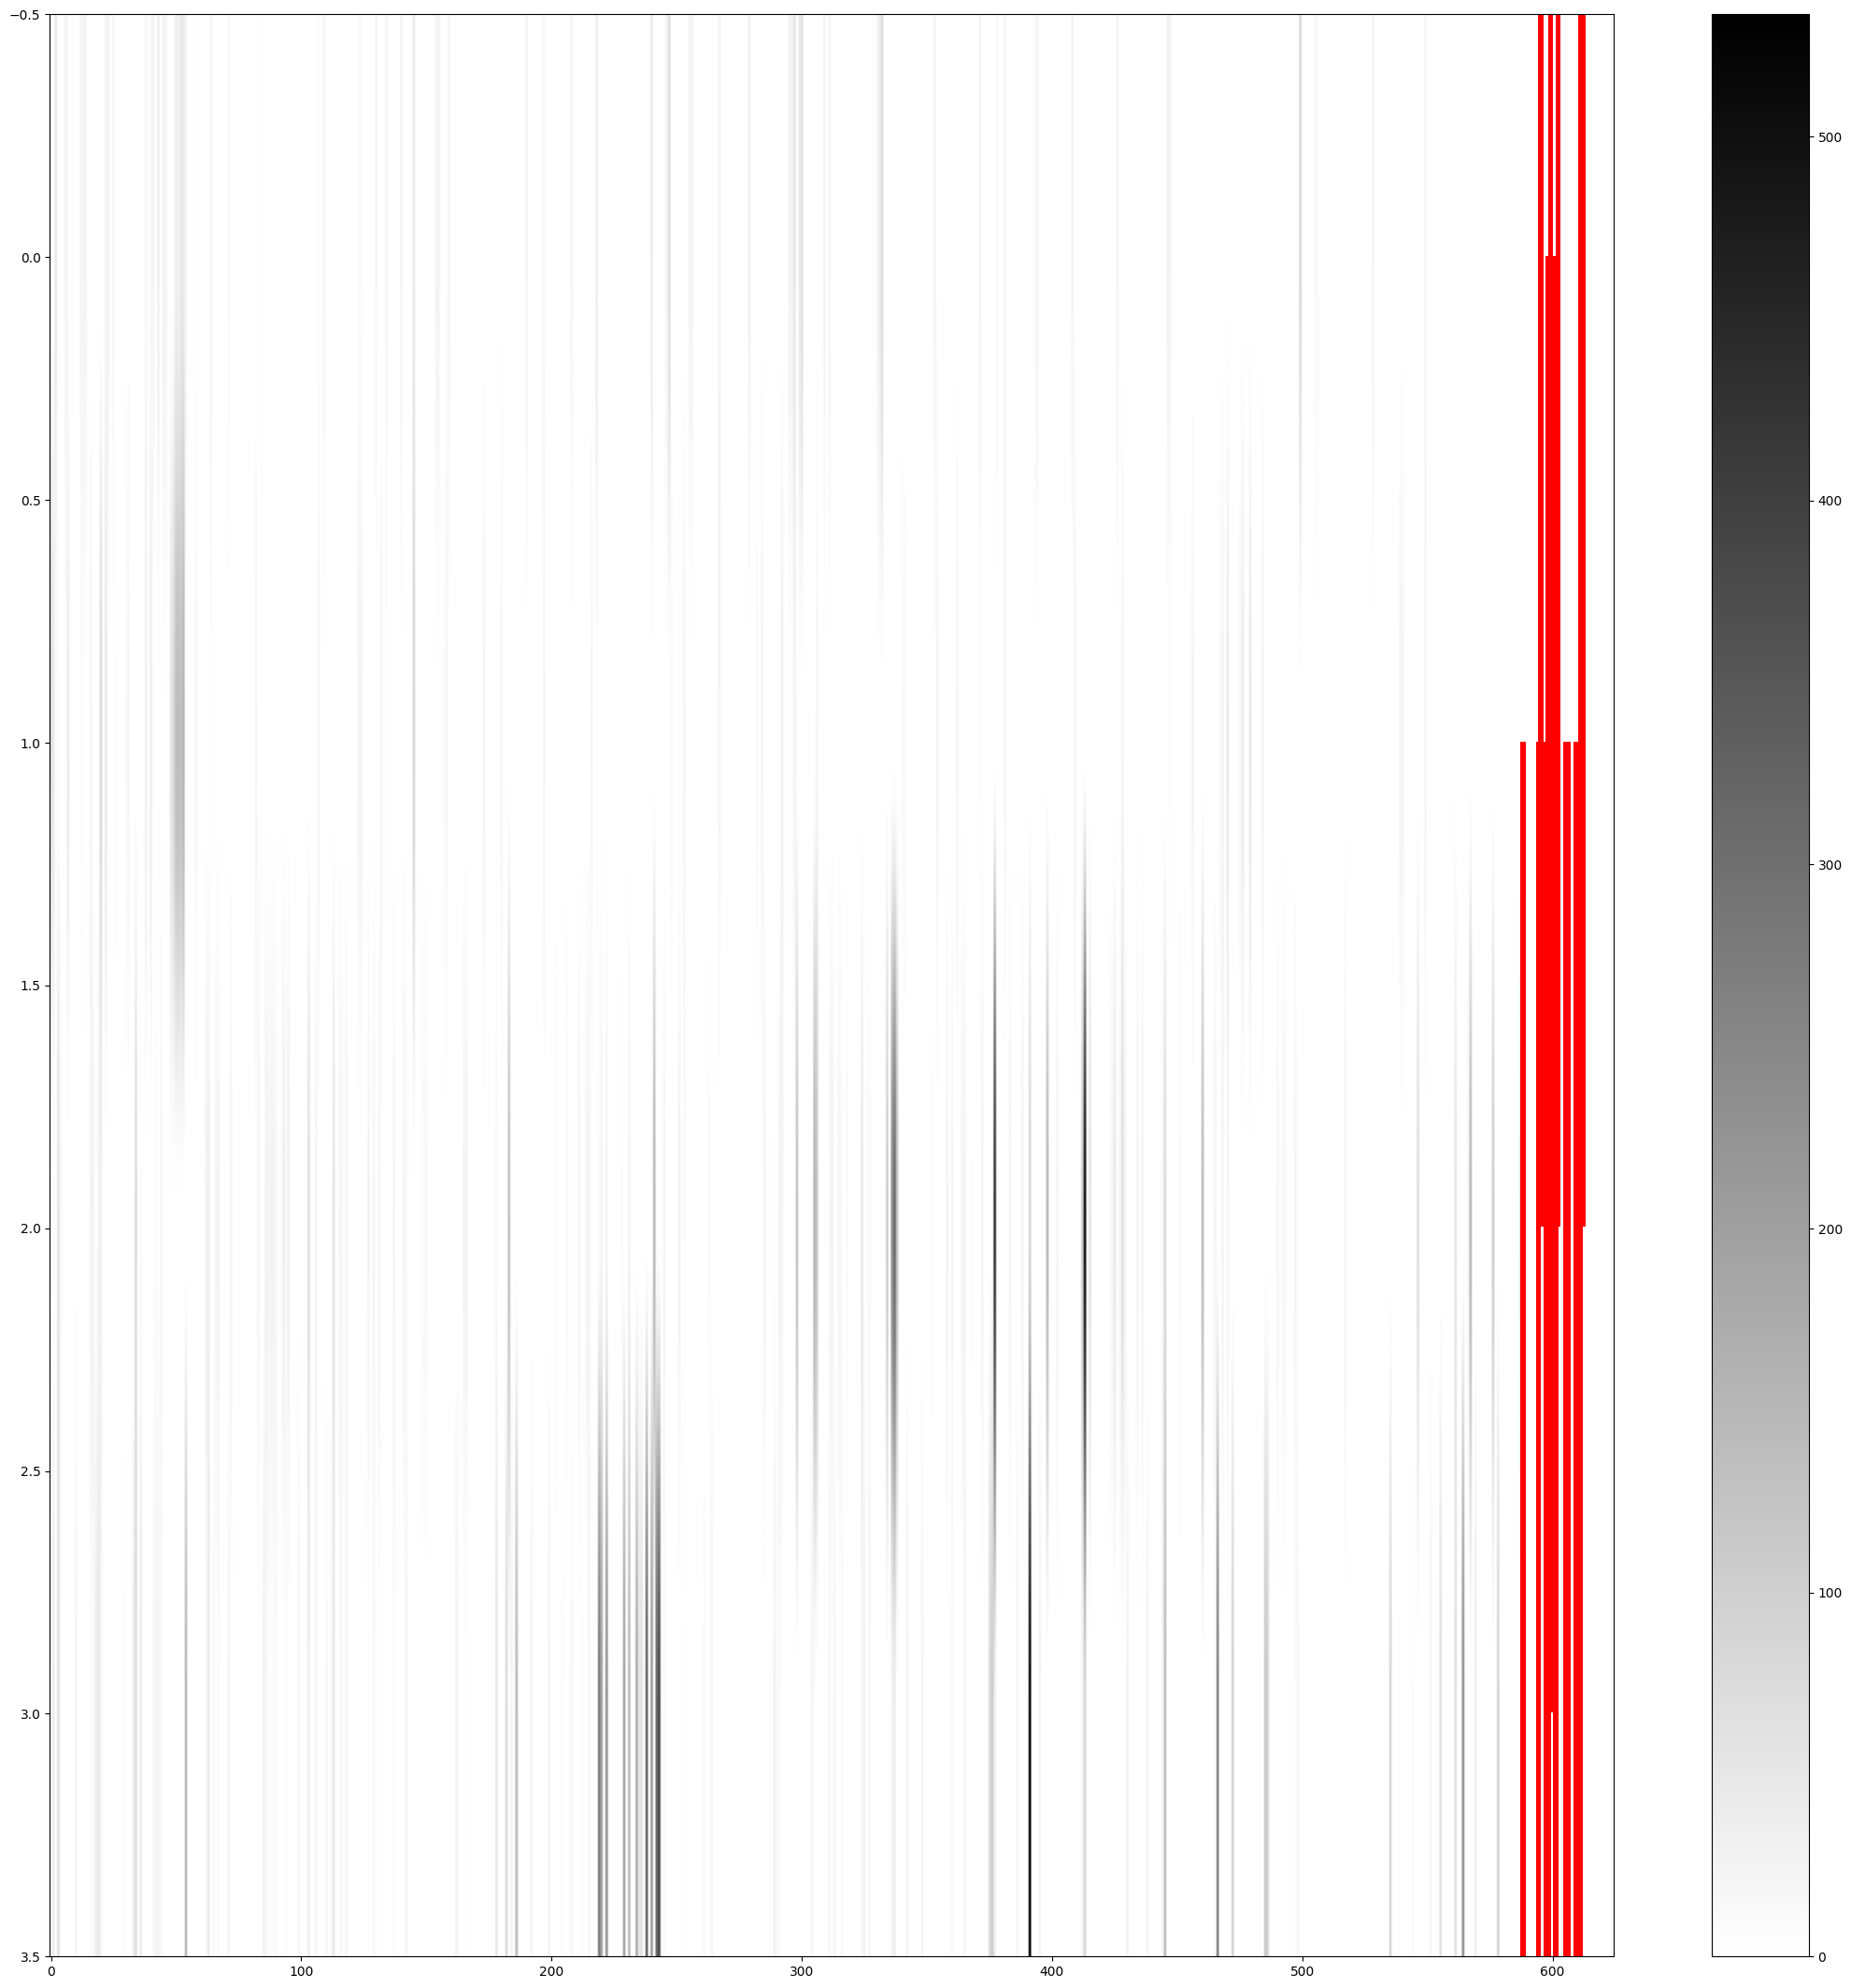

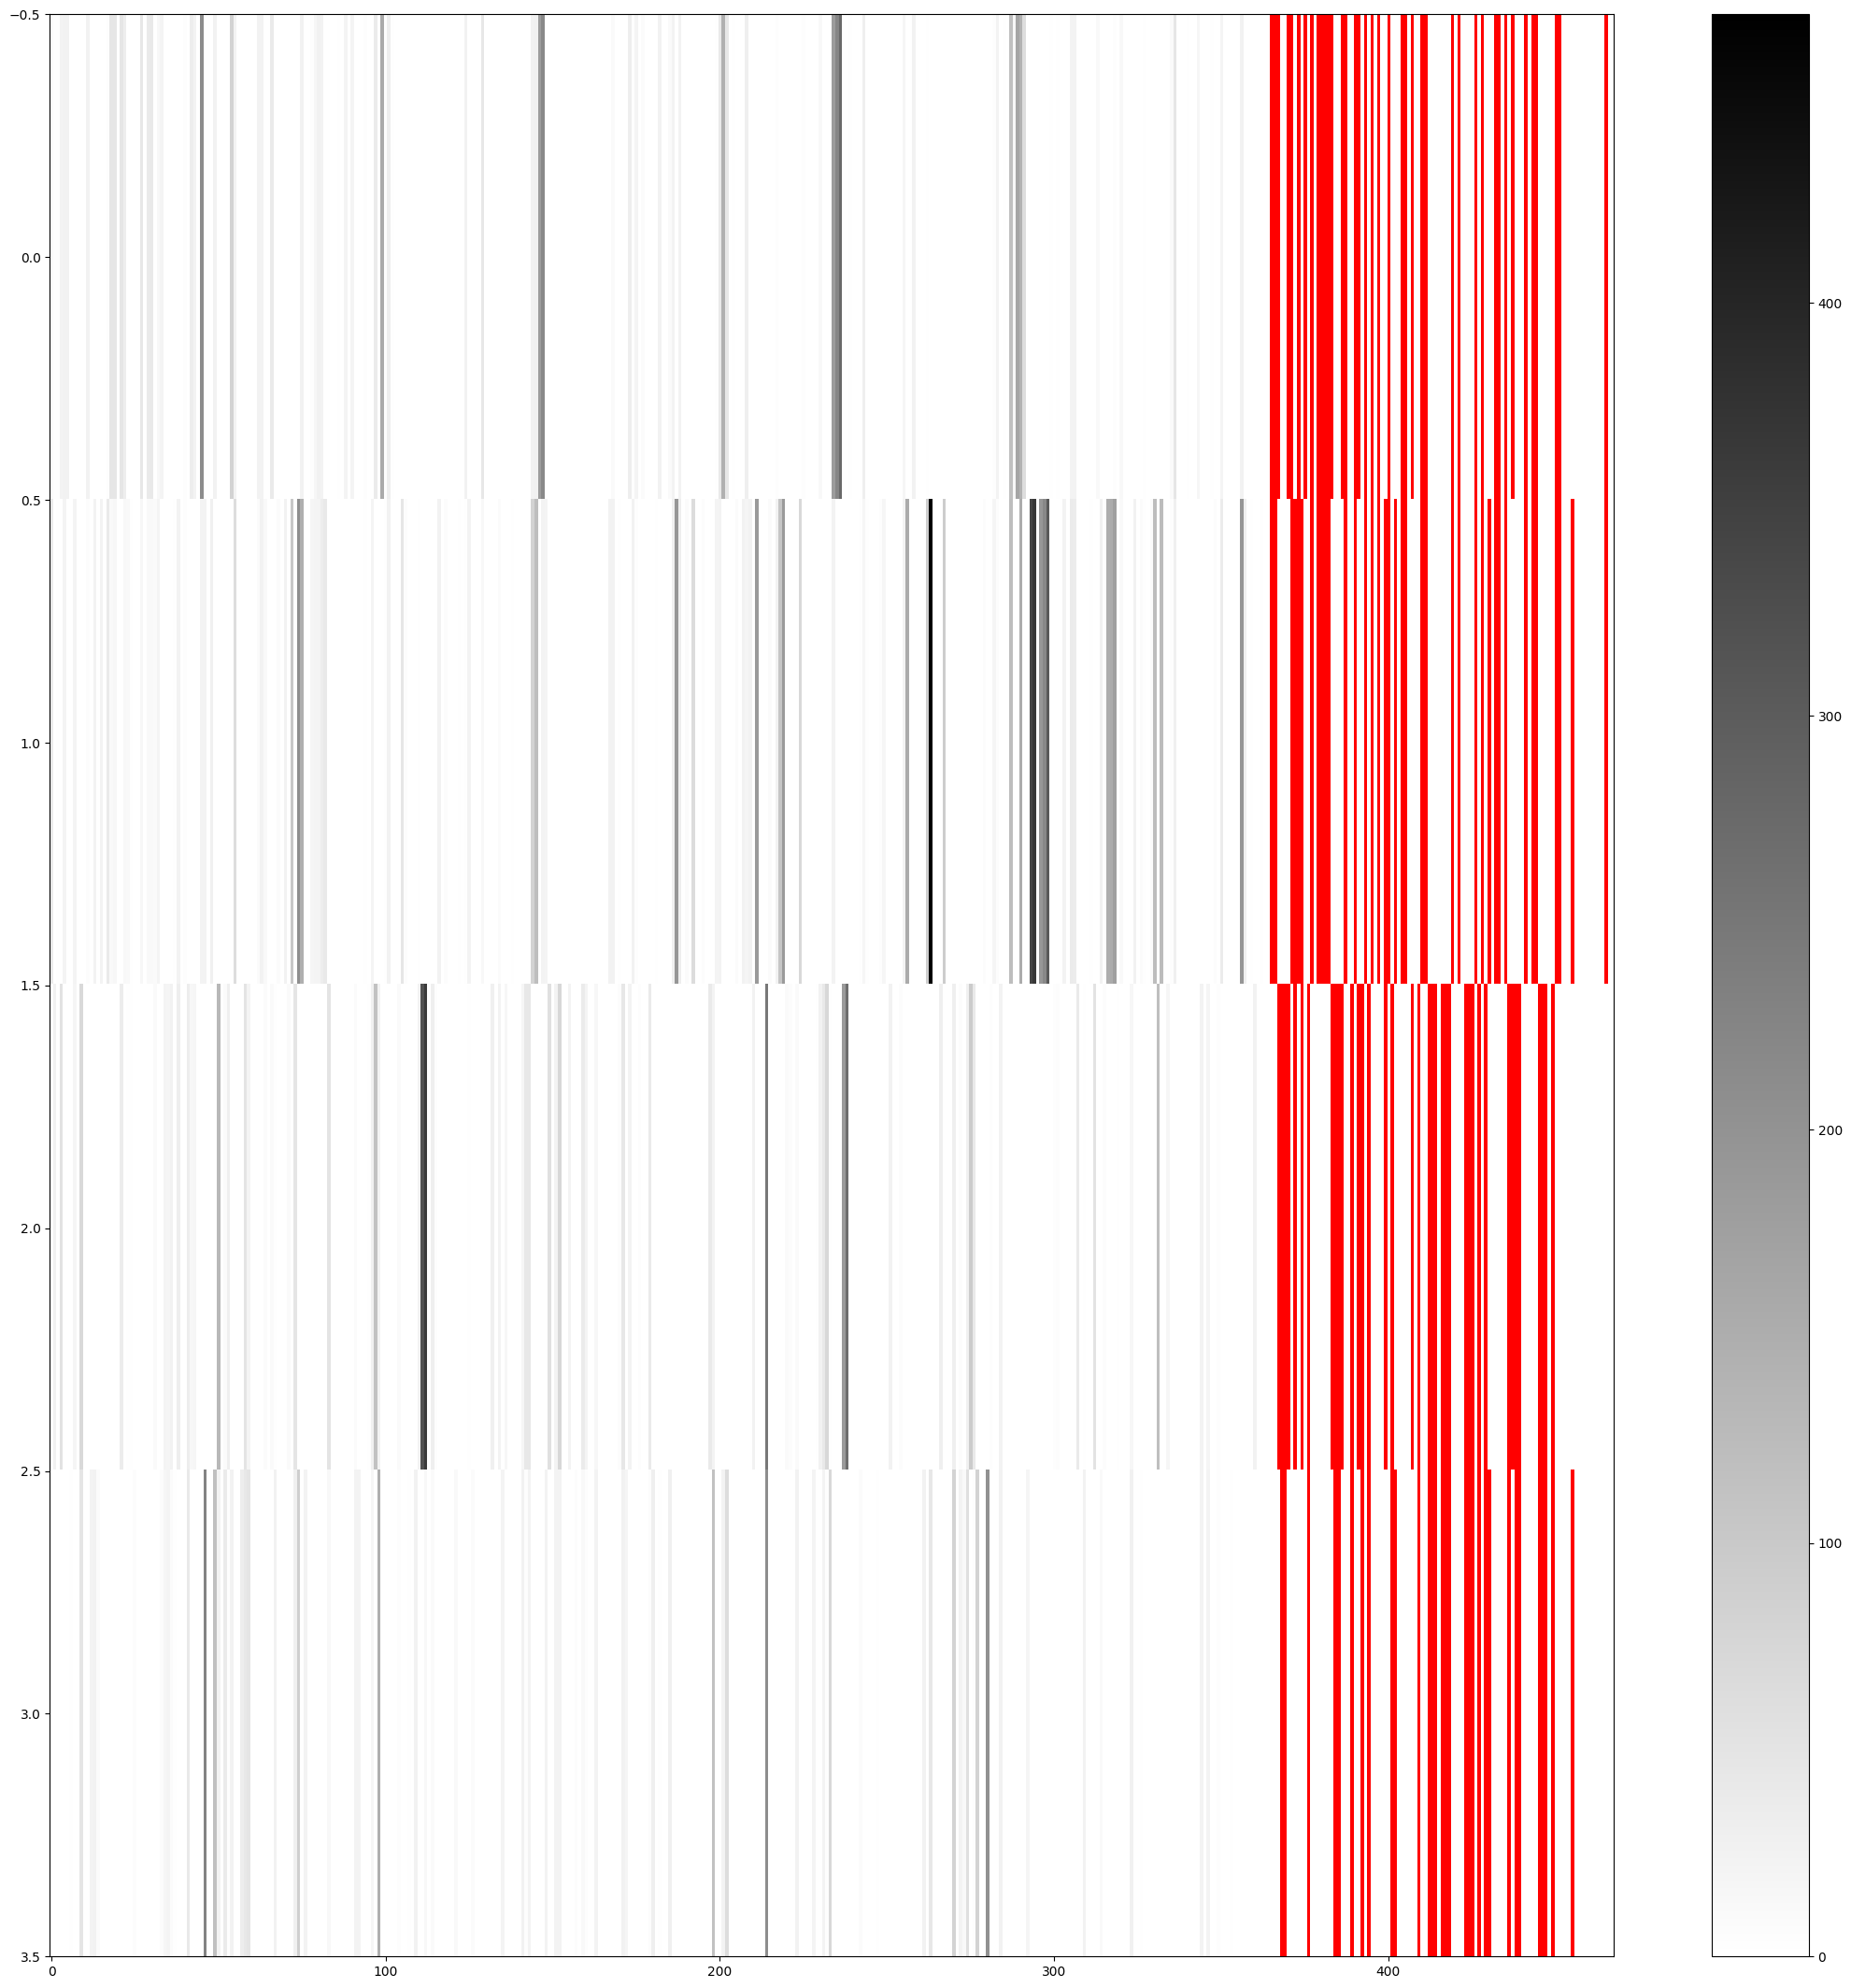

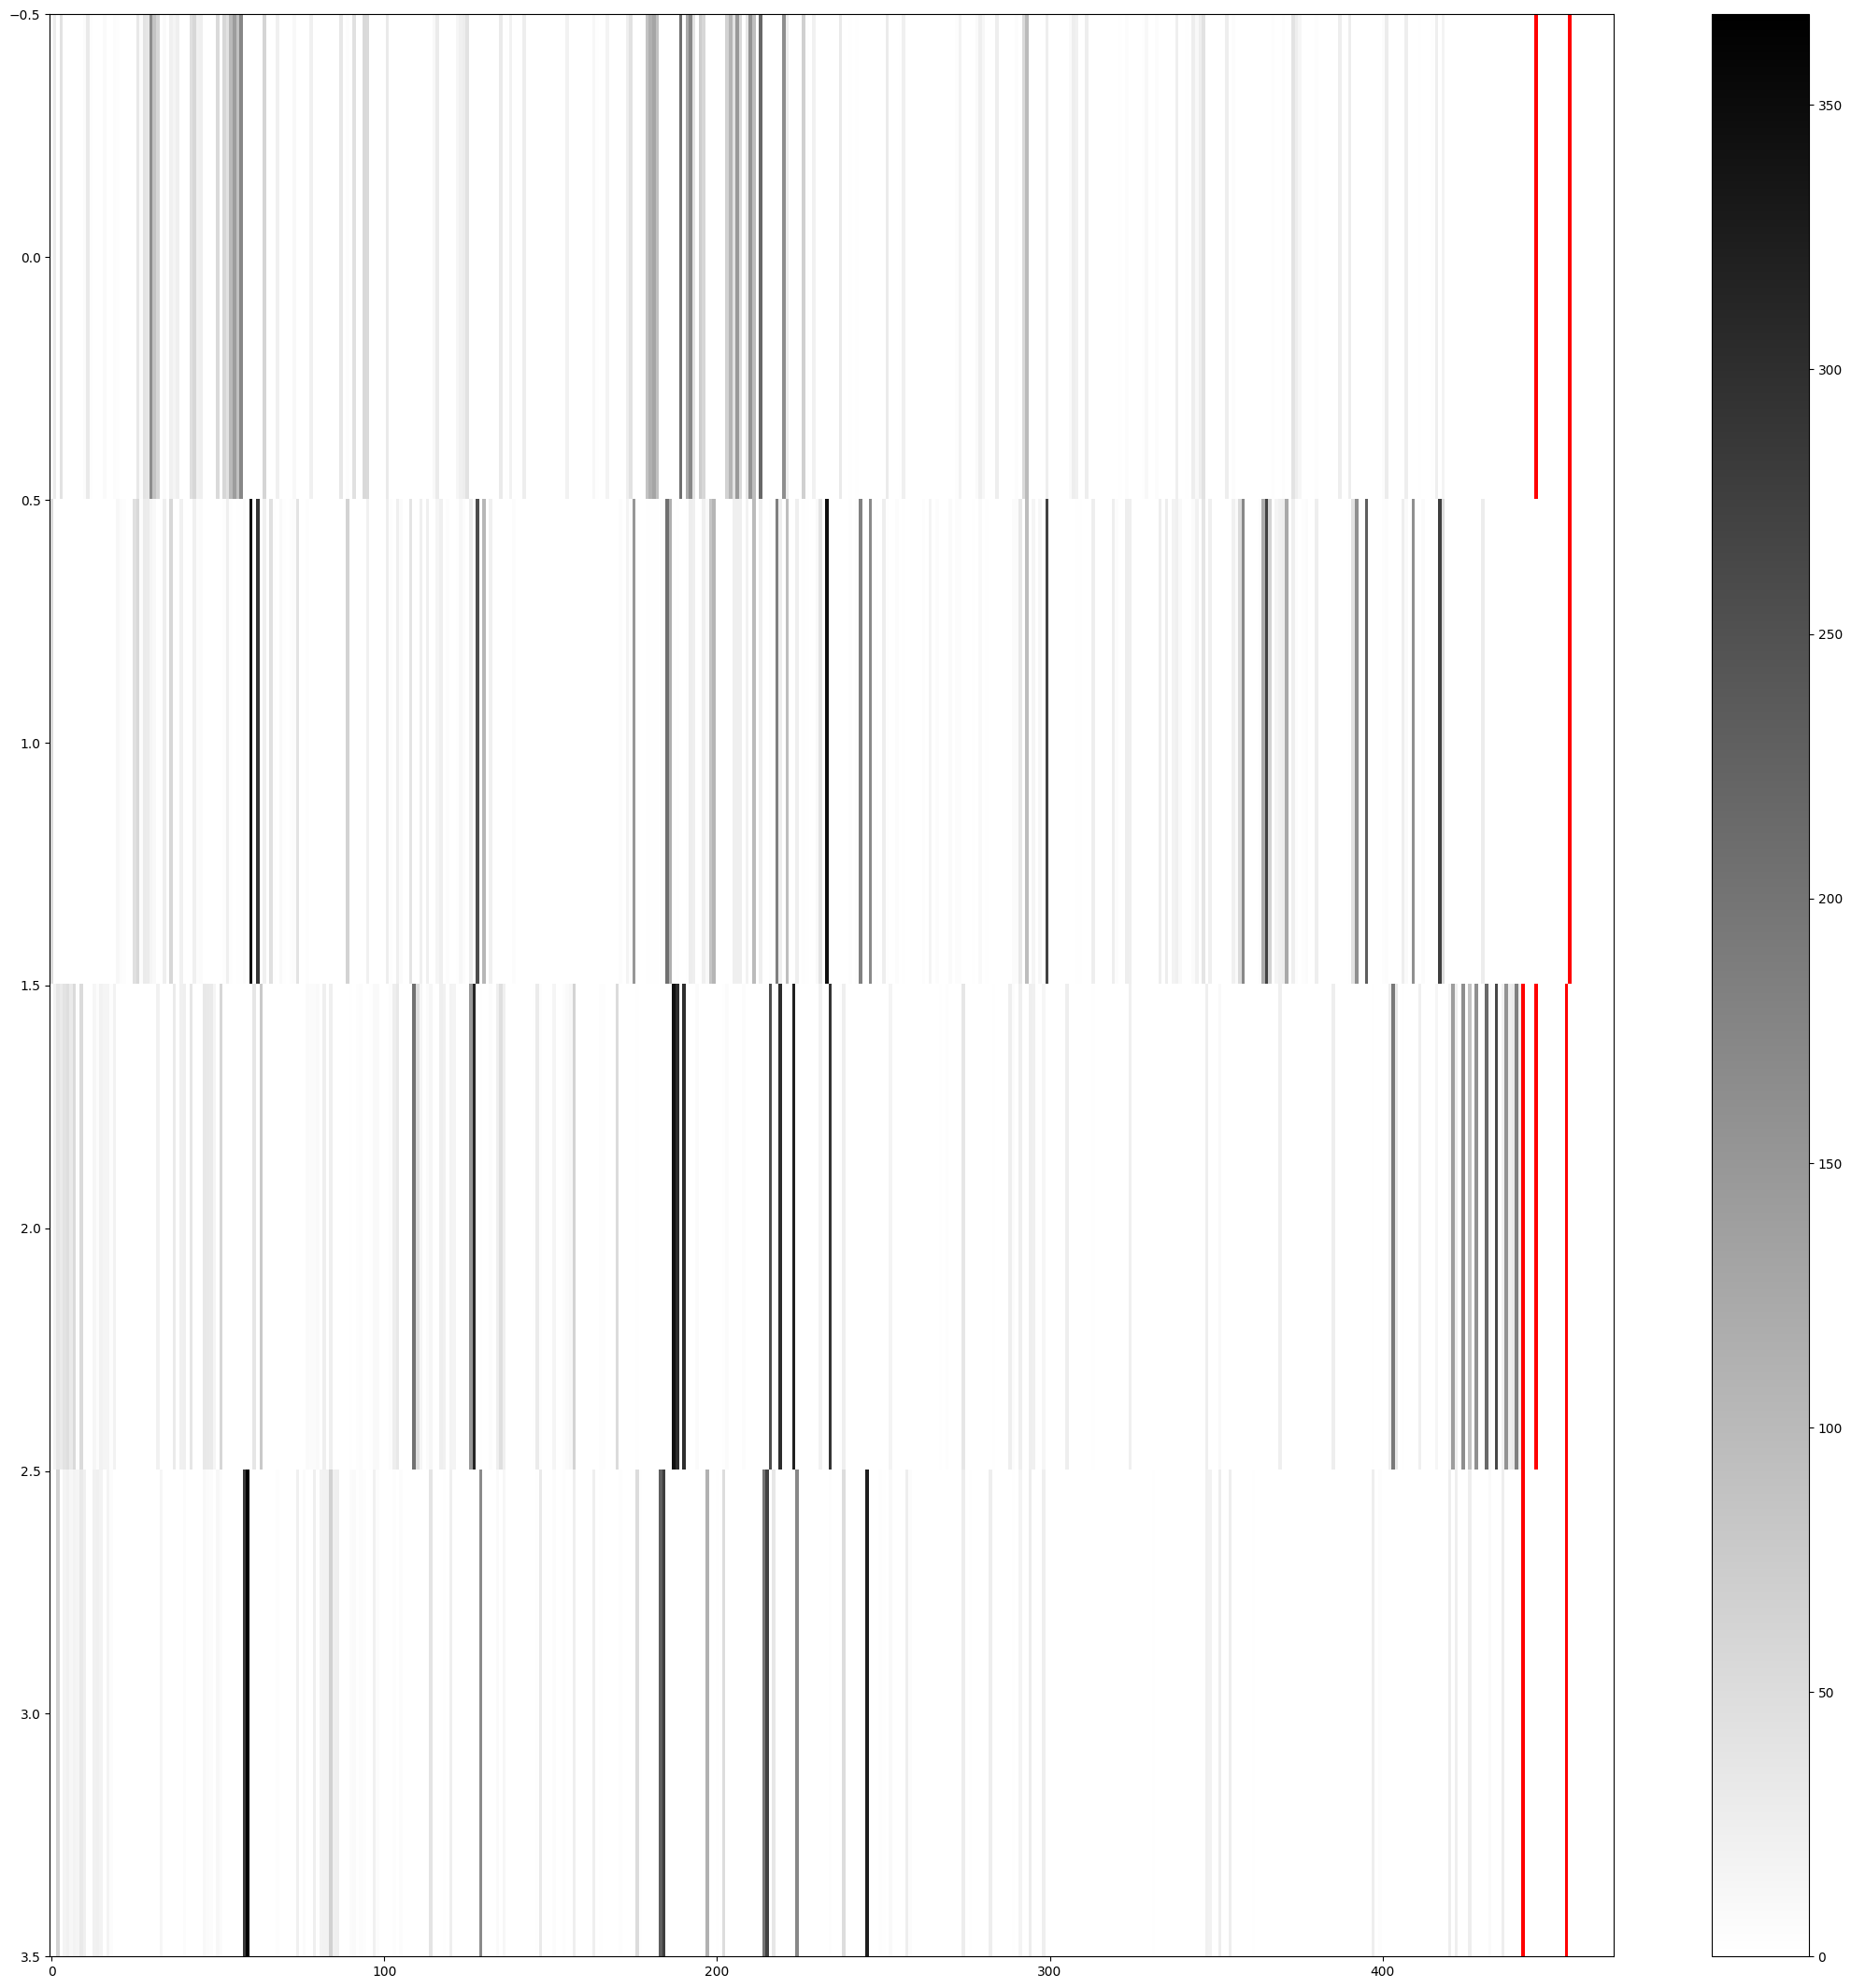

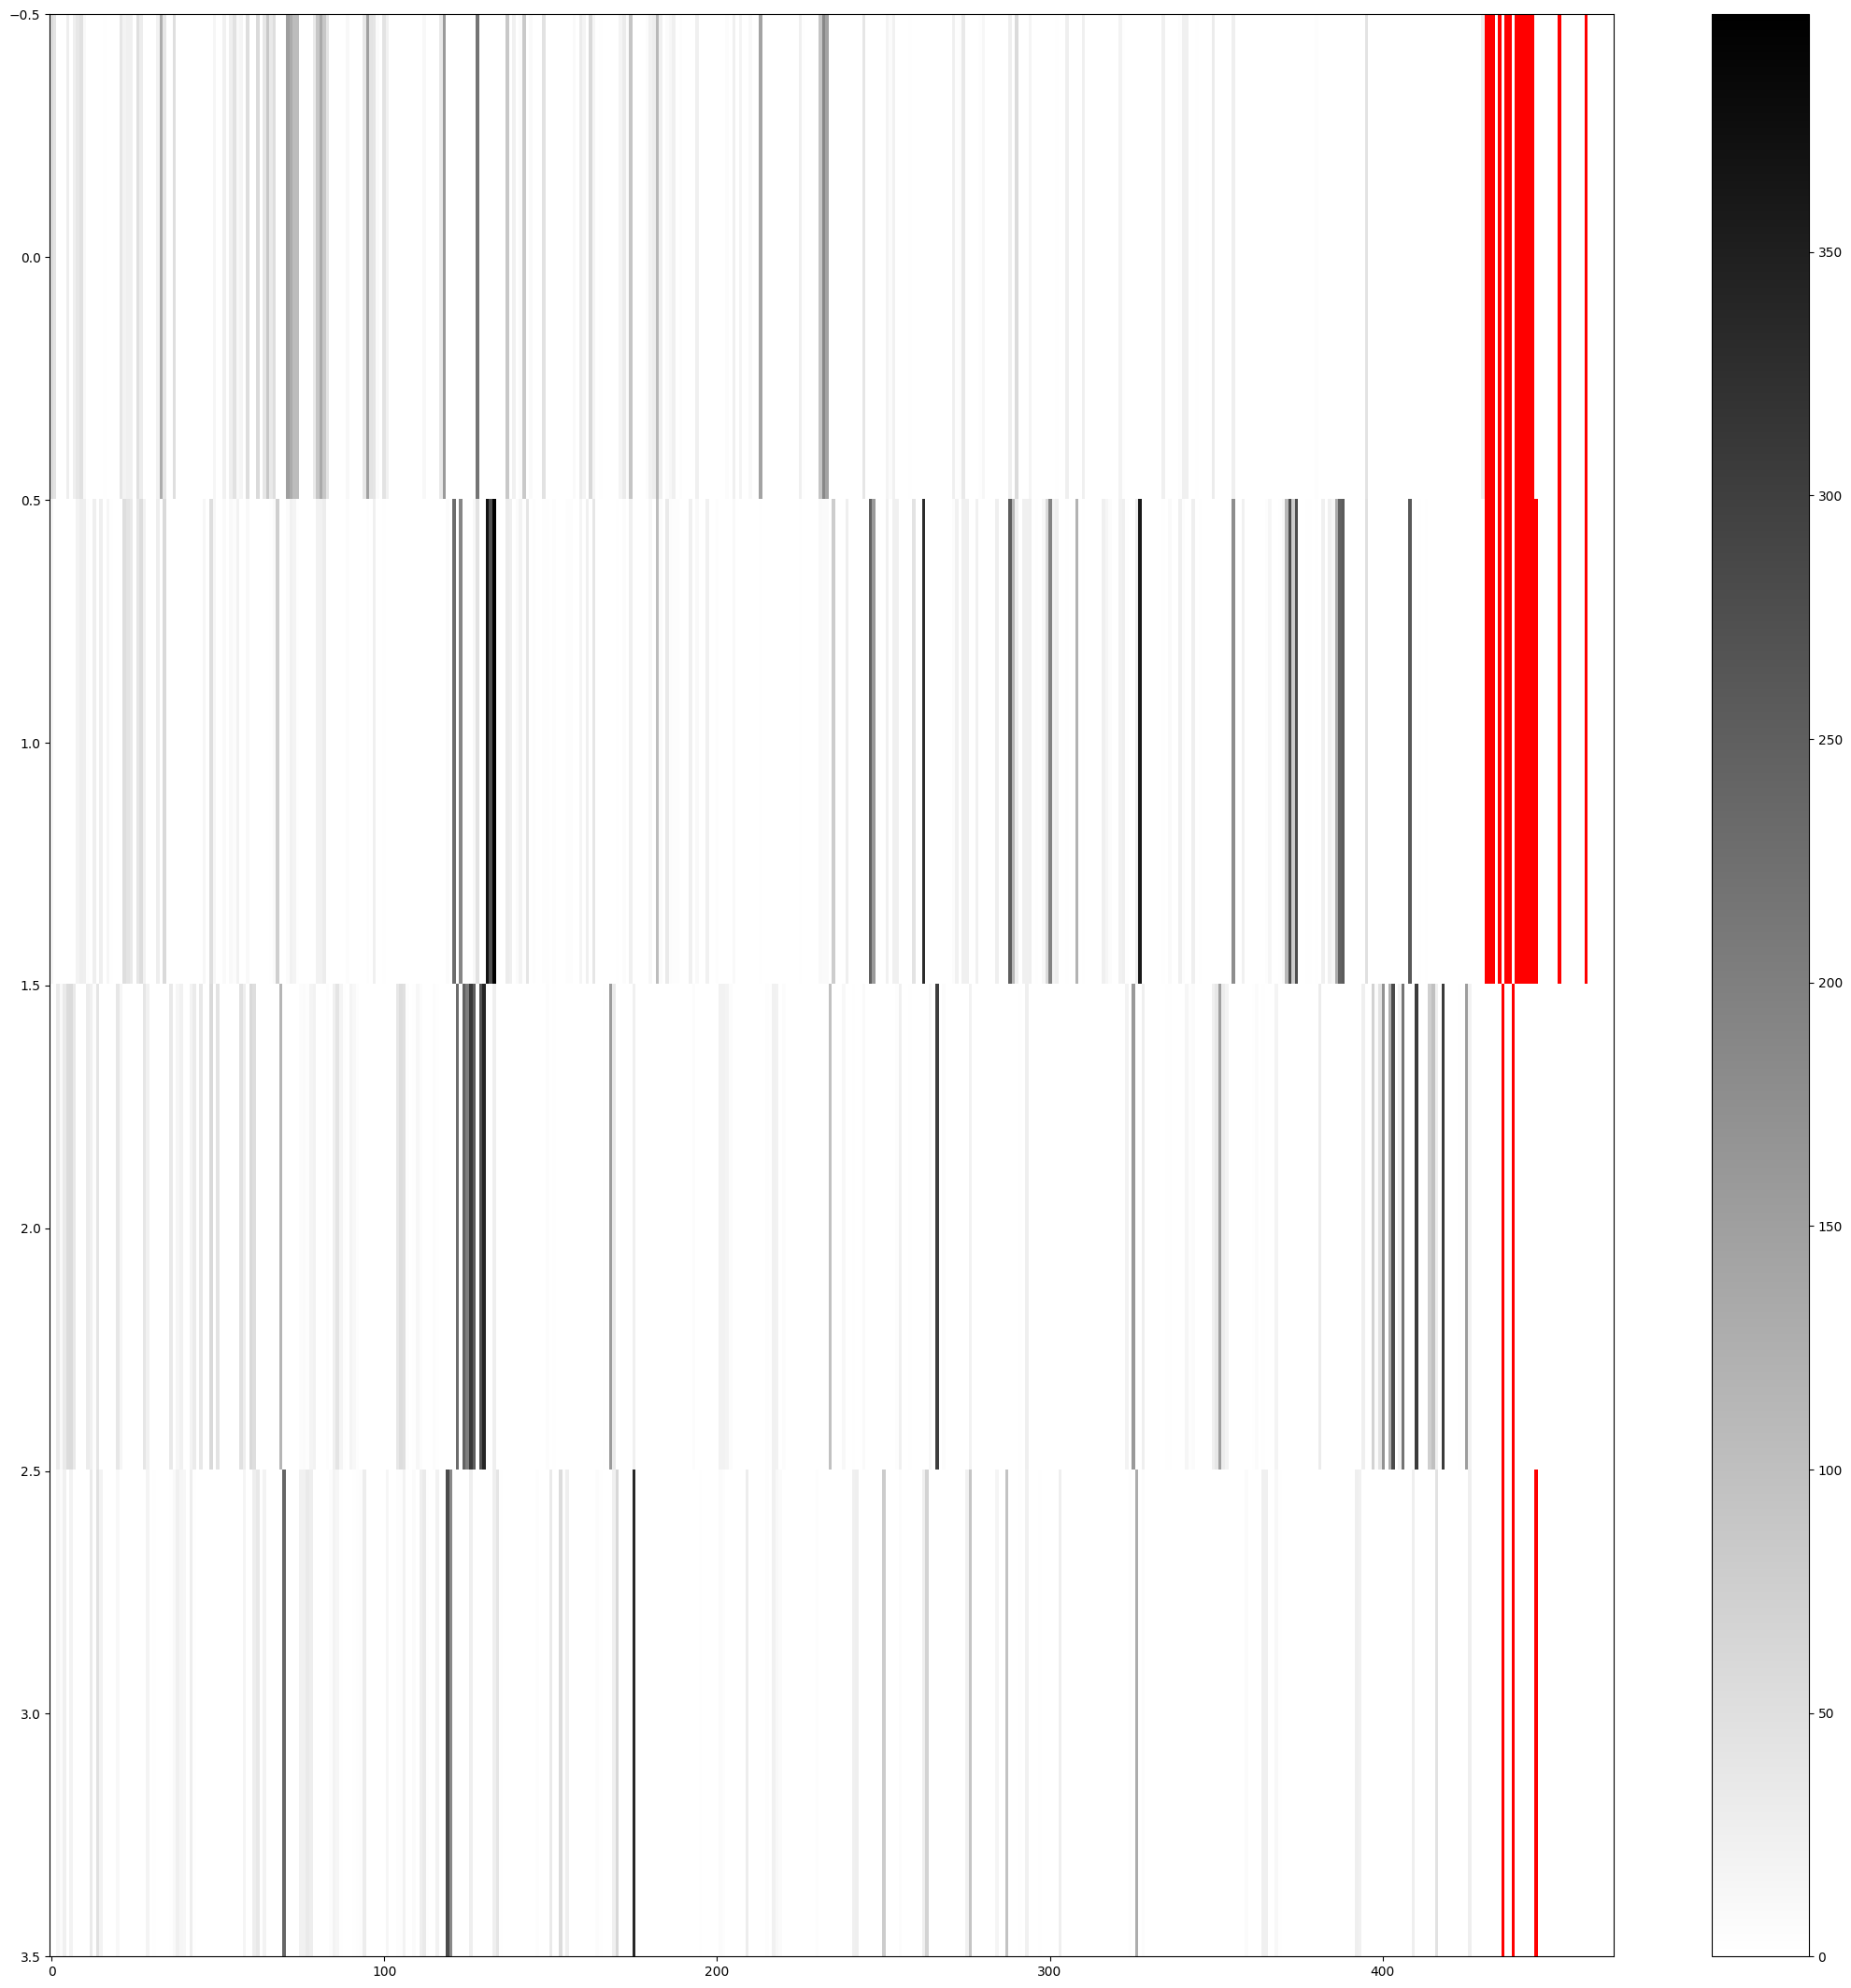

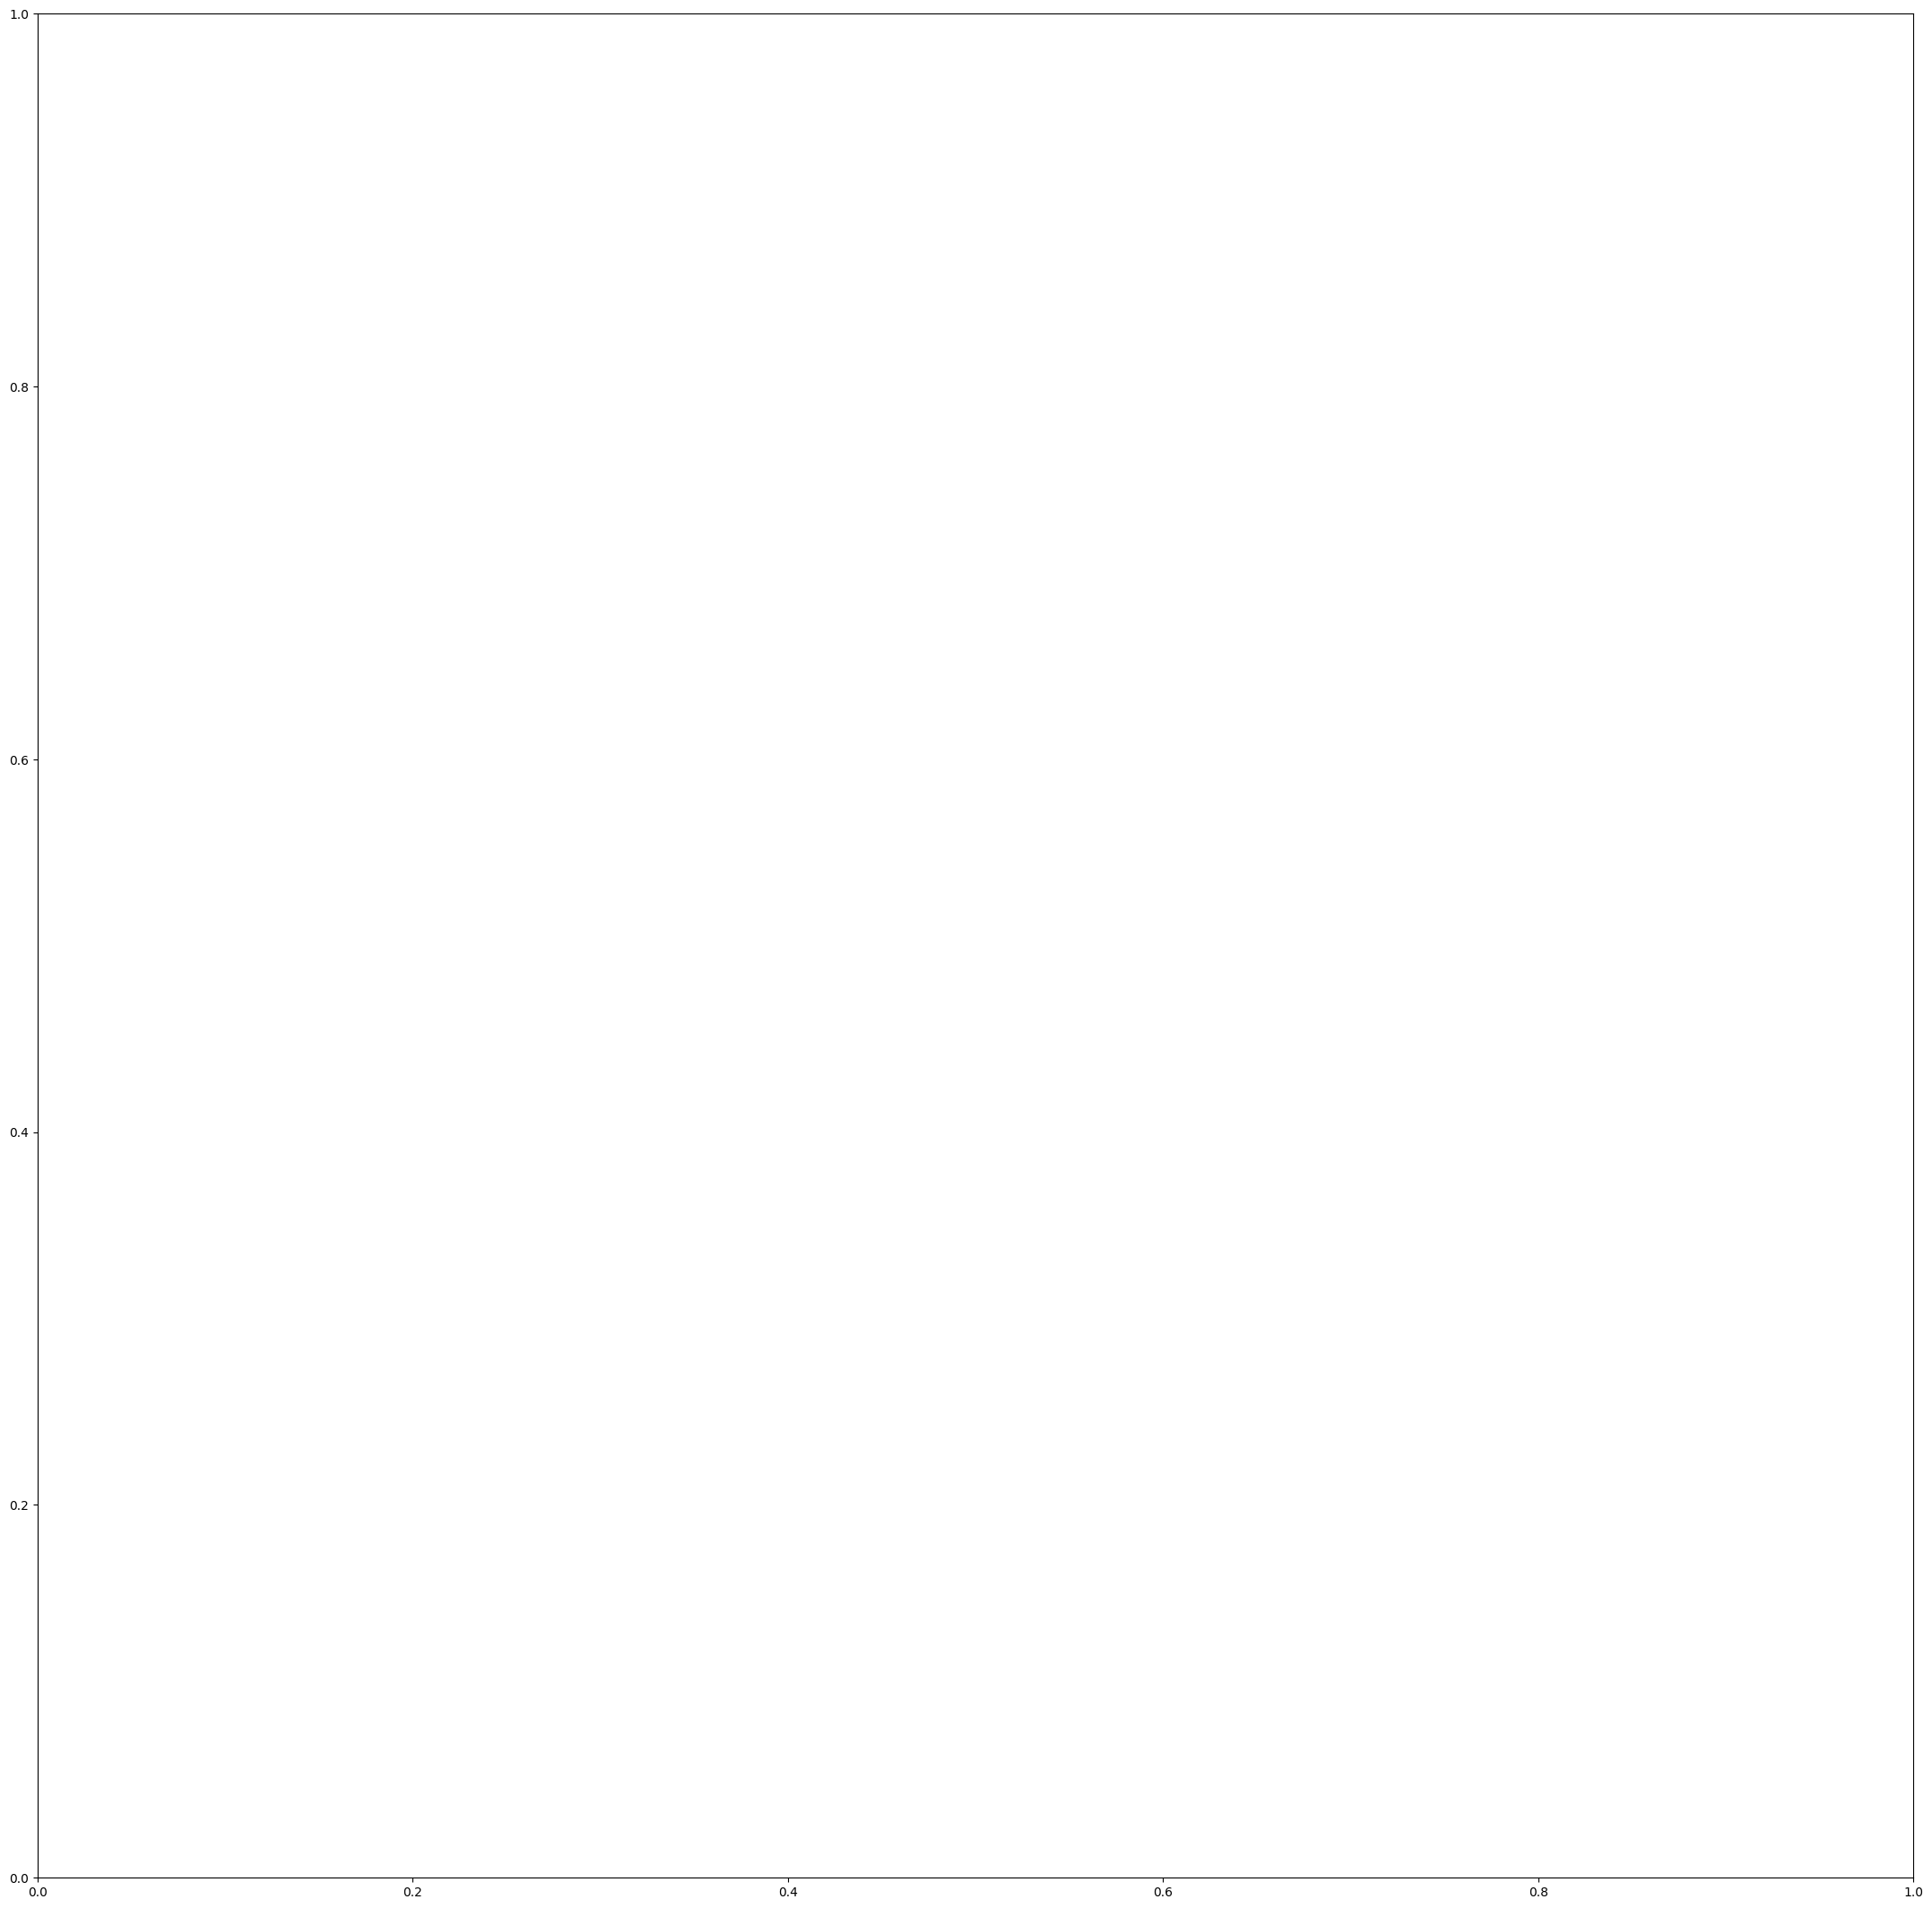

In [21]:
ax = plt.axes()
for grid in data.keys():
    for ghost in data[grid].keys():
        try:
            fig, ax = plt.subplots(1,1, figsize=(27,27))
            print(f"exploring grid: {grid} w/ ghost {ghost}, noise-no_noise")
            name_ = f"grid: {grid} w ghost {ghost}, noise-no_noise"
            actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)
            action_pd_no_noise = pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0}').T.stack().apply(pd.Series).T.iloc[["0","1","2","4"]]
            action_pd_no_noise.columns = action_pd_no_noise.columns.droplevel()
            action_pd_noise = pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0.1}').T.stack().apply(pd.Series).T.iloc[["0","1","2","4"]]
            action_pd_noise.columns = action_pd_noise.columns.droplevel()
            merge = pd.merge(action_pd_no_noise, action_pd_noise, how='outer')
            plt.imshow(np.where(np.isnan(merge.iloc[:4,:].to_numpy()) & np.isnan(merge.iloc[4:,:].to_numpy()), 0, abs(merge.iloc[:4,:].to_numpy() - merge.iloc[4:,:].to_numpy())), aspect="auto", cmap=cmap)
            plt.colorbar()
            plt.savefig(f"img/{name_}.png")
        except:
            pass
        


In [12]:
actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)
action_pd_no_noise =pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0}').T.stack().apply(pd.Series).T.iloc[["0","1","2","4"]]
action_pd_no_noise.columns = action_pd_no_noise.columns.droplevel()
actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)

exploring grid: v2 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise


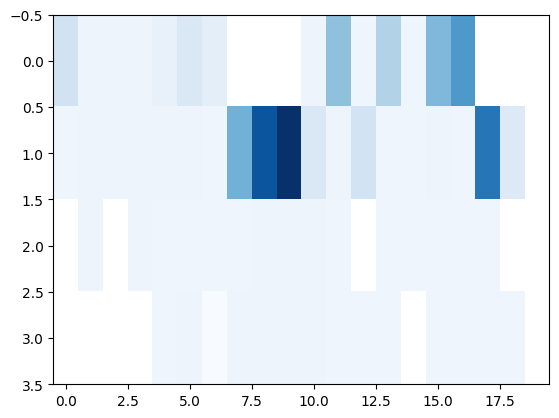

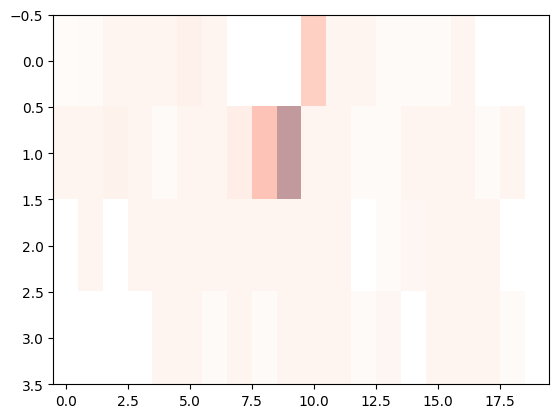

/tmp/ipykernel_25688/2415724376.py:17: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



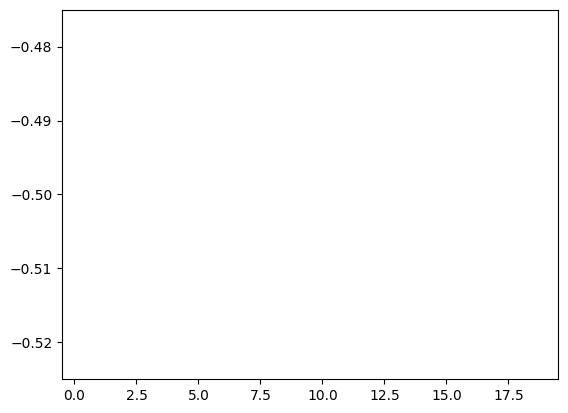

exploring grid: v2 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise


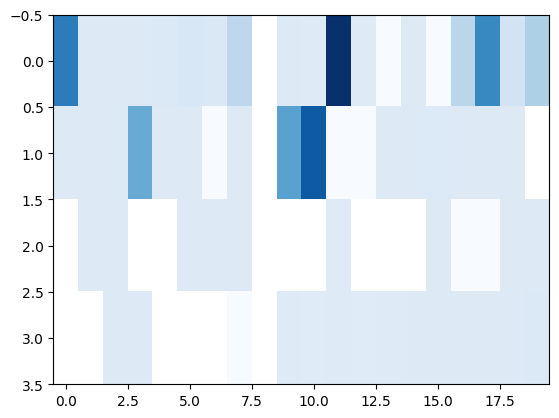

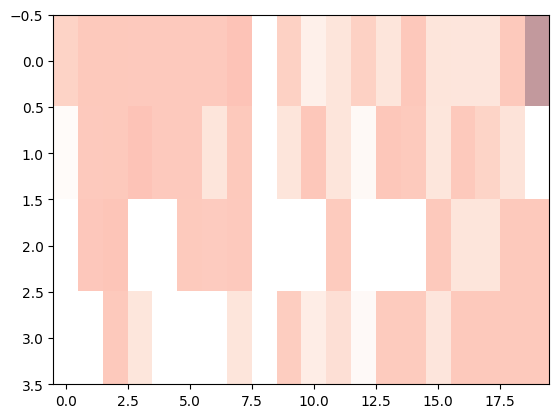

/tmp/ipykernel_25688/2415724376.py:17: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



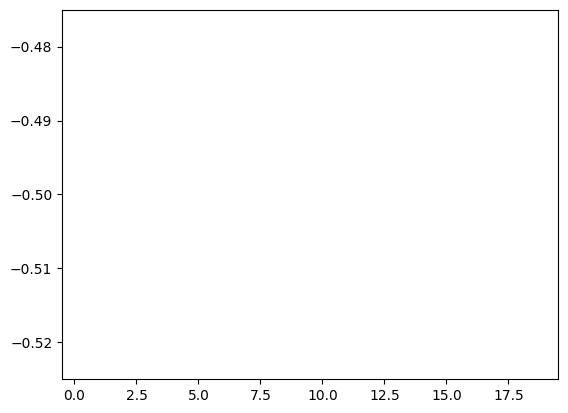

exploring grid: v2 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise


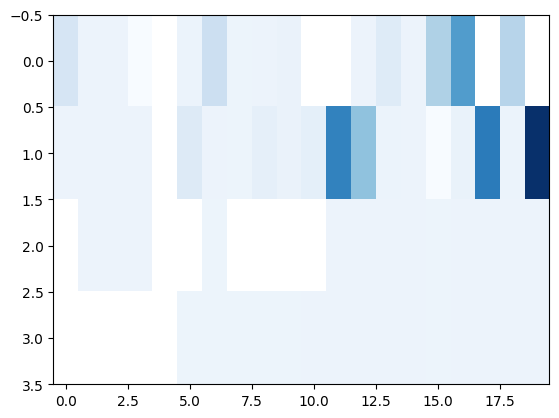

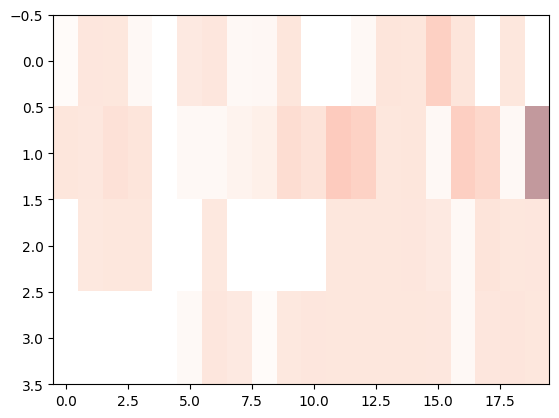

/tmp/ipykernel_25688/2415724376.py:17: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



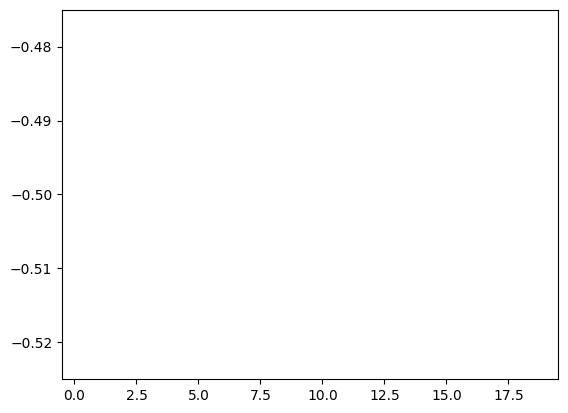

exploring grid: v3 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise


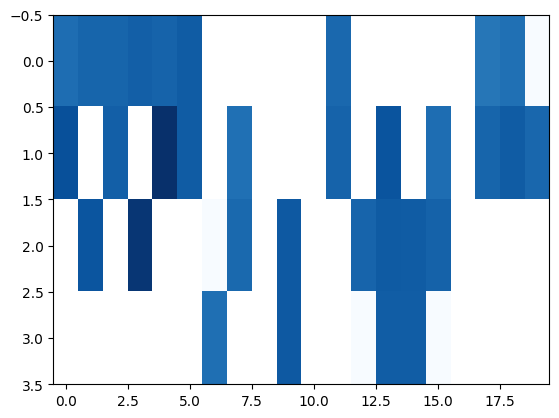

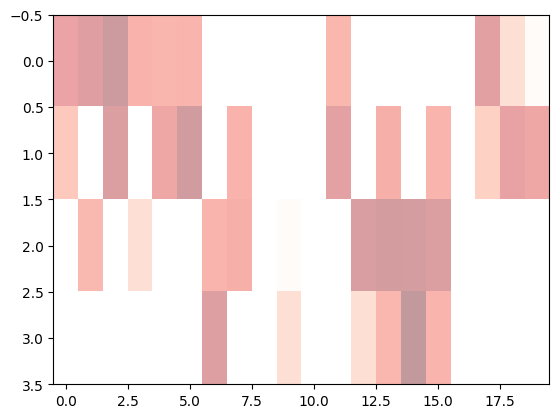

/tmp/ipykernel_25688/2415724376.py:17: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



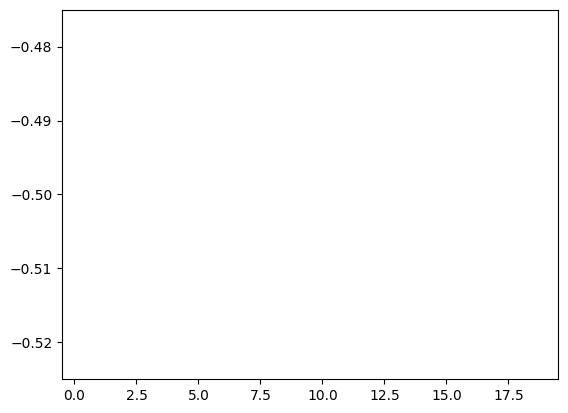

exploring grid: v3 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise


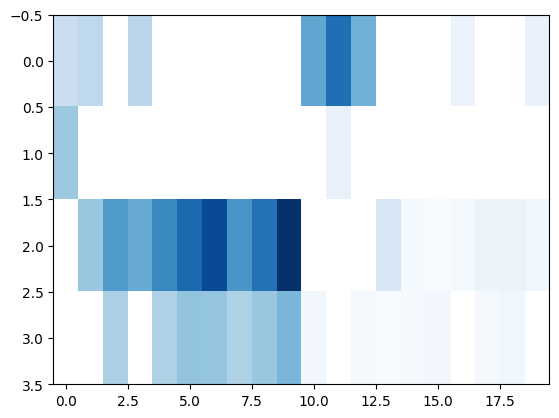

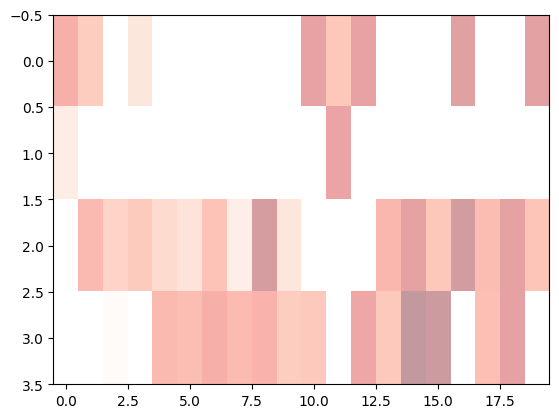

/tmp/ipykernel_25688/2415724376.py:17: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



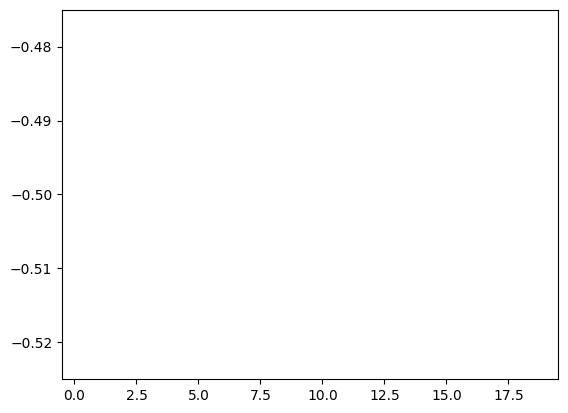

exploring grid: v3 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise


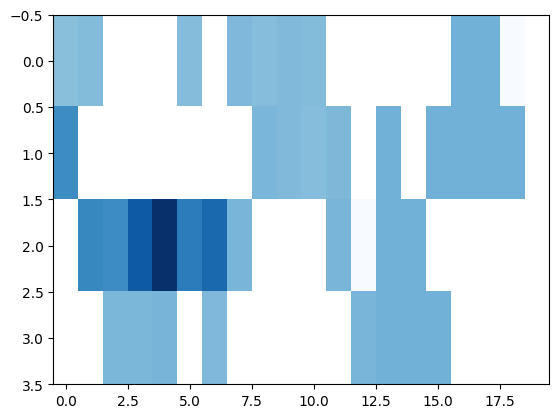

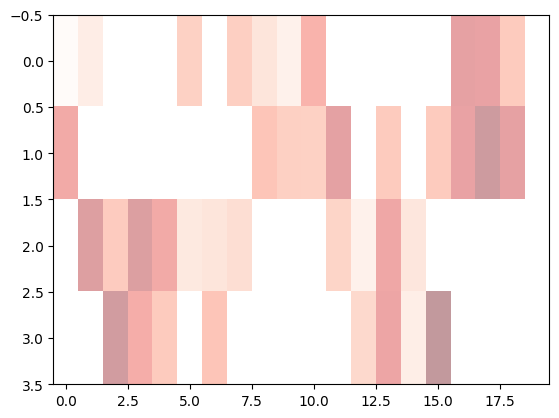

/tmp/ipykernel_25688/2415724376.py:17: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



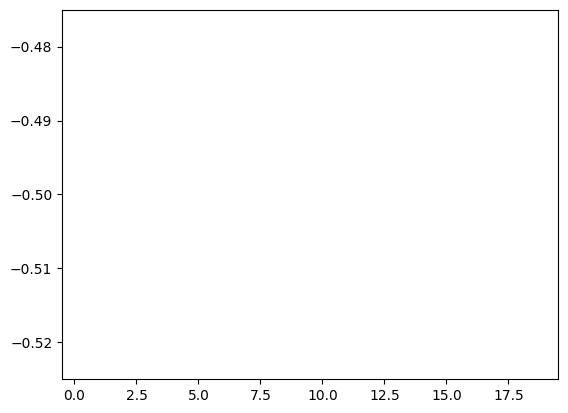

exploring grid: v4 w/ ghost DirectionalGhost_{"index":1,"prob":0.3}, noise-no_noise


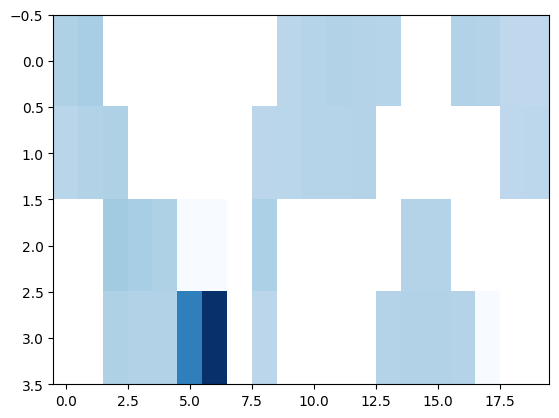

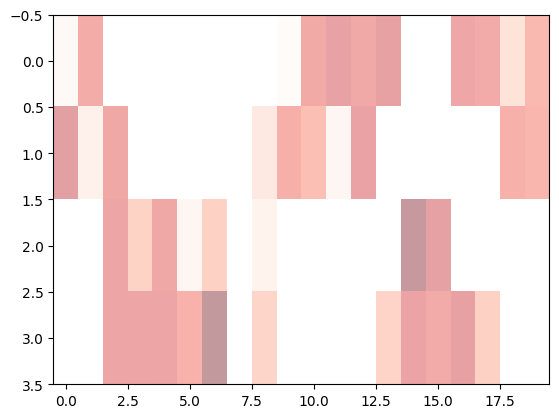

/tmp/ipykernel_25688/2415724376.py:17: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



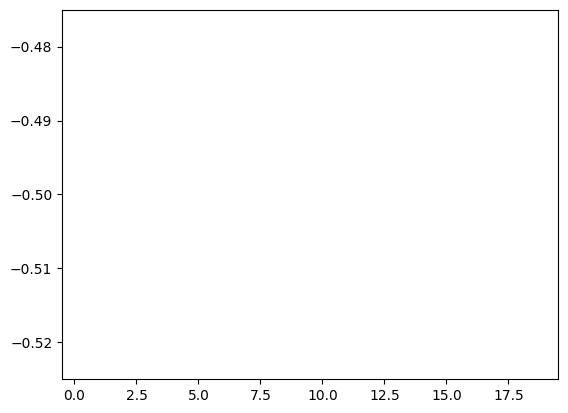

exploring grid: v4 w/ ghost RandomGhost_{"index":1,"prob":{}}, noise-no_noise


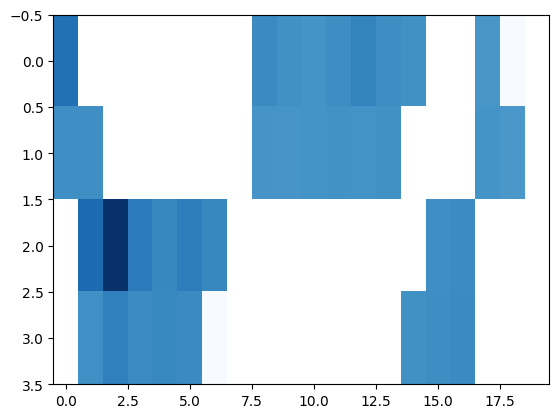

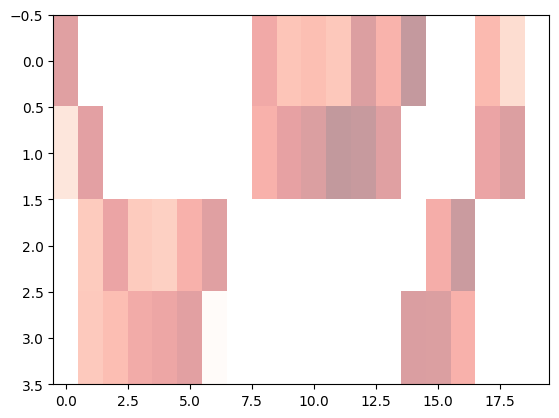

/tmp/ipykernel_25688/2415724376.py:17: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



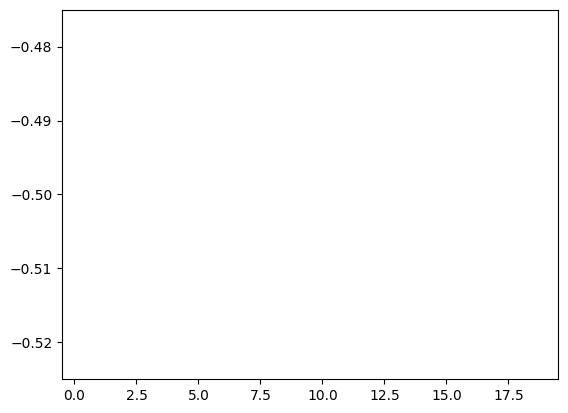

exploring grid: v4 w/ ghost DirectionalGhost_{"index":1,"prob":0.6}, noise-no_noise


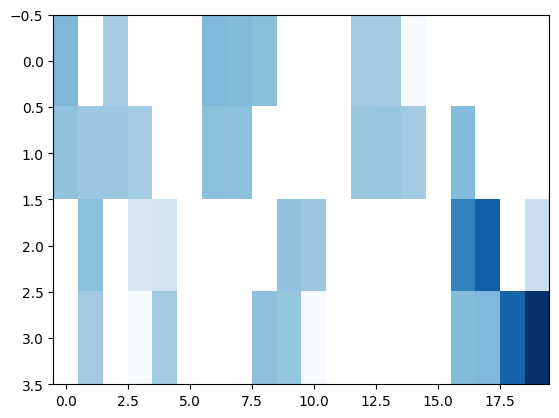

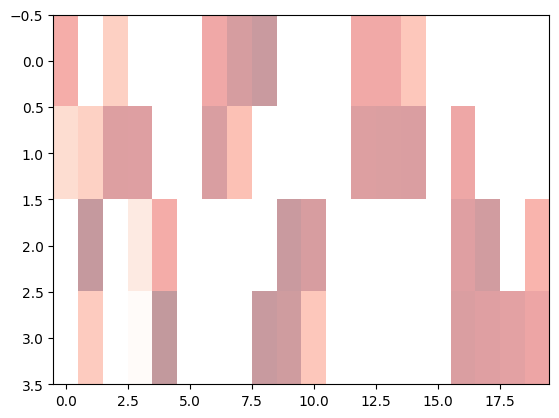

/tmp/ipykernel_25688/2415724376.py:17: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



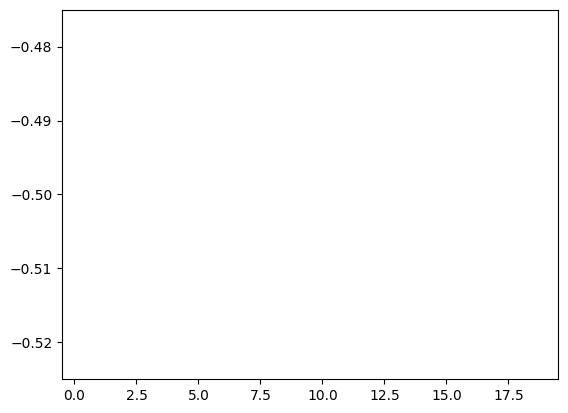

In [10]:
ax = plt.axes()
for grid in data.keys():
    for ghost in data[grid].keys():
        print(f"exploring grid: {grid} w/ ghost {ghost}, noise-no_noise")
        actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)
        action_pd_no_noise =pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0}').T.stack().apply(pd.Series).T.iloc[["0","1","2","4"]]
        action_pd_no_noise.columns = action_pd_no_noise.columns.droplevel()
        actions = len(pd.DataFrame(data[grid][ghost]).stack().apply(pd.Series).columns)
        action_pd_noise = pd.DataFrame(data[grid][ghost],index=name[grid][ghost]).T.filter(like='{"mean":0,"std":0.1}').T.stack().apply(pd.Series).T.iloc[["0","1","2","4"]]
        action_pd_noise.columns = action_pd_noise.columns.droplevel()
        merge = pd.merge(action_pd_no_noise, action_pd_noise, how='outer')
        plt.imshow(merge.iloc[:4,:20], aspect="auto", cmap='Blues',alpha=1, interpolation='none') # I would add interpolation='none'
        plt.show()
        plt.imshow(merge.iloc[4:,:20], aspect="auto", cmap='Reds', alpha=0.4, interpolation='none')
        plt.show()
        diff = pd.DataFrame(merge.iloc[:4,].to_numpy() - merge.iloc[4:,].to_numpy())
        plt.imshow(diff.iloc[4:,:20], aspect="auto", cmap='binary')
        plt.show()

TypeError: Image data of dtype object cannot be converted to float

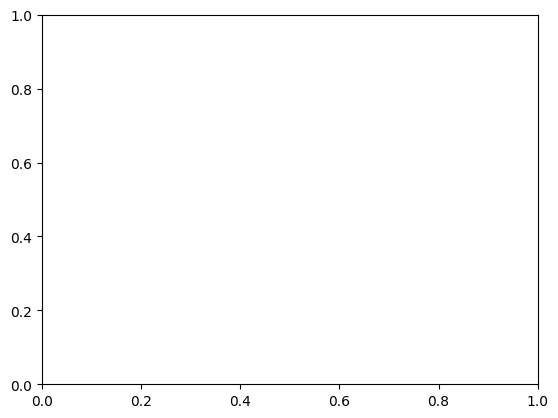

In [22]:
key='v2'
actions = len(pd.DataFrame(data[key]).stack().apply(pd.Series).columns)
action_pd_no_noise = pd.DataFrame(data[key]).stack().apply(pd.Series).xs(0, level=0).T.iloc[["0","1","2","4"]]
plt.imshow(action_pd_no_noise.iloc[:,:20], aspect="auto")

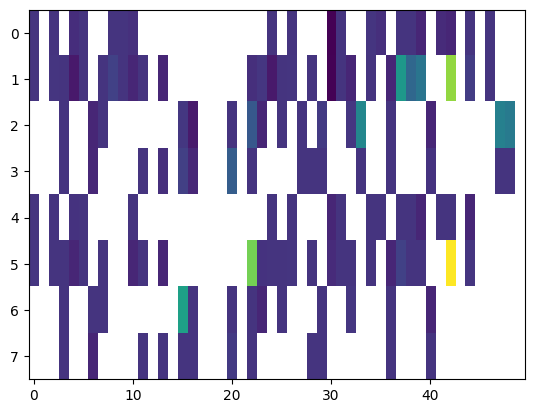

In [220]:
merge = pd.merge(action_pd_no_noise, action_pd_noise, how='outer')
plt.imshow(merge.iloc[:,-100:-50], aspect="auto")

In [187]:
for key in data:
    print(f"examining {key}")
    actions = len(pd.DataFrame(data[key]).stack().apply(pd.Series).columns)
    action_pd_noise = pd.DataFrame(data[key]).stack().apply(pd.Series).xs(1, level=0).T
    print(sum(sum(action_pd_noise.T[["0","1","2","4"]].T.isnull().to_numpy())))
    action_pd_no_noise = pd.DataFrame(data[key]).stack().apply(pd.Series).xs(0, level=0).T
    print(sum(sum(action_pd_no_noise.T[["0","1","2","4"]].T.isnull().to_numpy())))
    print(action_pd_noise.shape, action_pd_no_noise.shape)

examining v2
367
1086
(4, 331) (4, 969)
examining v3
821
1098
(4, 365) (4, 471)
examining v4


KeyError: 1

1086

(4, 331) (4, 969)


In [105]:
action_no_noise = pd.DataFrame(data["v2"]).stack().apply(pd.Series).xs(0, level=0).T
action_pd_noise = pd.DataFrame(data["v2"]).stack().apply(pd.Series).xs(1, level=0).T
merge_df = pd.merge(action_pd_no_noise, how="outer")
merge_df.head()

%%%%%%%\n%    P%\n%G   .%\n%     %\n%     %\n%.    %\n%%%%%%%  \
0                                         109.852707               
1                                          -0.097500               
2                                                NaN               
3                                                NaN               
4                                         -47.193796               

   %%%%%%%\n%     %\n%    P%\n%G    %\n%     %\n%.    %\n%%%%%%%  \
0                                          -0.964177               
1                                          71.961955               
2                                          -1.141752               
3                                                NaN               
4                                           0.338720               

   %%%%%%%\n%     %\n%   P %\n% G   %\n%     %\n%.    %\n%%%%%%%  \
0                                         122.001150               
1                                          -0.444624               
2                                          -0.462592               
3                                          -0.458734               
4                                           2.269786               

   %%%%%%%\n%   P %\n% G   %\n%     %\n%     %\n%.    %\n%%%%%%%  \
0                                           4.481890               
1                                          -0.771629               
2                                                NaN               
3                                          -0.766429               
4                                          -0.310193               

   %%%%%%%\n% GP  %\n%     %\n%     %\n%     %\n%.    %\n%%%%%%%  \
0                                           2.185241               
1                                         -25.050000               
2                                                NaN               
3                                          -0.778150               
4                                          -0.838705               

   %%%%%%%\n% G   %\n%     %\n%     %\n%     %\n%.    %\n%%%%%%%  \
0                                                NaN               
1                                                NaN               
2                                                NaN               
3                                                NaN               
4                                                NaN               

   %%%%%%%\n%G  P %\n%    .%\n%     %\n%     %\n%.    %\n%%%%%%%  \
0                                          -0.050000               
1                                           0.000000               
2                                                NaN               
3                                          -0.050000               
4                                           2.373999               

   %%%%%%%\n%     %\n%     %\n%  P  %\n%G    %\n%.    %\n%%%%%%%  \
0                                          11.668361               
1                                          -0.086758               
2                                          -0.050000               
3                                          -0.088585               
4                                           0.000000               

   %%%%%%%\n%     %\n%     %\n%GP   %\n%     %\n%.    %\n%%%%%%%  \
0                                           1.731374               
1                                         -25.050000               
2                                          -0.145463               
3                                          -0.050000               
4                                          -0.050000               

   %%%%%%%\n%     %\n%     %\n%G    %\n%     %\n%.    %\n%%%%%%%  ...  \
0                                                NaN              ...   
1                                                NaN              ...   
2                                                NaN              ...   
3                             

In [70]:
col_1 = list(action_0_pd_noise.keys())
col_2 = []
corr, fig_corr, p, fig_p, fig_r2 = correlation(action_0_pd_noise)

TypeError: 'float' object is not subscriptable

In [ ]:
y_s = info_n_robert_base.iloc[:,1:22]
X = info_n_robert_base.iloc[:,22:]
col_1 = ['0_x']
col_2 = list(y_s.keys())
corr, fig_corr, p, fig_p, fig_r2 = correlation(corr_matrix_df)

In [ ]:
pd.DataFrame(data["v2"]).stack().apply(pd.Series).xs(1, level=0).T